<a href="https://colab.research.google.com/github/DenisPushkin/CGAN/blob/master/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conditional GAN (CGAN)**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from random import randint
import skimage.transform
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, Activation, LeakyReLU, Embedding, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import ast
print(tf.__version__)

2.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
InceptionV3_model = tf.keras.applications.InceptionV3()

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = skimage.transform.resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)
 
# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=1, eps=1E-16):
	# enumerate splits of images/predictions
	scores = list()
	n_part = np.int(np.floor(images.shape[0] / n_split))
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		subset = subset / 1.0
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
    #subset = tf.keras.applications.inception_v3.preprocess_input(subset)
		# predict p(y|x)
		p_yx = InceptionV3_model.predict(subset)
		# calculate p(y)
		p_y = np.expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = np.mean(sum_kl_d)
		# undo the log
		is_score = np.exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg = np.mean(scores)
	return is_avg
 
(images, _), (_, _) = tf.keras.datasets.mnist.load_data()
IS = np.empty(5)
for i in range(5):
		images_batch = images[1000*i:1000*(i+1)]
		np.random.shuffle(images)
		IS[i] = calculate_inception_score(images_batch, n_split=1)
		print('score', IS[i])
print('mean=', np.mean(IS))

score 2.011183023452759
score 1.9674490690231323
score 1.9933232069015503
score 2.0142664909362793
score 1.950742483139038
mean= 1.9873928546905517


In [ ]:
print("{:.5f}".format(IS.mean()))

21279142601359642905072794935015225013587041975684621969861753702920739169414595533814927071639591421070547720264927688250015801307657415669742829696154428090840937361691967853383491771166336357940118121853543856958435491840.00000


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:,:,:,np.newaxis]
#x_train = tf.image.resize_with_pad(x_train, target_height=32, target_width=32).numpy()
x_train = x_train/127.5 - 1 #to [-1, 1] range

x_test = x_test[:,:,:,np.newaxis]
#x_test = tf.image.resize_with_pad(x_test, target_height=32, target_width=32).numpy()
x_test = x_test/127.5 - 1 #to [-1, 1] range

#y_train = tf.keras.utils.to_categorical(y_train)

#y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [ ]:
class OptimisticAdam:

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='optimistic_adam'):

        self.learning_rate = tf.constant(learning_rate, dtype=tf.float32)
        self.beta_1 = tf.constant(beta_1, dtype=tf.float32)
        self.beta_2 = tf.constant(beta_2, dtype=tf.float32)
        self.epsilon = tf.constant(epsilon, dtype=tf.float32)
        self.m = {}
        self.v = {}
        self.lr_prev = {}
        self.t = {}
    
    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            if var.name not in self.t.keys():
                self.t[var.name] = 1
            else:
                self.t[var.name] += 1
            if var.name not in self.m.keys():
                self.m[var.name] = tf.zeros(shape=var.shape, dtype=tf.float32)
            self.m[var.name] = self.beta_1*self.m[var.name] + (1-self.beta_1)*grad
            if var.name not in self.v.keys():
                self.v[var.name] = tf.zeros(shape=var.shape, dtype=tf.float32)
            self.v[var.name] = self.beta_2*self.v[var.name] + (1-self.beta_2)*tf.math.multiply(grad,grad)
            m_head = self.m[var.name] / (1 - math.pow(self.beta_1, self.t[var.name]))
            v_head = self.v[var.name] / (1 - math.pow(self.beta_2, self.t[var.name]))
            lr_t = m_head / tf.sqrt(v_head + self.epsilon)
            if var.name not in self.lr_prev.keys():
                self.lr_prev[var.name] = lr_t

            var.assign_sub(2*self.learning_rate*lr_t)
            var.assign_add(self.learning_rate*self.lr_prev[var.name])

            self.lr_prev[var.name] = lr_t

class ExtraAdam(tf.keras.optimizers.Adam):
    """
    ExtraAdam optimizer is actually Adam optimizer, but depending of optimizer type
    disc_backpropagation and gen_backpropagation functions of the model behave differently.
    They contain the following if-claus:
    
    if type(optimizer) == ExtraAdam:
        ...

    """
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='extra_adam'):
        super(ExtraAdam, self).__init__(learning_rate, beta_1, beta_2, epsilon)


In [ ]:
class CGAN(Model):
    
    def __init__(self, optimizer, x_train, y_train, batch_size=64, use_averaging=False,
                 path='/content/drive/My Drive/Univ/Final models/Saved models/CGAN Adam/'):
        super(CGAN, self).__init__()
        self.discriminator = self.get_discriminator()
        self.generator = self.get_generator()
        self.latent_dimension = self.generator.get_layer('input_latent').input.shape[1]
        self.use_averaging = use_averaging
        self.generator_avr = self.get_generator() #saves average of variables
        self.num_classes = 10
        self.batch_size = batch_size
        self.dataset_generator = self.get_train_dataset(x_train, y_train)
        #self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
        self.optimizer = optimizer
        self.losses_per_epoch = {'generator': [], 'discriminator': []}
        self.first_grads_mean_per_epoch = {'generator': [], 'discriminator': []}
        self.last_grads_mean_per_epoch = {'generator': [], 'discriminator': []}
        self.IS_per_epoch = [] #inception scores
        self.epoch = 0
        self.path = path
        self.train_steps_for_average = 0
        self.IS_for_avr_per_epoch = []

    def get_generator(self, latent_dim=128, num_classes=10):
        input_label = Input(shape = (1,), name='input_label')
        h1 = Embedding(num_classes, 50)(input_label)
        h1 = Dense(4*4)(h1)
        h1 = Reshape((4,4,1))(h1)
        input_latent = Input(shape = (latent_dim,), name='input_latent')
        h2 = Dense(4*4*256)(input_latent)
        h2 = Reshape((4,4,256))(h2)
        h = Concatenate(axis=-1)([h2,h1])
        h = Activation('tanh')(h)
        h = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides = (2,2), padding='same', activation = 'tanh')(h)
        h = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides = (2,2), padding='same', activation = 'tanh')(h)
        h = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding='same', activation='tanh')(h)
        outputs = h[:,2:-2,2:-2,:]
        generator = Model(inputs=[input_latent, input_label], outputs=outputs)
        return generator
    
    def get_discriminator(self,num_classes=10):
        input_label = Input(shape = (1,))
        h1 = Embedding(num_classes, 50)(input_label)
        h1 = Dense(28*28)(h1)
        h1 = Reshape((28,28,1))(h1)
        input_image = Input(shape=(28,28,1))
        h = Concatenate(axis=-1)([input_image, h1])
        h = Conv2D(64, (5,5), strides=(2,2), padding='same')(h)
        h = LeakyReLU(0.2)(h)
        h = Conv2D(128, (5,5), strides=(2,2), padding='same')(h)
        h = LeakyReLU(0.2)(h)
        h = Conv2D(256, (5,5), strides=(2,2), padding='same')(h)
        h = LeakyReLU(0.2)(h)
        h = Flatten()(h)
        outputs = Dense(1, activation='linear')(h)
        discriminator = Model(inputs=[input_image, input_label], outputs=outputs)
        return discriminator

    def get_train_dataset(self, x_train, y_train):
        x_train = tf.cast(x_train, dtype=tf.float32)
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.batch(self.batch_size, drop_remainder=True)
        return train_dataset

    def sample_noise(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        noise = np.random.normal(size = (batch_size, self.latent_dimension))
        labels = np.random.randint(low=0, high=self.num_classes, size=(batch_size,))
        return (noise, labels)

    @tf.function
    def disc_backpropagation(self, data, labels_for_digits, labels_for_discriminator, loss_fn):
        if type(self.optimizer) == ExtraAdam:
            (disc_grads, disc_loss) = self.disc_backpropagation_for_extraadam(data, labels_for_digits, labels_for_discriminator, loss_fn)
        else:
            with tf.GradientTape() as tape:
                logits = self.discriminator([data, labels_for_digits])
                disc_loss = loss_fn(labels_for_discriminator, logits)
            disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        return (disc_grads, disc_loss)
    
    
    def disc_backpropagation_for_extraadam(self, data, labels_for_digits, labels_for_discriminator, loss_fn):
        indexes = np.arange(2 * self.batch_size)
        np.random.shuffle(indexes)
        data_2 = tf.gather(data, indexes[self.batch_size:])
        labels_for_digits_2 = tf.gather(labels_for_digits, indexes[self.batch_size:])
        labels_for_discriminator_2 = tf.gather(labels_for_discriminator, indexes[self.batch_size:])
        data = tf.gather(data, indexes[:self.batch_size])
        labels_for_digits = tf.gather(labels_for_digits, indexes[:self.batch_size])
        labels_for_discriminator = tf.gather(labels_for_discriminator, indexes[:self.batch_size])
        with tf.GradientTape() as tape:
            logits = self.discriminator([data, labels_for_digits])
            disc_loss = loss_fn(labels_for_discriminator, logits)
        disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        prev_trainable_variables = self.discriminator.trainable_variables
        self.optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        with tf.GradientTape() as tape:
            logits_2 = self.discriminator([data_2, labels_for_digits_2])
            disc_loss_2 = loss_fn(labels_for_discriminator_2, logits_2)
        disc_grads_2 = tape.gradient(disc_loss_2, self.discriminator.trainable_variables)
        for (v,x) in zip(self.discriminator.trainable_variables, prev_trainable_variables):
            v.assign(x)
        self.optimizer.apply_gradients(zip(disc_grads_2, self.discriminator.trainable_variables))
        return (disc_grads, disc_loss)

    @tf.function
    def gen_backpropagation(self, noise, labels, loss_fn):
        if type(self.optimizer) == ExtraAdam:
            (gen_grads, gen_loss) = self.gen_backpropagation_for_extraadam(noise, labels, loss_fn)
        else:
            with tf.GradientTape() as tape:
                gen_data = self.generator([noise, labels])
                logits = self.discriminator([gen_data, labels])
                gen_loss = loss_fn(logits)
            gen_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
            self.optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        return (gen_grads, gen_loss)
    
    def gen_backpropagation_for_extraadam(self, noise, labels, loss_fn):
        indexes = np.arange(self.batch_size)
        np.random.shuffle(indexes)
        noise_2 = tf.gather(noise, indexes[self.batch_size//2:])
        labels_2 = tf.gather(labels, indexes[self.batch_size//2:])
        noise = tf.gather(noise, indexes[:self.batch_size//2])
        labels = tf.gather(labels, indexes[:self.batch_size//2])
        with tf.GradientTape() as tape:
            gen_data = self.generator([noise, labels])
            logits = self.discriminator([gen_data, labels])
            gen_loss = loss_fn(logits)
        gen_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
        prev_trainable_variables = self.generator.trainable_variables
        self.optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        with tf.GradientTape() as tape:
            gen_data_2 = self.generator([noise_2, labels_2])
            logits_2 = self.discriminator([gen_data_2, labels_2])
            gen_loss_2 = loss_fn(logits_2)
        gen_grads_2 = tape.gradient(gen_loss_2, self.generator.trainable_variables)
        for (v,x) in zip(self.generator.trainable_variables, prev_trainable_variables):
            v.assign(x)
        self.optimizer.apply_gradients(zip(gen_grads_2, self.generator.trainable_variables))
        return (gen_grads_2, gen_loss_2)

    def train(self, epochs):

        disc_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        def gen_loss_fn(logits):
            #p = tf.ones([self.batch_size]) - logits[:,-1]
            return tf.reduce_mean(tf.nn.relu(logits) - logits + tf.math.log(1+tf.exp(-tf.abs(logits))))

        for epoch in range(epochs):

            losses_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}
            first_grads_mean_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}
            last_grads_mean_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}

            for (real_data, real_labels) in self.dataset_generator:

                (noise, generated_labels) = self.sample_noise()
                gen_data = self.generator([noise, generated_labels])
                data = tf.concat([real_data, gen_data], axis=0)
                labels_for_digits = tf.concat([real_labels, generated_labels], axis=0)
                #labels_for_discriminator = tf.concat([0.9*tf.ones(shape=(self.batch_size,)), tf.zeros(shape=(self.batch_size,))], axis=0)
                labels_for_discriminator = tf.concat([0.9*tf.ones(shape=(self.batch_size,1)), tf.zeros(shape=(self.batch_size,1))], axis=0)
                (disc_grads, disc_loss) = self.disc_backpropagation(data, labels_for_digits, labels_for_discriminator, disc_loss_fn)
                (noise, generated_labels) = self.sample_noise()
                (gen_grads, gen_loss) = self.gen_backpropagation(noise, generated_labels, gen_loss_fn)

                losses_per_batch['discriminator'](disc_loss)
                losses_per_batch['generator'](gen_loss)
                first_grads_mean_per_batch['discriminator'](tf.math.reduce_mean(tf.abs(disc_grads[0])))
                last_grads_mean_per_batch['discriminator'](tf.math.reduce_mean(tf.abs(disc_grads[-2])))
                first_grads_mean_per_batch['generator'](tf.math.reduce_mean(tf.abs(gen_grads[0])))
                last_grads_mean_per_batch['generator'](tf.math.reduce_mean(tf.abs(gen_grads[-2])))

                if self.use_averaging:
                    self.update_avr_variables()
            
            self.losses_per_epoch['generator'].append(losses_per_batch['generator'].result().numpy())
            self.losses_per_epoch['discriminator'].append(losses_per_batch['discriminator'].result().numpy())
            self.first_grads_mean_per_epoch['generator'].append(first_grads_mean_per_batch['generator'].result().numpy())
            self.last_grads_mean_per_epoch['generator'].append(last_grads_mean_per_batch['generator'].result().numpy())
            self.first_grads_mean_per_epoch['discriminator'].append(first_grads_mean_per_batch['discriminator'].result().numpy())
            self.last_grads_mean_per_epoch['discriminator'].append(last_grads_mean_per_batch['discriminator'].result().numpy())
            
            self.epoch += 1
            self.update_IS()
            self.print_state()
            if self.epoch % 1 == 0:
                print('examples of generated images after', self.epoch, 'epochs')
                self.draw_generated_images(rows=4, cols=6)
                if self.use_averaging:
                    print('examples of generated images using average variables after', self.epoch, 'epochs')
                    self.draw_generated_images(rows=4, cols=6, is_from_gen_avr=True)
            if self.epoch % 10 == 1:
                self.save_state_to_file()
    
    def update_avr_variables(self):
        self.train_steps_for_average += 1
        for (v,x) in zip(self.generator_avr.trainable_variables, self.generator.trainable_variables):
            v.assign((1.0/self.train_steps_for_average) * x + (1 - 1.0/self.train_steps_for_average) * v)

    def update_IS(self):
        self.IS_per_epoch.append(calculate_inception_score(self.generate(1000)))
        if self.use_averaging:
            self.IS_for_avr_per_epoch.append(calculate_inception_score(self.generate(1000, is_from_gen_avr=True)))

    def generate(self, num=1, labels=None, is_from_gen_avr=False):
        
        (noise, generated_labels) = self.sample_noise(batch_size = num)
        if labels is None:
            labels = generated_labels
        if is_from_gen_avr:
            generated_data = self.generator_avr([noise, labels])
        else:
            generated_data = self.generator([noise, labels])
        return generated_data
    
    def draw_generated_images(self, rows, cols, labels=None, is_from_gen_avr=False):
        images = self.generate(rows*cols, labels, is_from_gen_avr)
        plt.figure(figsize = (3*cols, 3*rows))
        for i in range(rows*cols):
            plt.subplot(rows, cols, i+1)
            plt.imshow(images[i,:,:,0], cmap='gray')
        plt.show()

    def save_state_to_file(self):
        gen_path = self.path + 'gen_{:03d}_epochs/gen_{:03d}_epochs'.format(self.epoch,self.epoch)                 
        self.generator.save_weights(gen_path)
        disc_path = self.path + 'disc_{:03d}_epochs/disc_{:03d}_epochs'.format(self.epoch,self.epoch)
        self.discriminator.save_weights(disc_path)
        if self.use_averaging:
            gen_avr_path = self.path + 'gen_avr_{:03d}_epochs/gen_avr_{:03d}_epochs'.format(self.epoch,self.epoch)
            self.generator_avr.save_weights(gen_avr_path)
        train_info_path = self.path + 'train_info_{:03d}.txt'.format(self.epoch)
        f=open(train_info_path,'w')
        f.write(str(self.losses_per_epoch['generator']) + '\n')
        f.write(str(self.losses_per_epoch['discriminator']) + '\n')
        f.write(str(self.first_grads_mean_per_epoch['generator']) + '\n')
        f.write(str(self.first_grads_mean_per_epoch['discriminator']) + '\n')
        f.write(str(self.last_grads_mean_per_epoch['generator']) + '\n')
        f.write(str(self.last_grads_mean_per_epoch['discriminator']) + '\n')
        f.write(str(self.IS_per_epoch) + '\n')
        f.write(str(self.IS_for_avr_per_epoch) + '\n')
        f.close()
    
    def print_state(self):
        if self.use_averaging:
            print("Epoch: {:03d}: Gen Loss: {:.3f}, Disc Loss:{:.3f}, IS: {:.3f}, IS_avr: {:.3f}".format(self.epoch,
                                                                self.losses_per_epoch['generator'][-1],
                                                                self.losses_per_epoch['discriminator'][-1],
                                                                self.IS_per_epoch[-1],
                                                                self.IS_for_avr_per_epoch[-1]))
        else:
            print("Epoch: {:03d}: Gen Loss: {:.3f}, Disc Loss:{:.3f}, IS: {:.3f}".format(self.epoch,
                                                                self.losses_per_epoch['generator'][-1],
                                                                self.losses_per_epoch['discriminator'][-1],
                                                                self.IS_per_epoch[-1]))
    
    def draw_IS_per_epoch_graphic(self, is_from_gen_avr=False):
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6, 5))  
        axes.set_xlabel("Epochs", fontsize=14)
        axes.set_ylabel("IS", fontsize=14)
        if is_from_gen_avr:
            axes.set_title('IS gen_avr vs epochs')
        else:
            axes.set_title('IS vs epochs')
        if is_from_gen_avr:
            axes.plot(self.IS_for_avr_per_epoch)
        else:
            axes.plot(self.IS_per_epoch)
        plt.show()
    
    def draw_losses_per_epoch_graphic(self):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))
        
        axes[0].set_xlabel("Epochs", fontsize=14)
        axes[0].set_ylabel("Loss", fontsize=14)
        axes[0].set_title('Generator Loss vs epochs')
        axes[0].plot(self.losses_per_epoch['generator'])

        axes[1].set_title('Discriminator Loss vs Epochs')
        axes[1].set_ylabel("Loss", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=14)
        axes[1].plot(self.losses_per_epoch['discriminator'])
        plt.show()
    
    def draw_grads_per_epoch_graphic(self):
        fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 12))

        axes[0,0].set_xlabel("Epochs", fontsize=14)
        axes[0,0].set_ylabel("Grads", fontsize=14)
        axes[0,0].set_title('Generator first grads mean vs epochs')
        axes[0,0].plot(self.first_grads_mean_per_epoch['generator'])

        axes[0,1].set_xlabel("Epochs", fontsize=14)
        axes[0,1].set_ylabel("Grads", fontsize=14)
        axes[0,1].set_title('Generator last grads mean vs epochs')
        axes[0,1].plot(self.last_grads_mean_per_epoch['generator'])

        axes[1,0].set_xlabel("Epochs", fontsize=14)
        axes[1,0].set_ylabel("Grads", fontsize=14)
        axes[1,0].set_title('Discriminator first grads mean vs epochs')
        axes[1,0].plot(self.first_grads_mean_per_epoch['discriminator'])

        axes[1,1].set_xlabel("Epochs", fontsize=14)
        axes[1,1].set_ylabel("Grads", fontsize=14)
        axes[1,1].set_title('Discriminator last grads mean vs epochs')
        axes[1,1].plot(self.last_grads_mean_per_epoch['discriminator'])

        plt.show()
    
    def upload_from_file(self, epoch=1):
        path = self.path
        self.epoch = epoch
        gen_path = path + 'gen_{:03d}_epochs/gen_{:03d}_epochs'.format(epoch,epoch)
        self.generator.load_weights(gen_path)
        disc_path = path + 'disc_{:03d}_epochs/disc_{:03d}_epochs'.format(epoch,epoch)
        self.discriminator.load_weights(disc_path)
        if self.use_averaging:
            gen_avr_path = path + 'gen_avr_{:03d}_epochs/gen_avr_{:03d}_epochs'.format(epoch,epoch)
            self.generator_avr.load_weights(gen_avr_path)
        path = path + 'train_info_{:03d}.txt'.format(epoch)
        f = open(path,'r')
        train_info = f.read()
        train_info = train_info.split(sep='\n')
        train_info = [elem[12:-1] for elem in train_info]
        self.losses_per_epoch['generator'] = ast.literal_eval(train_info[0])
        self.losses_per_epoch['discriminator'] = ast.literal_eval(train_info[1])
        self.first_grads_mean_per_epoch['generator'] = ast.literal_eval(train_info[2])
        self.first_grads_mean_per_epoch['discriminator'] = ast.literal_eval(train_info[3])
        self.last_grads_mean_per_epoch['generator'] = ast.literal_eval(train_info[4])
        self.last_grads_mean_per_epoch['discriminator'] = ast.literal_eval(train_info[5])
        self.IS_per_epoch = ast.literal_eval(train_info[6])
        self.IS_for_avr_per_epoch = ast.literal_eval(train_info[7])

**Adam**

Epoch: 001: Gen Loss: 2.295, Disc Loss:0.385, IS: 1.998
examples of generated images after 1 epochs


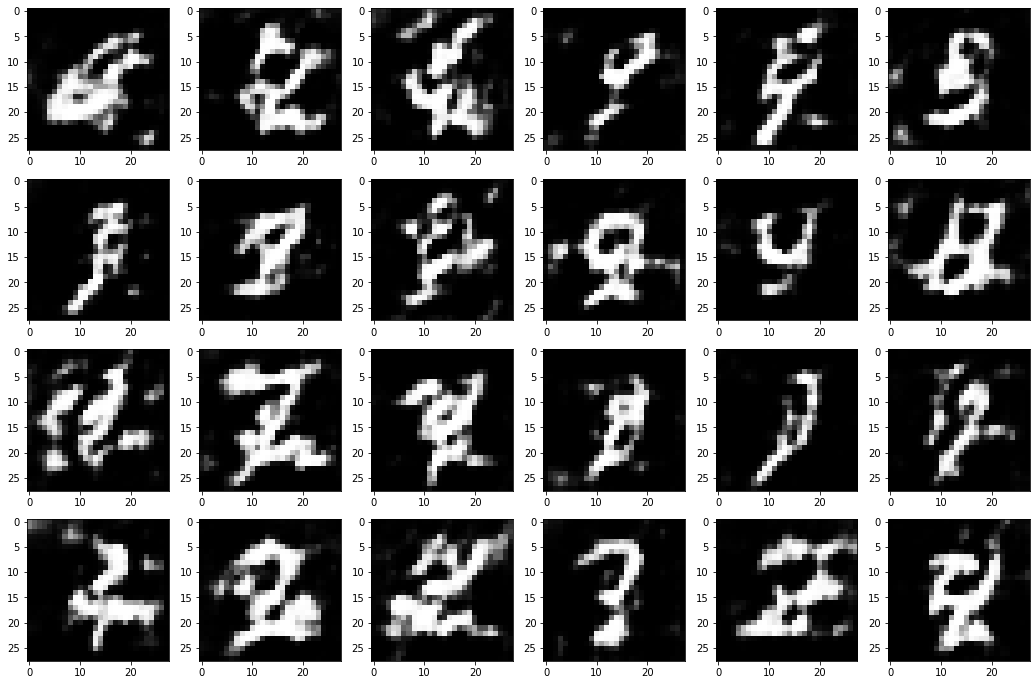

Epoch: 002: Gen Loss: 2.711, Disc Loss:0.361, IS: 2.514
examples of generated images after 2 epochs


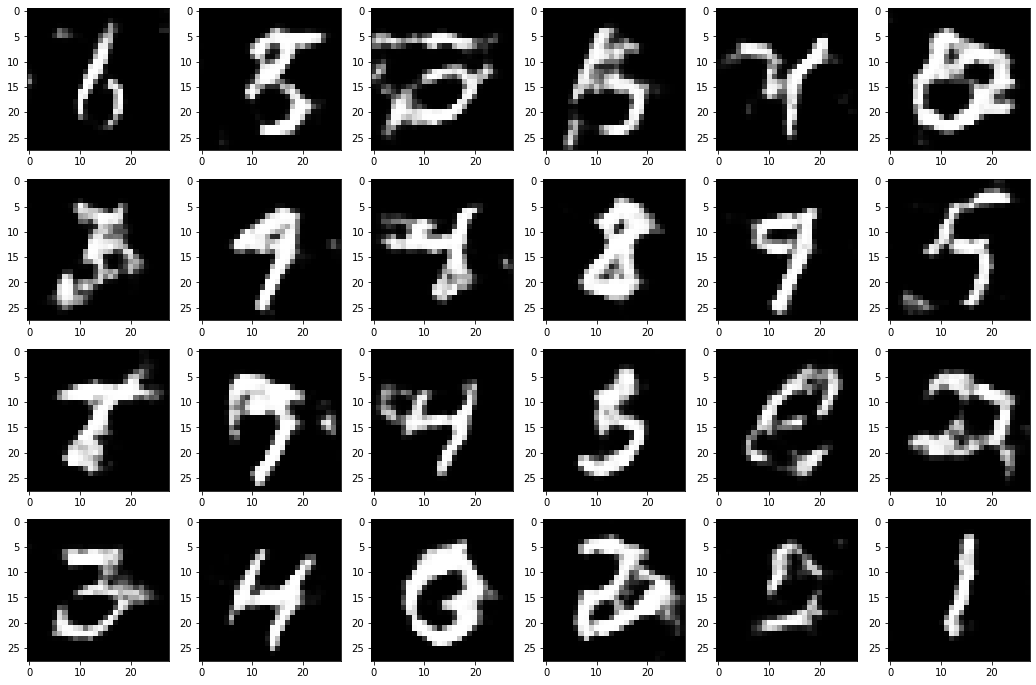

Epoch: 003: Gen Loss: 2.248, Disc Loss:0.402, IS: 2.389
examples of generated images after 3 epochs


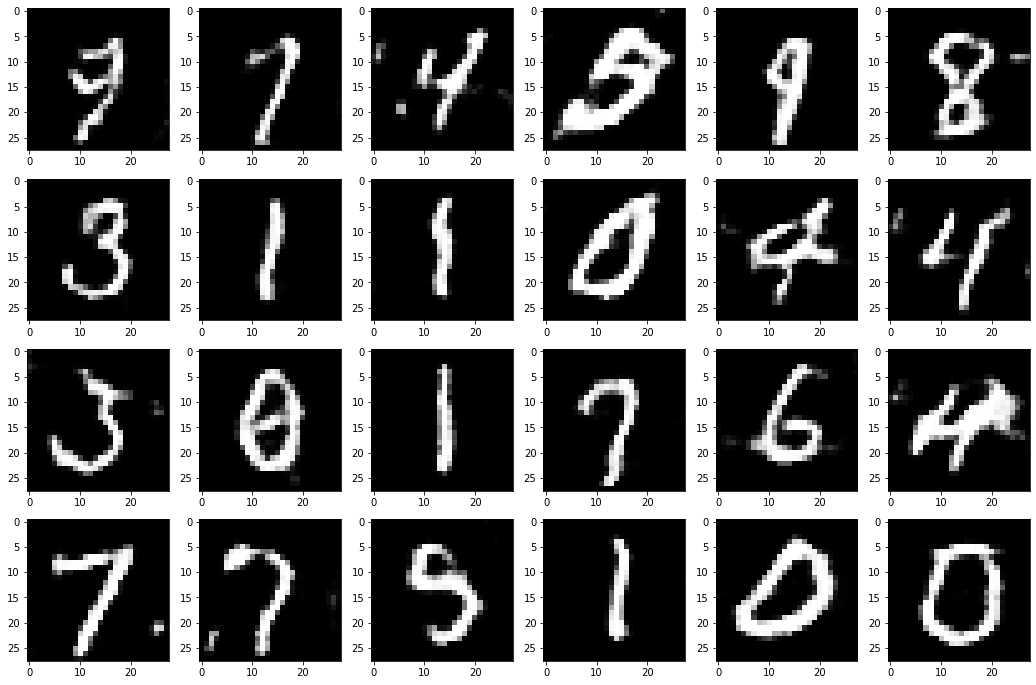

Epoch: 004: Gen Loss: 1.917, Disc Loss:0.448, IS: 2.355
examples of generated images after 4 epochs


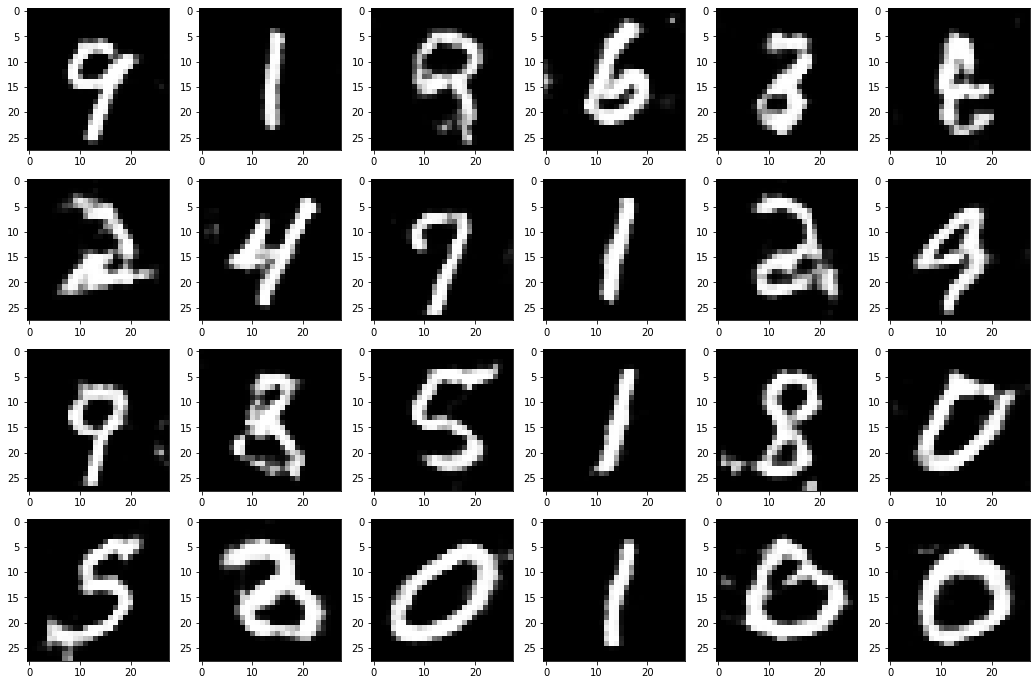

Epoch: 005: Gen Loss: 1.648, Disc Loss:0.495, IS: 2.344
examples of generated images after 5 epochs


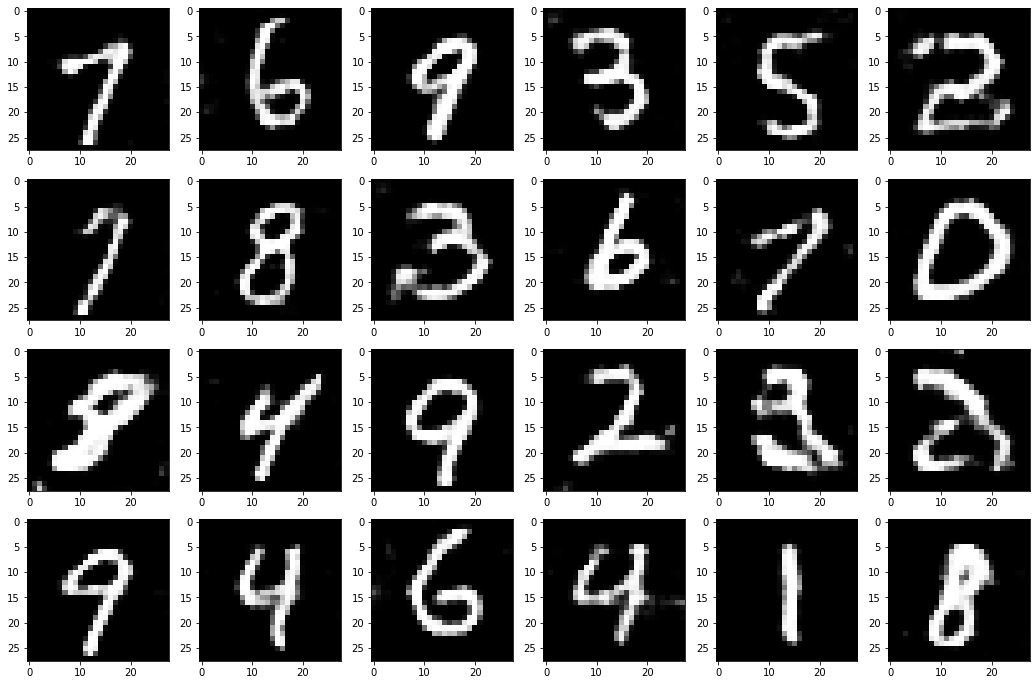

Epoch: 006: Gen Loss: 1.540, Disc Loss:0.518, IS: 2.215
examples of generated images after 6 epochs


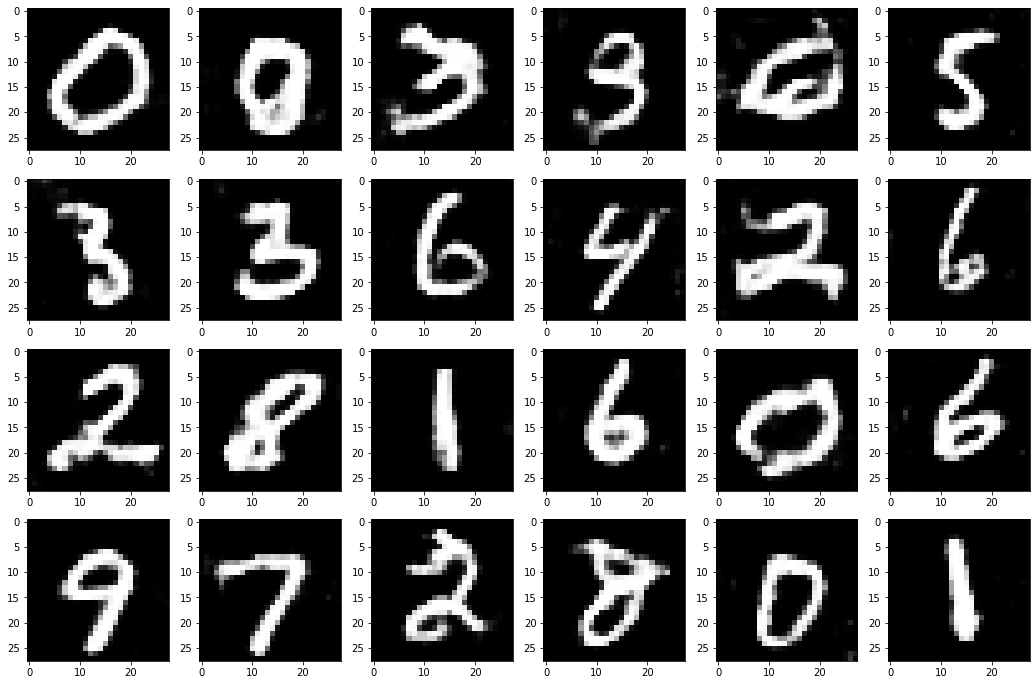

Epoch: 007: Gen Loss: 1.481, Disc Loss:0.529, IS: 2.310
examples of generated images after 7 epochs


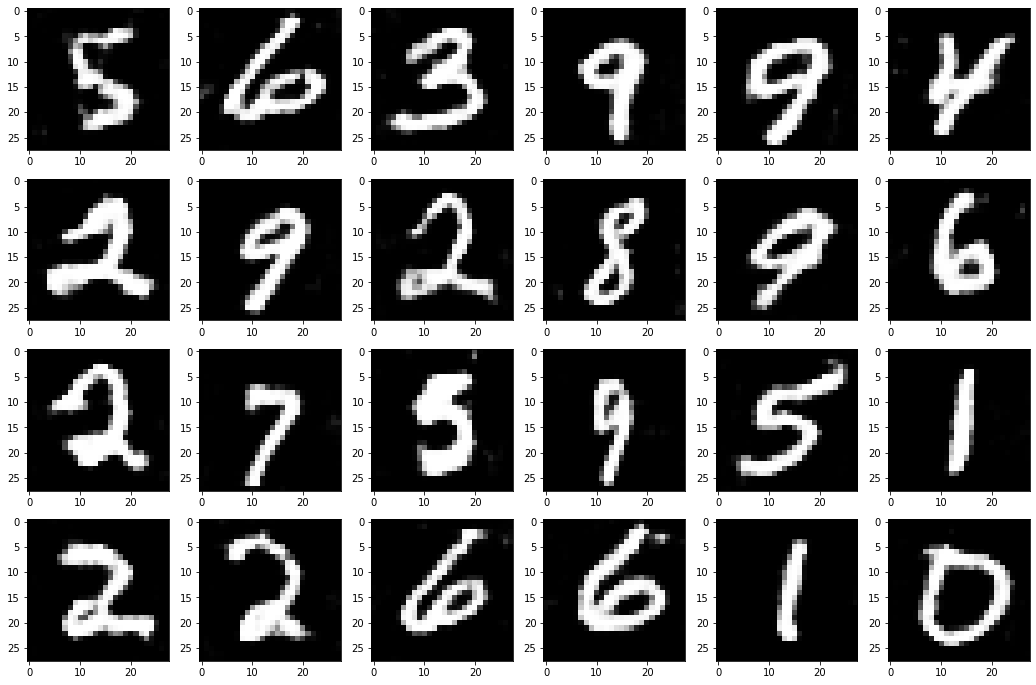

Epoch: 008: Gen Loss: 1.448, Disc Loss:0.534, IS: 2.208
examples of generated images after 8 epochs


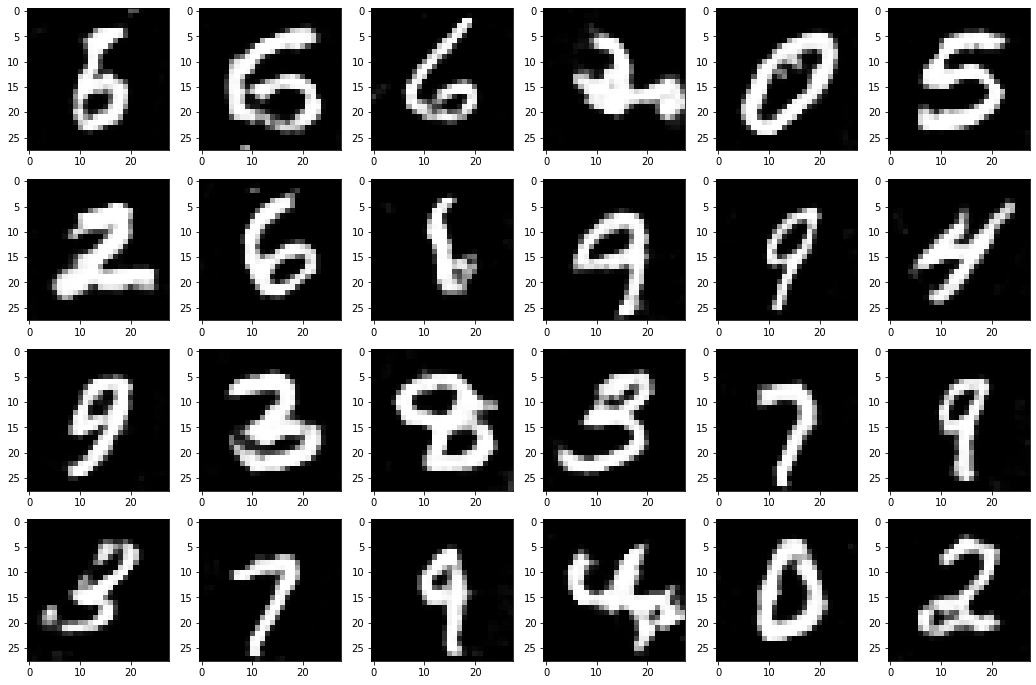

Epoch: 009: Gen Loss: 1.444, Disc Loss:0.536, IS: 2.248
examples of generated images after 9 epochs


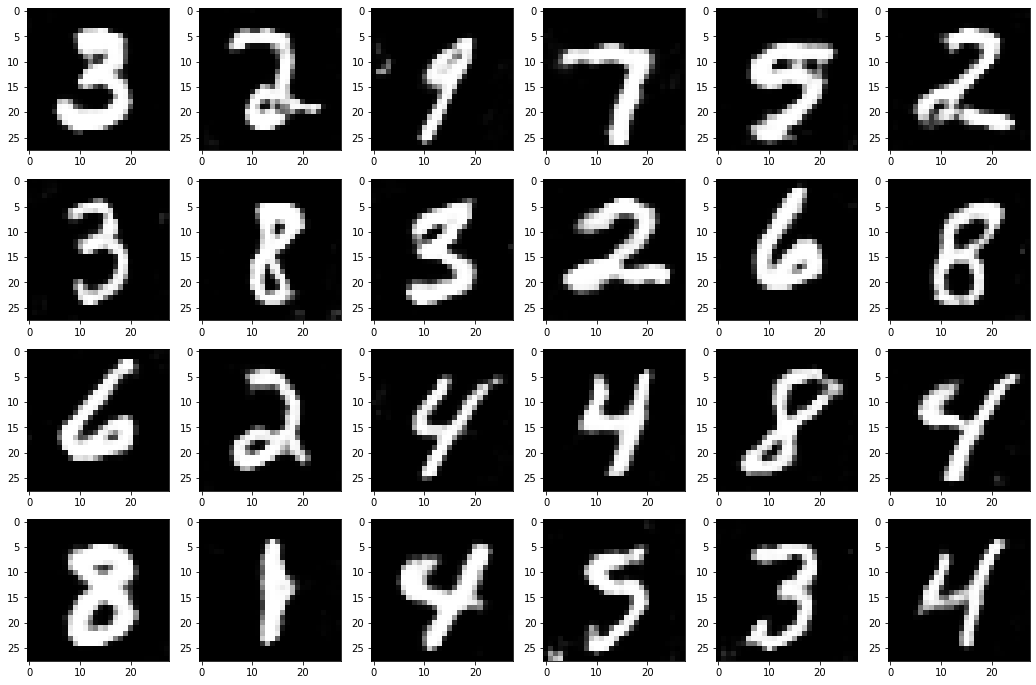

Epoch: 010: Gen Loss: 1.464, Disc Loss:0.533, IS: 2.180
examples of generated images after 10 epochs


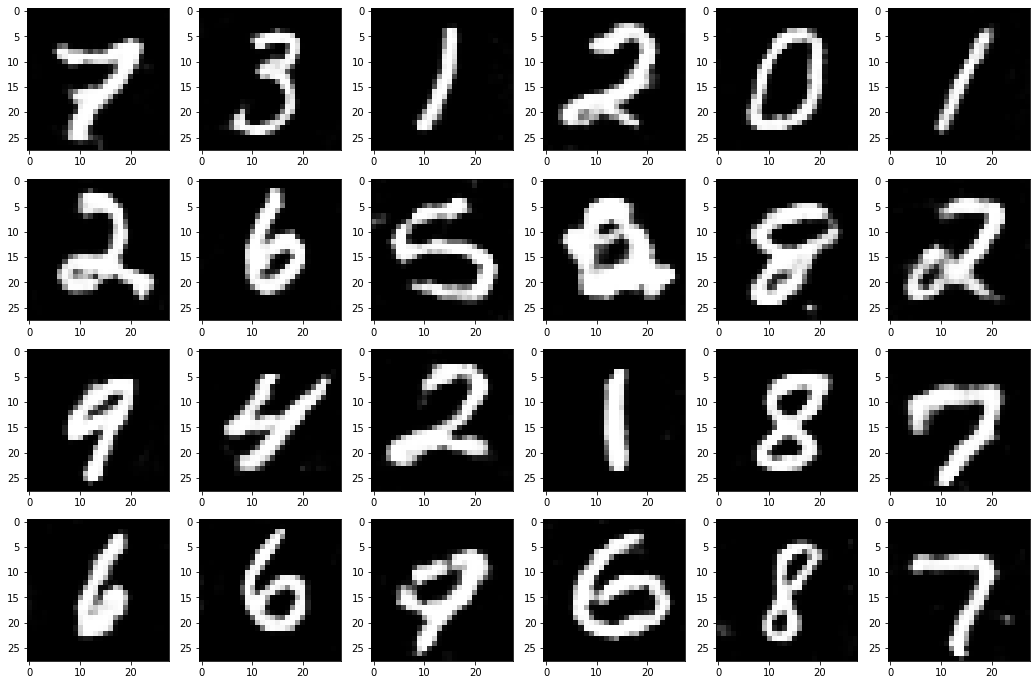

Epoch: 011: Gen Loss: 1.480, Disc Loss:0.526, IS: 2.198
examples of generated images after 11 epochs


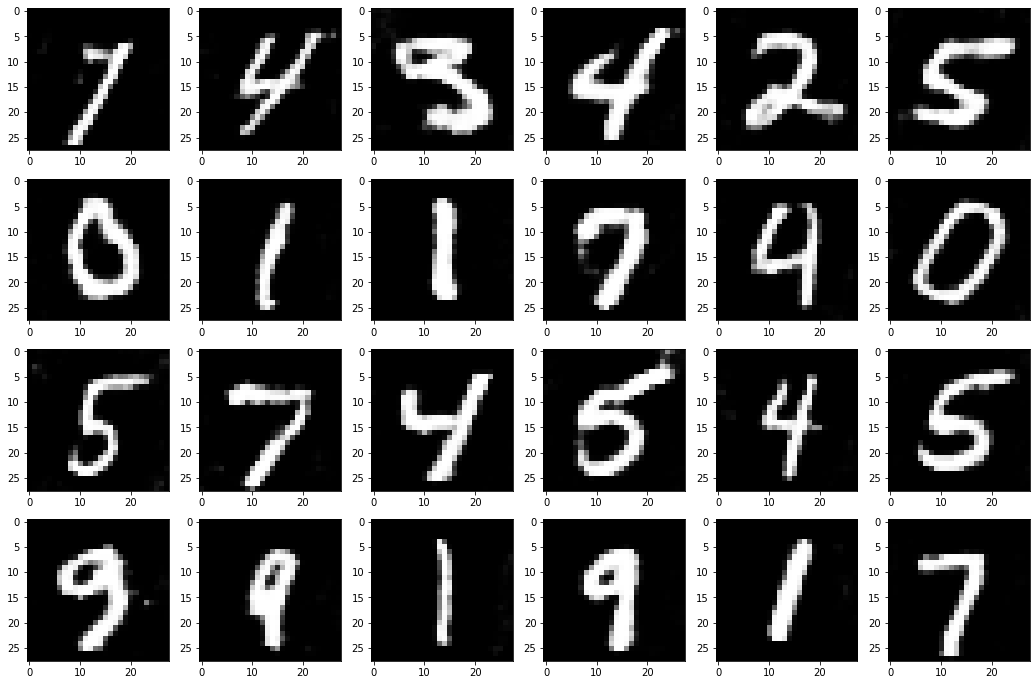

time: 543.0674 sec


In [ ]:
cgan = CGAN(tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), x_train, 
            y_train, batch_size=64, use_averaging=False,
            path='/content/drive/My Drive/Univ/Final models/Saved models/CGAN Adam/')
t0 = time.clock()
cgan.train(epochs=11)
print('time:', time.clock() - t0, 'sec')

Epoch: 012: Gen Loss: 1.515, Disc Loss:0.517, IS: 2.213, IS_avr: 2.225
examples of generated images after 12 epochs


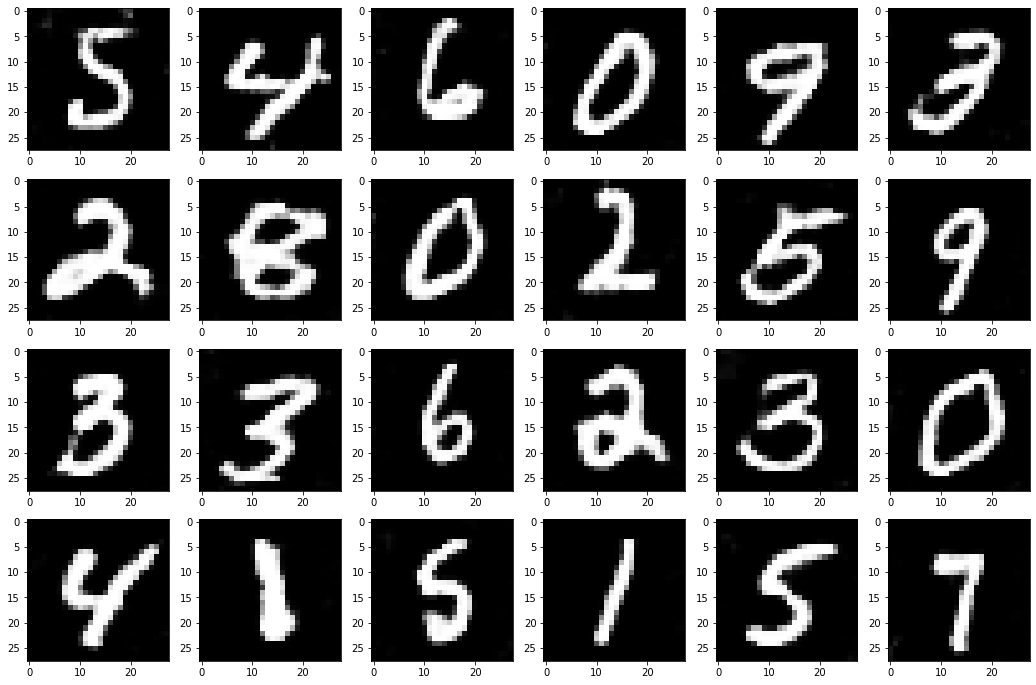

examples of generated images using average variables after 12 epochs


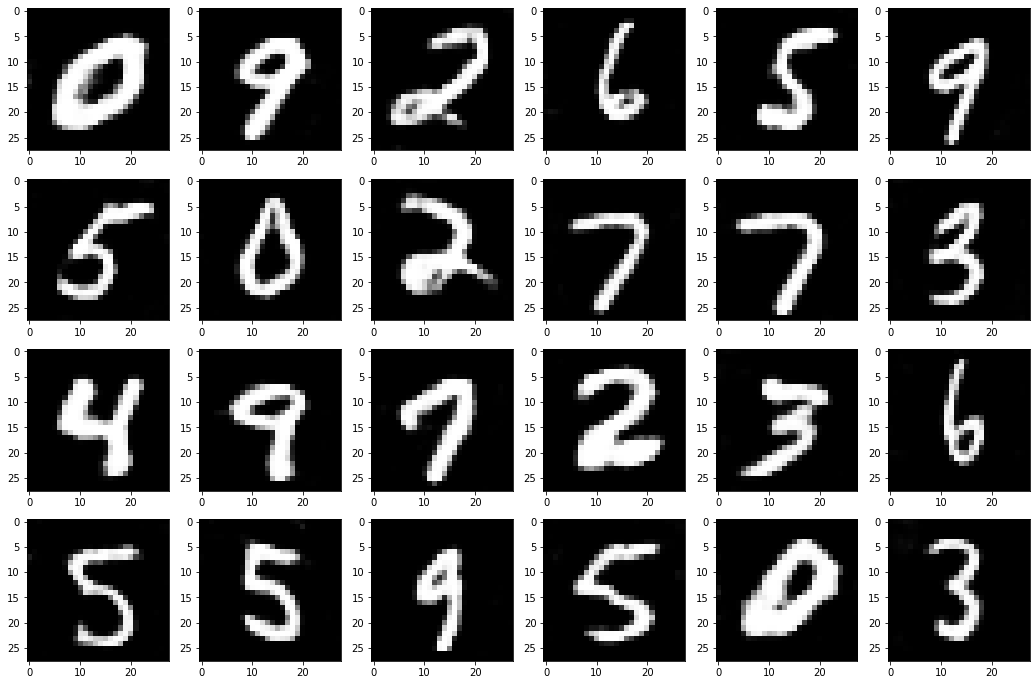

Epoch: 013: Gen Loss: 1.558, Disc Loss:0.509, IS: 2.184, IS_avr: 2.223
examples of generated images after 13 epochs


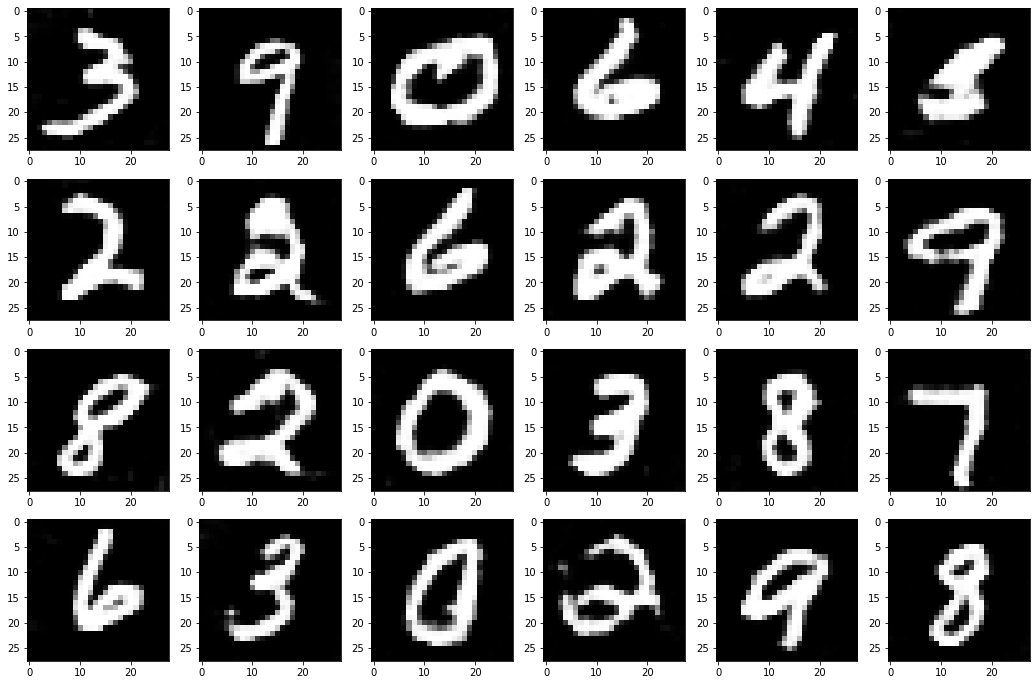

examples of generated images using average variables after 13 epochs


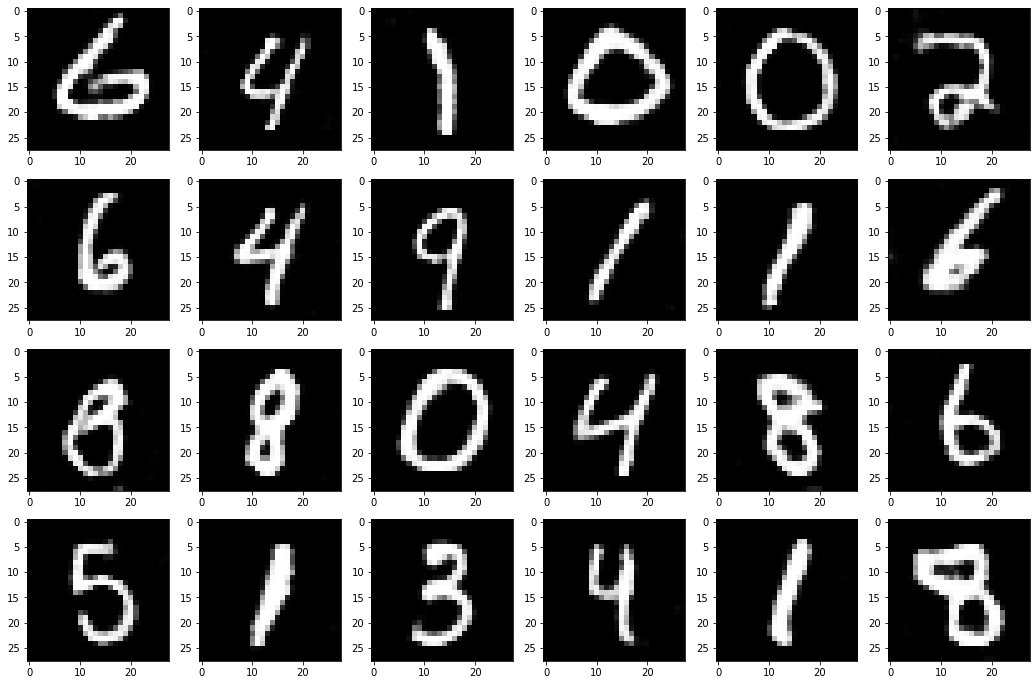

Epoch: 014: Gen Loss: 1.606, Disc Loss:0.501, IS: 2.148, IS_avr: 2.341
examples of generated images after 14 epochs


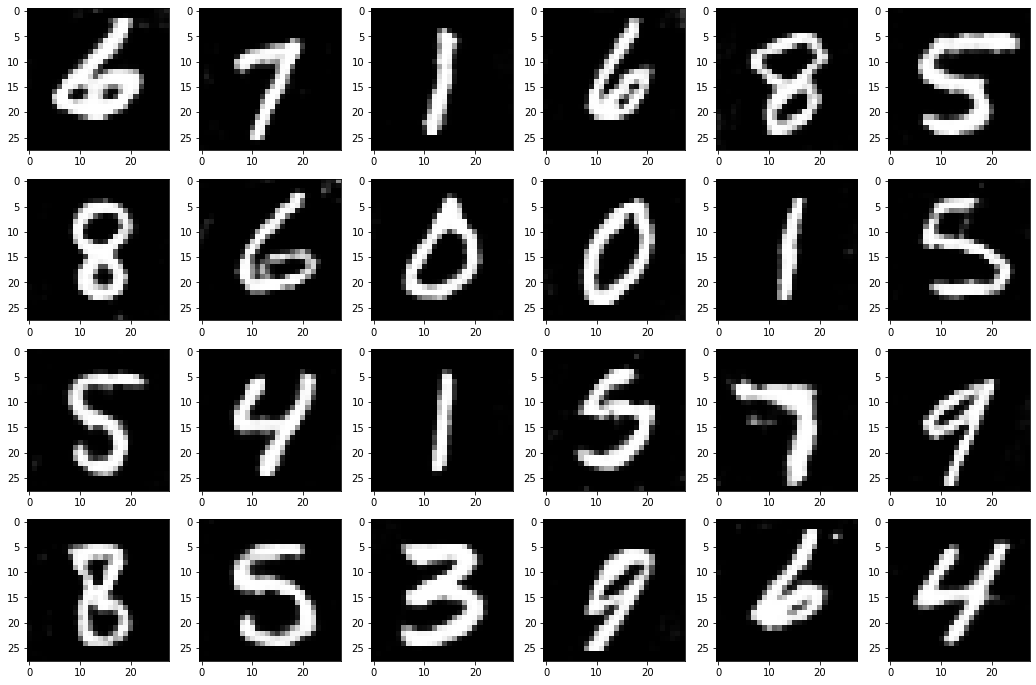

examples of generated images using average variables after 14 epochs


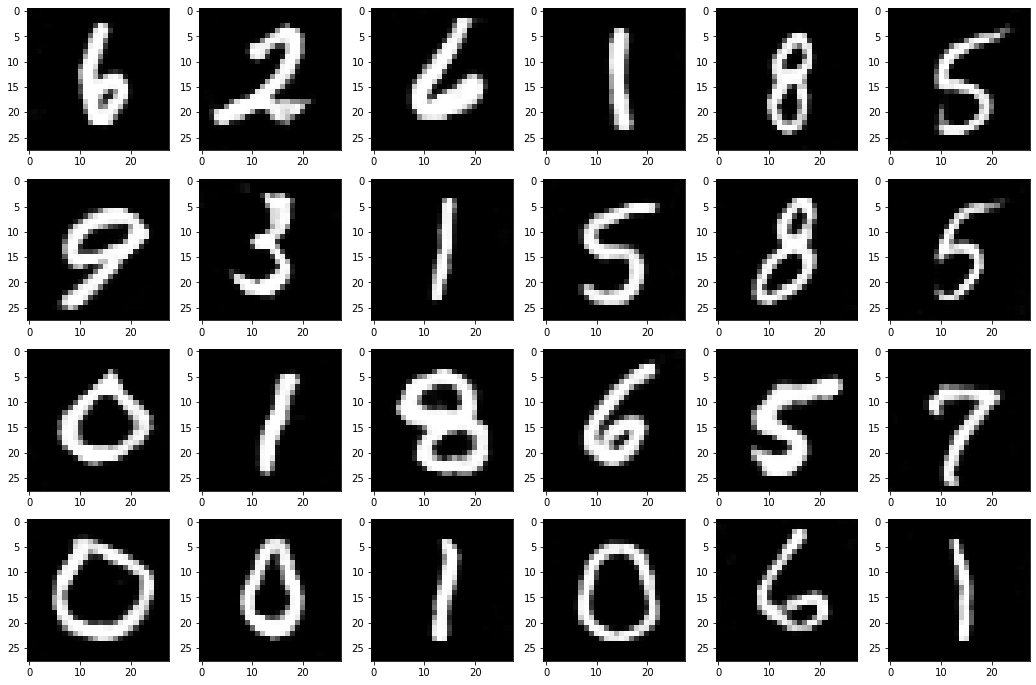

Epoch: 015: Gen Loss: 1.642, Disc Loss:0.496, IS: 2.220, IS_avr: 2.261
examples of generated images after 15 epochs


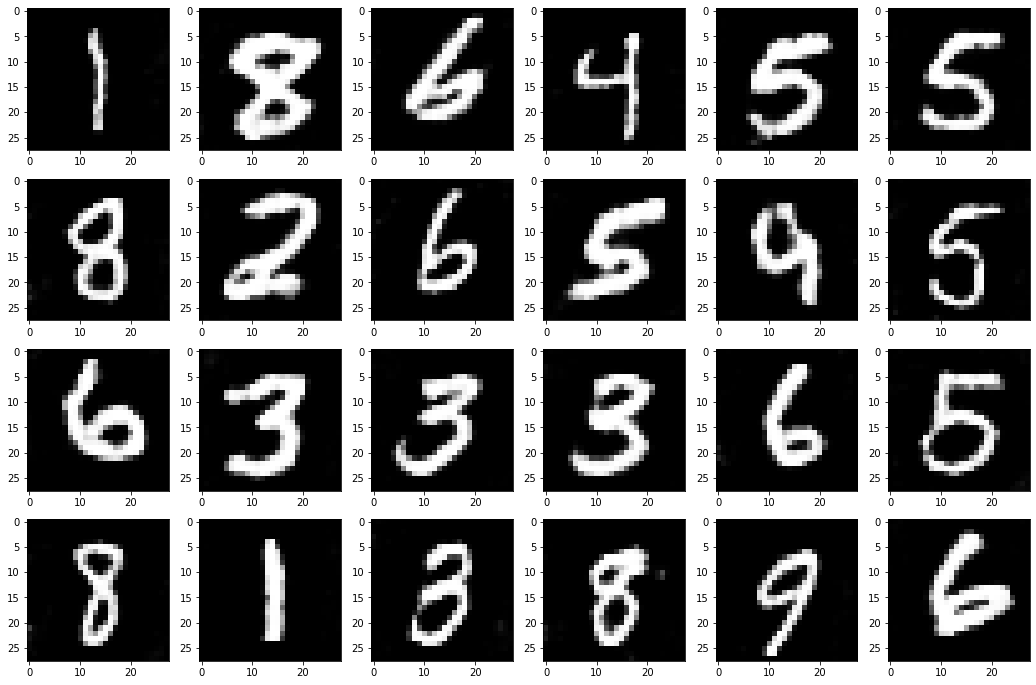

examples of generated images using average variables after 15 epochs


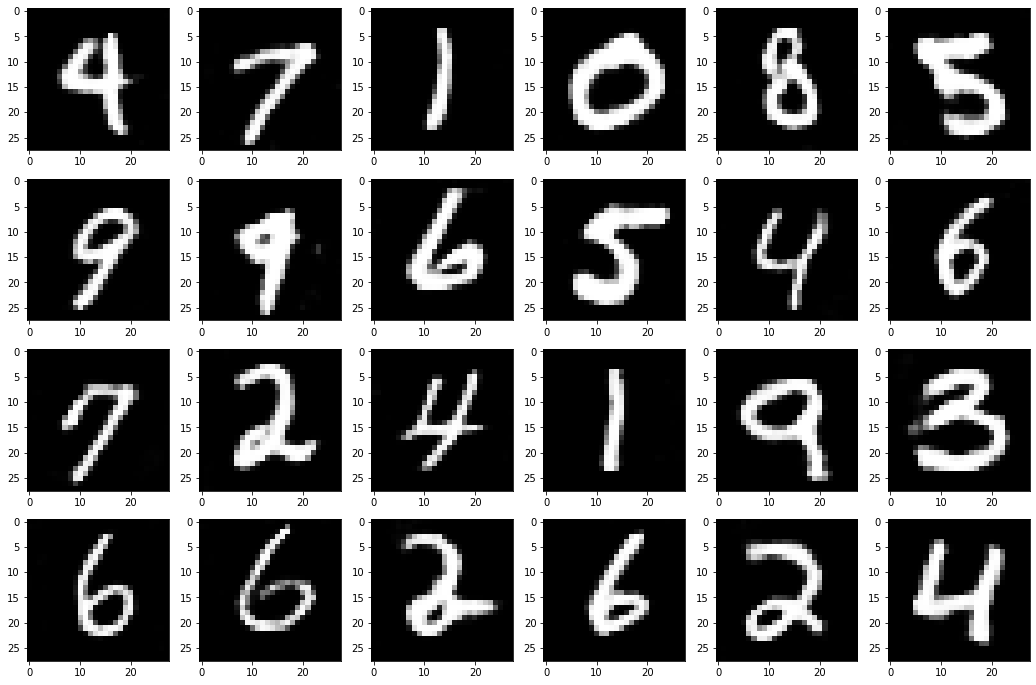

Epoch: 016: Gen Loss: 1.676, Disc Loss:0.487, IS: 2.197, IS_avr: 2.293
examples of generated images after 16 epochs


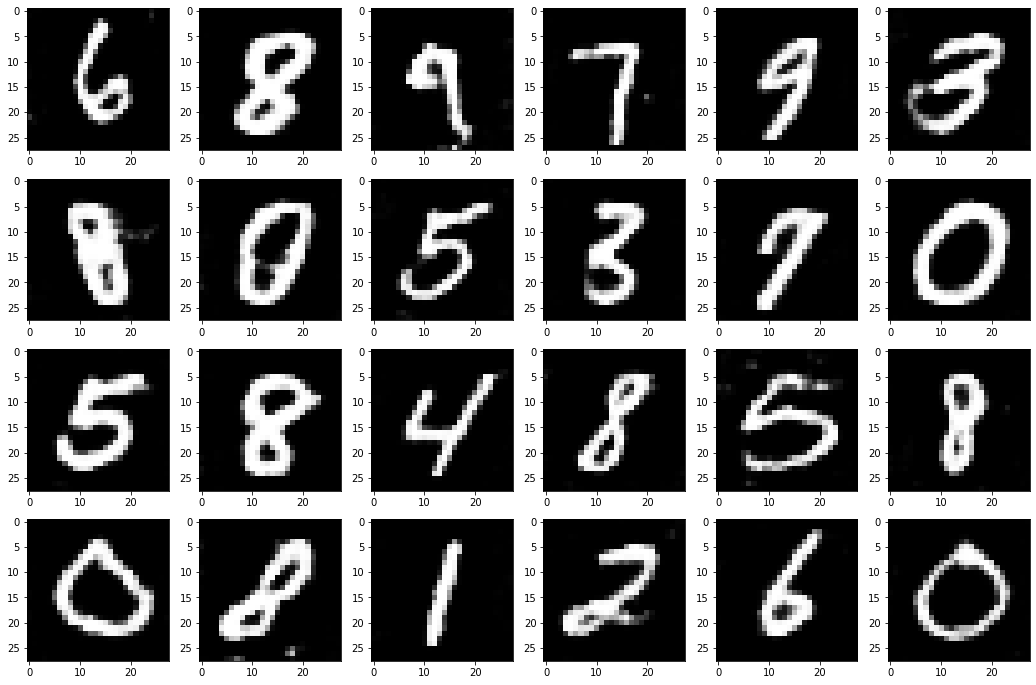

examples of generated images using average variables after 16 epochs


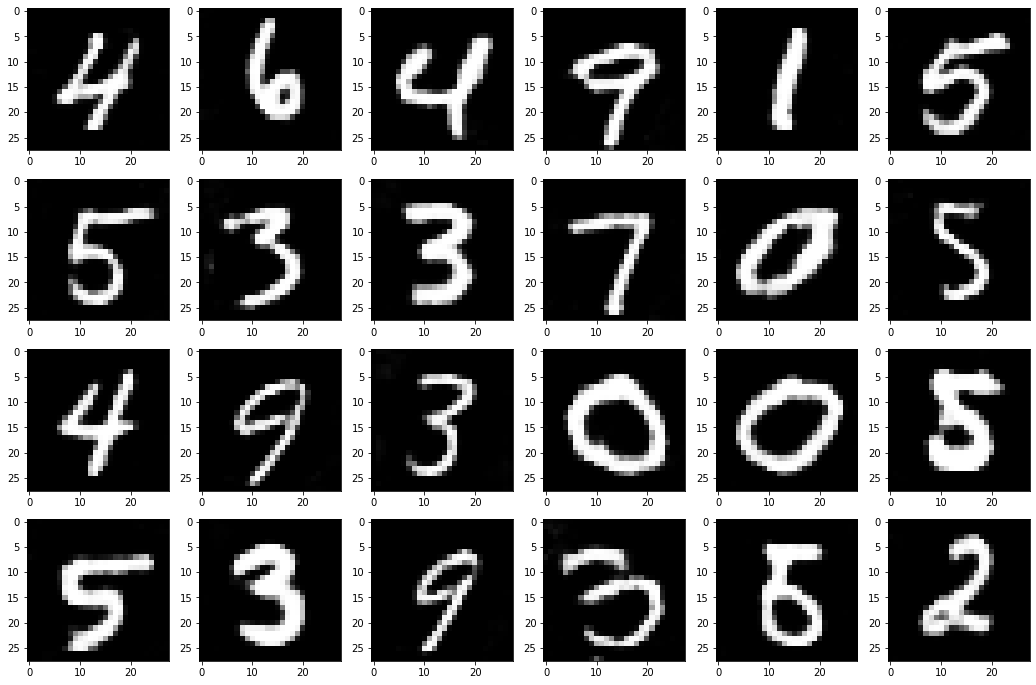

Epoch: 017: Gen Loss: 1.721, Disc Loss:0.479, IS: 2.210, IS_avr: 2.217
examples of generated images after 17 epochs


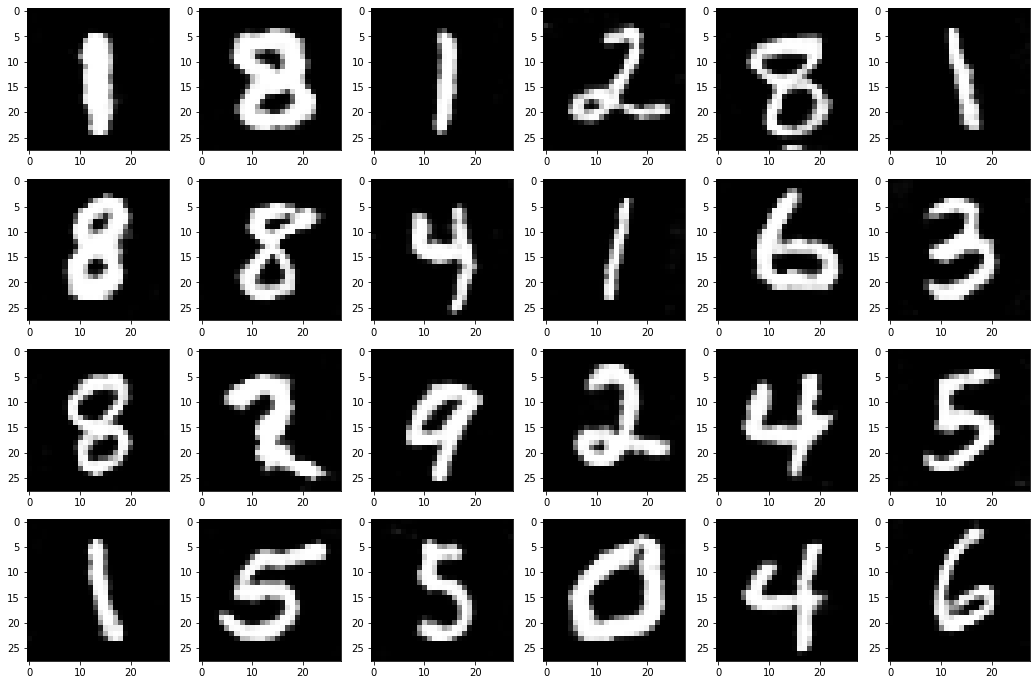

examples of generated images using average variables after 17 epochs


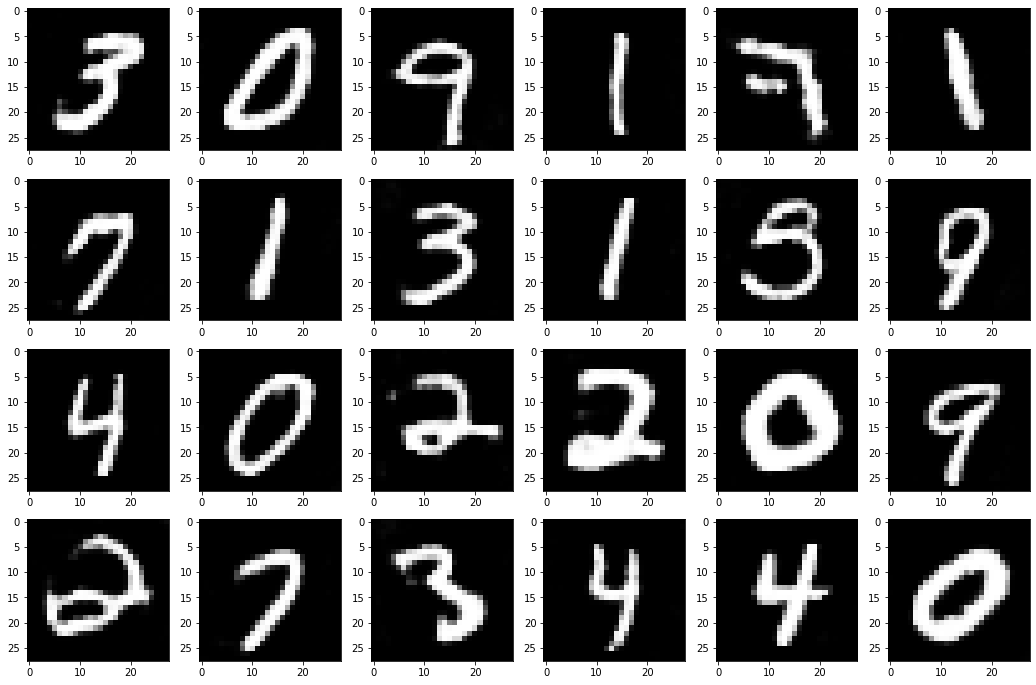

Epoch: 018: Gen Loss: 1.777, Disc Loss:0.471, IS: 2.214, IS_avr: 2.293
examples of generated images after 18 epochs


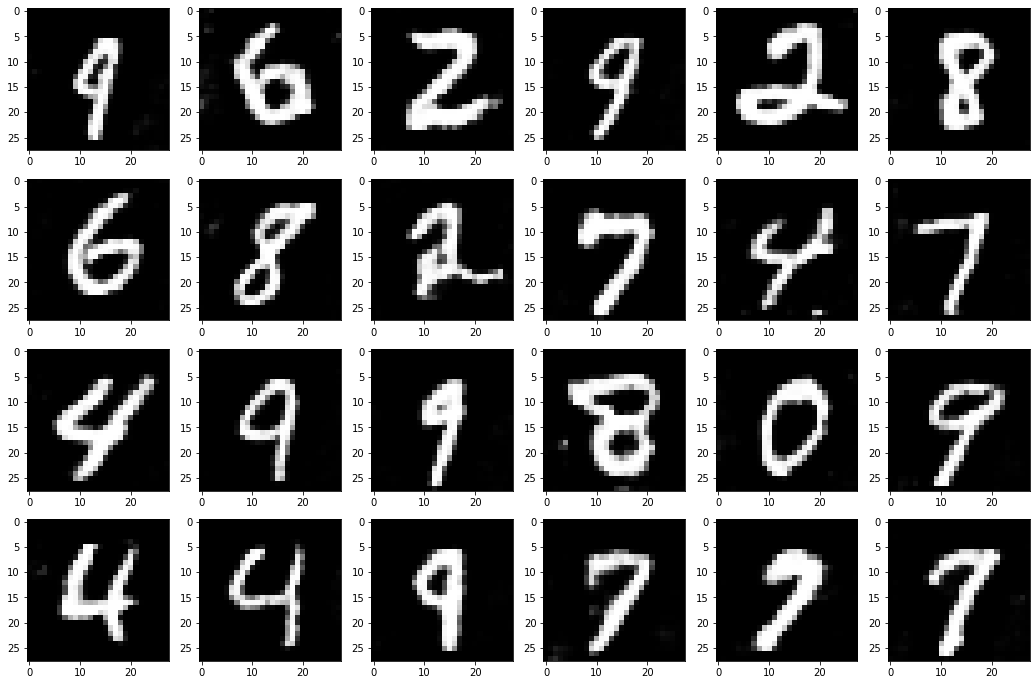

examples of generated images using average variables after 18 epochs


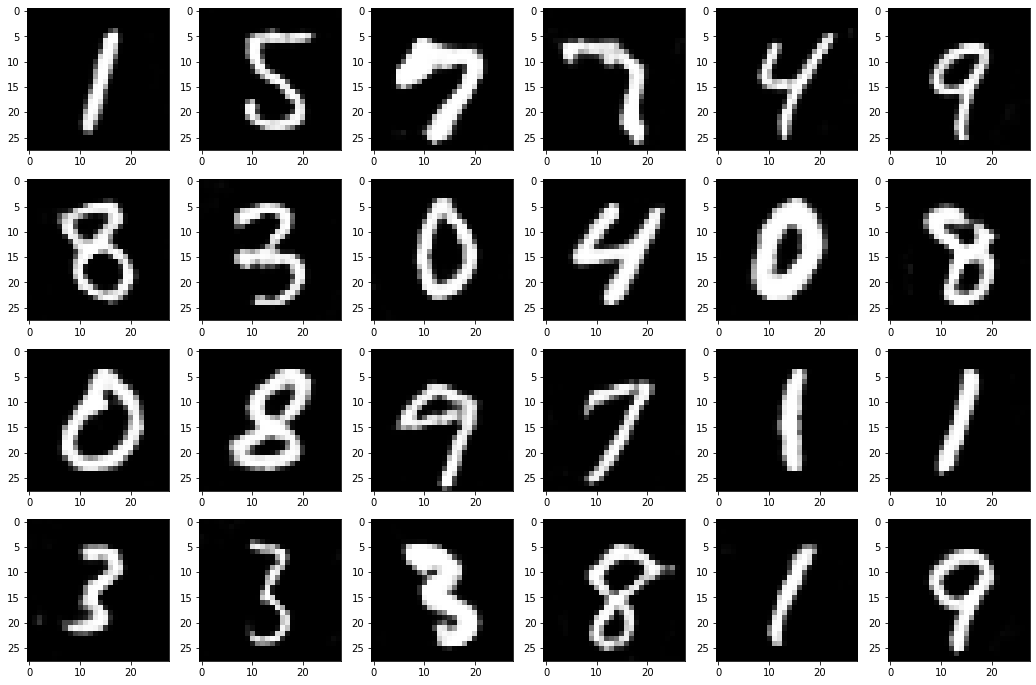

Epoch: 019: Gen Loss: 1.809, Disc Loss:0.465, IS: 2.199, IS_avr: 2.187
examples of generated images after 19 epochs


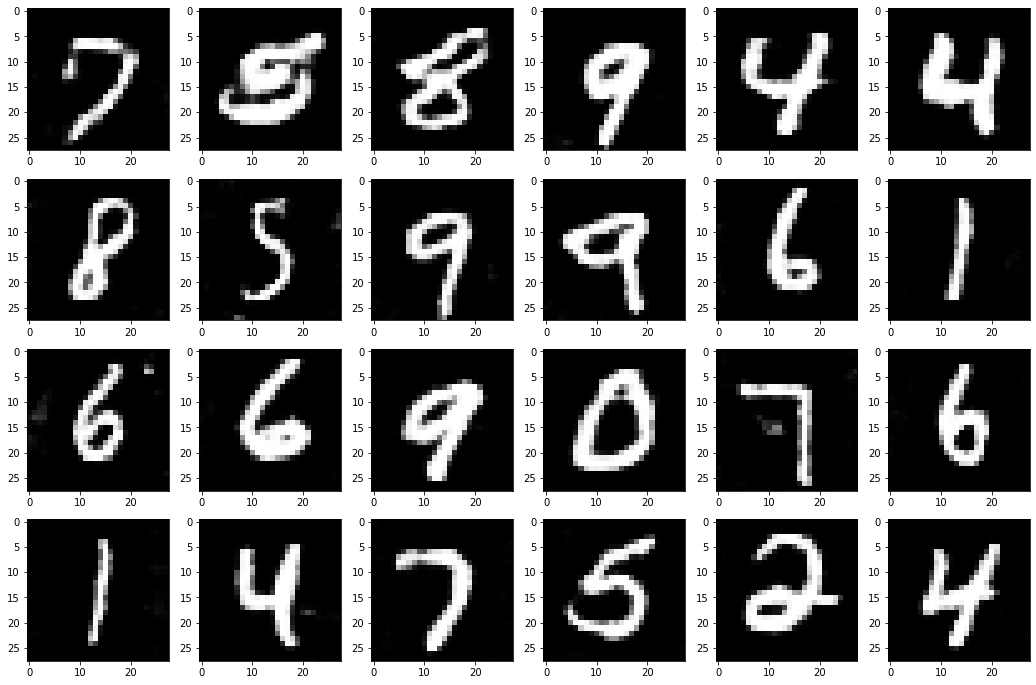

examples of generated images using average variables after 19 epochs


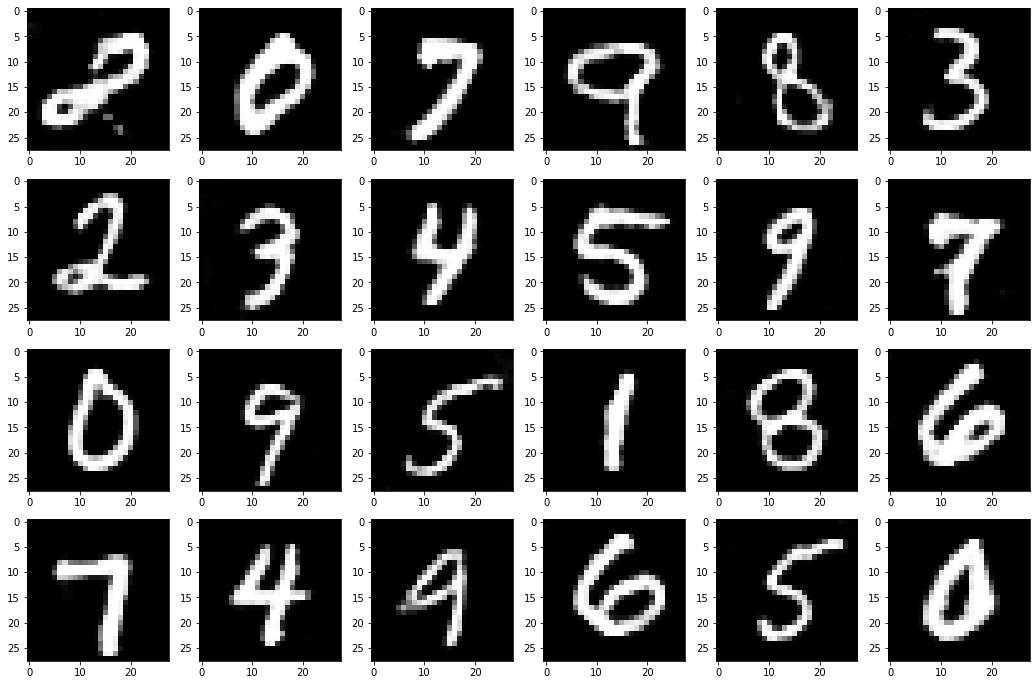

Epoch: 020: Gen Loss: 1.856, Disc Loss:0.456, IS: 2.190, IS_avr: 2.233
examples of generated images after 20 epochs


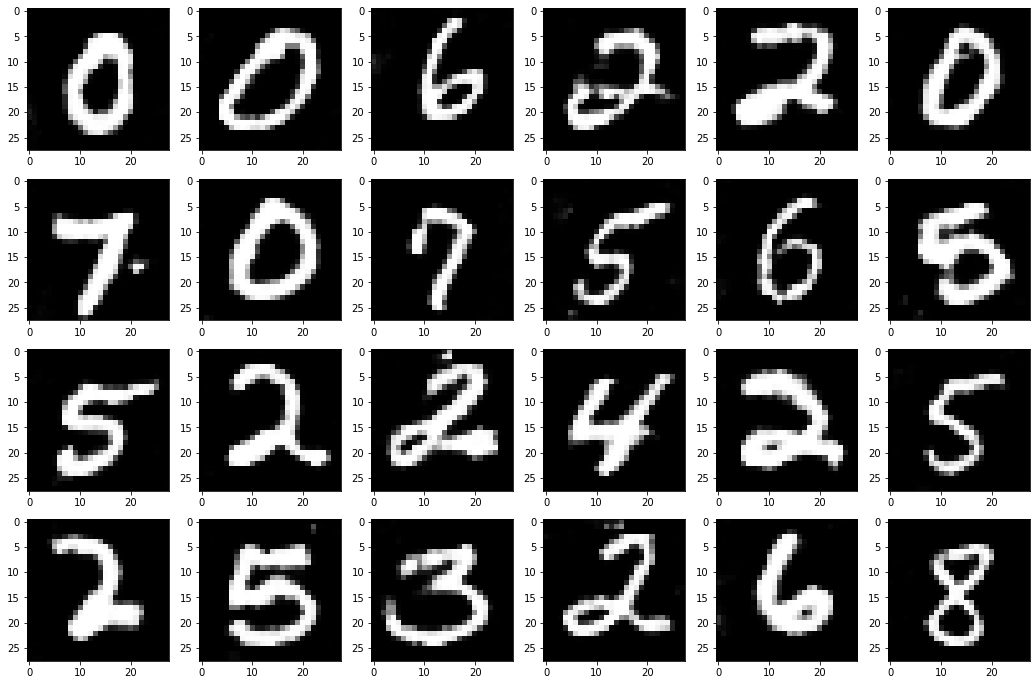

examples of generated images using average variables after 20 epochs


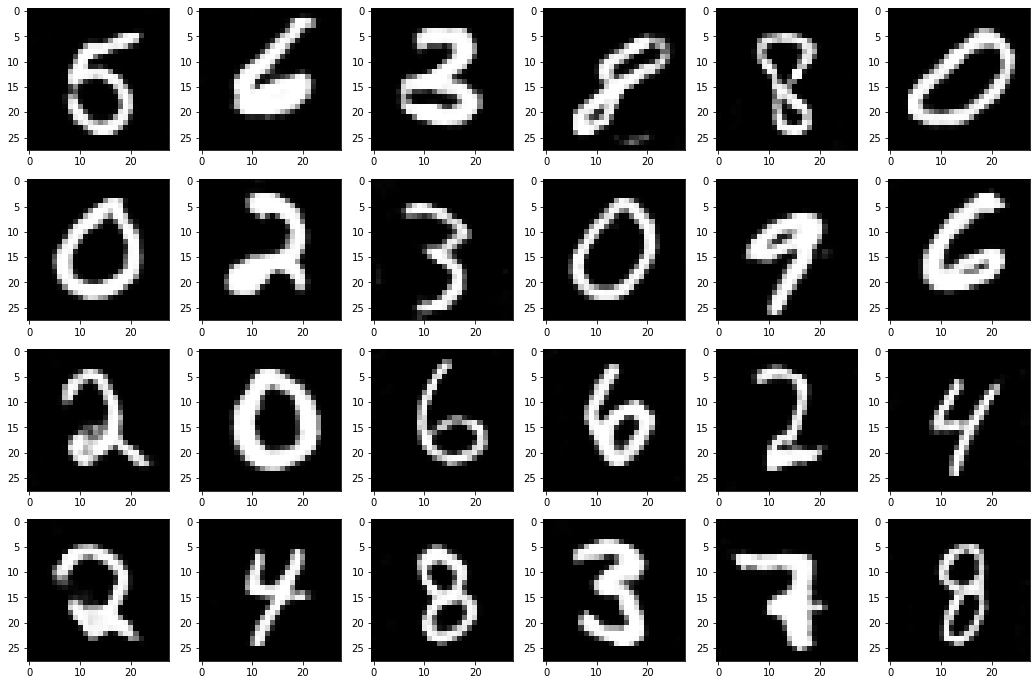

Epoch: 021: Gen Loss: 1.898, Disc Loss:0.452, IS: 2.166, IS_avr: 2.297
examples of generated images after 21 epochs


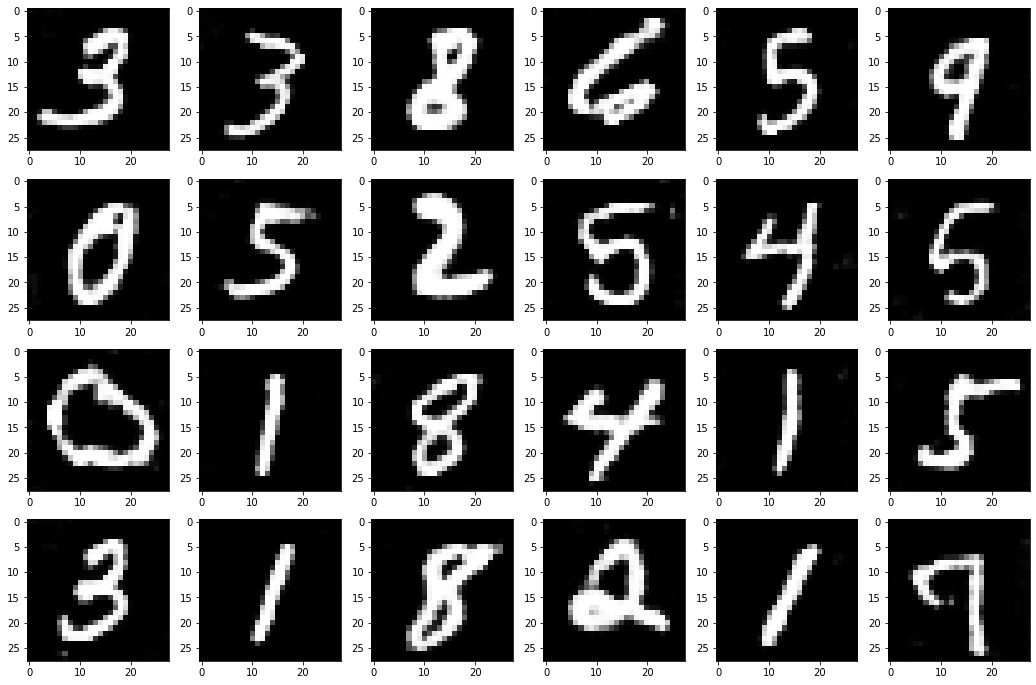

examples of generated images using average variables after 21 epochs


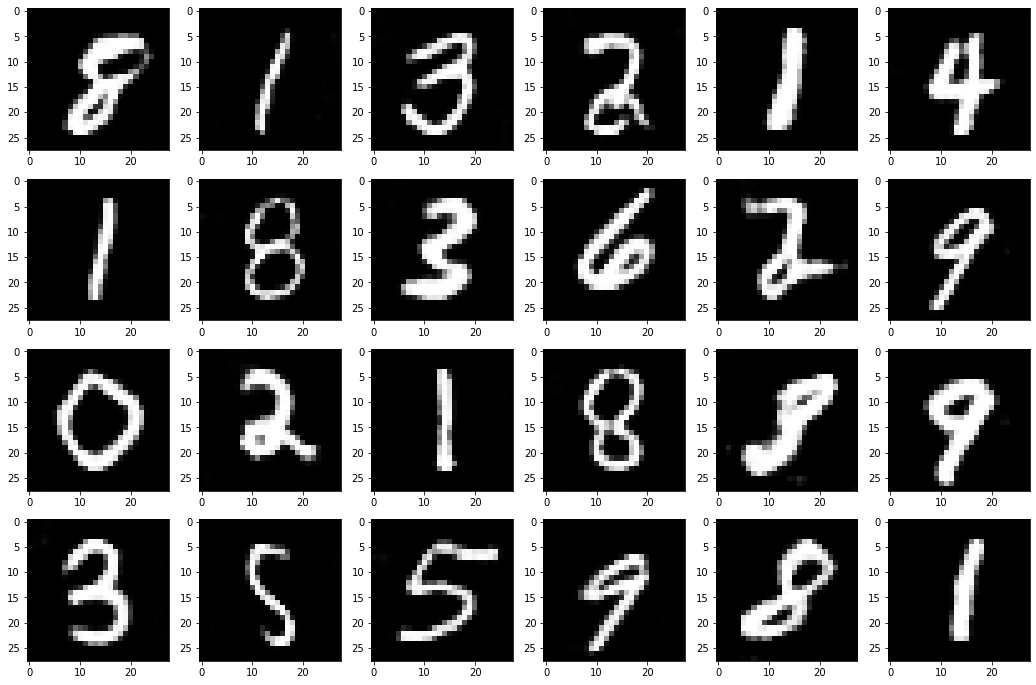

time: 798.9990230000001 sec


In [ ]:
cgan.use_averaging = True
t0 = time.clock()
cgan.train(epochs=10)
print('time:', time.clock() - t0, 'sec')

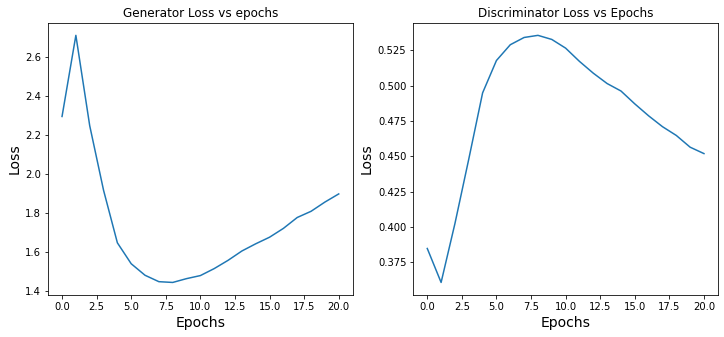

In [ ]:
cgan.draw_losses_per_epoch_graphic()

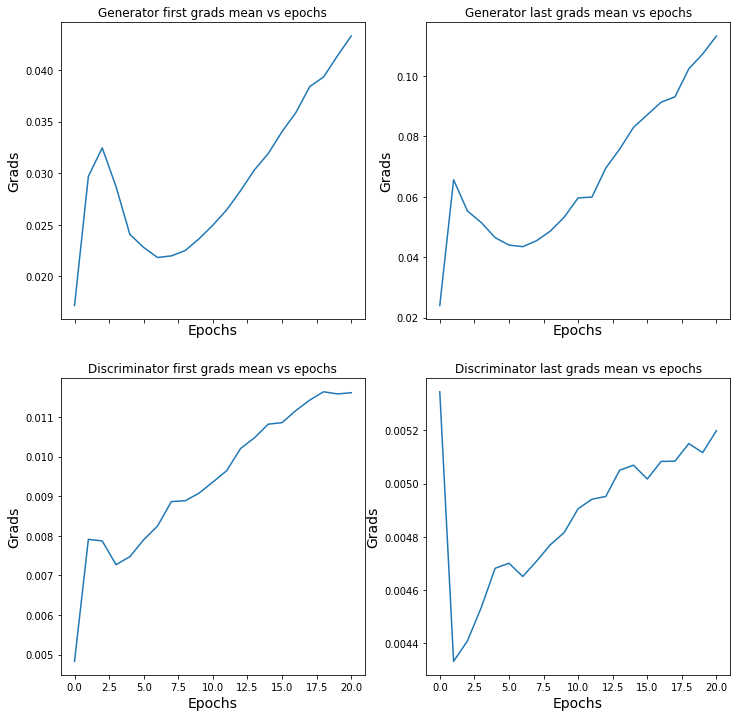

In [ ]:
cgan.draw_grads_per_epoch_graphic()

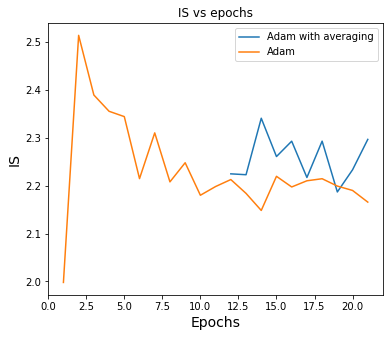

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))  
axes.set_xlabel("Epochs", fontsize=14)
axes.set_ylabel("IS", fontsize=14)
axes.set_title('IS vs epochs')
x1 = [x for x in (np.arange(10)+12)]
axes.plot(x1, cgan.IS_for_avr_per_epoch, label = 'Adam with averaging')
x2 = [x for x in (np.arange(21)+1)]
axes.plot(x2, cgan.IS_per_epoch, label = 'Adam')
axes.legend()
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


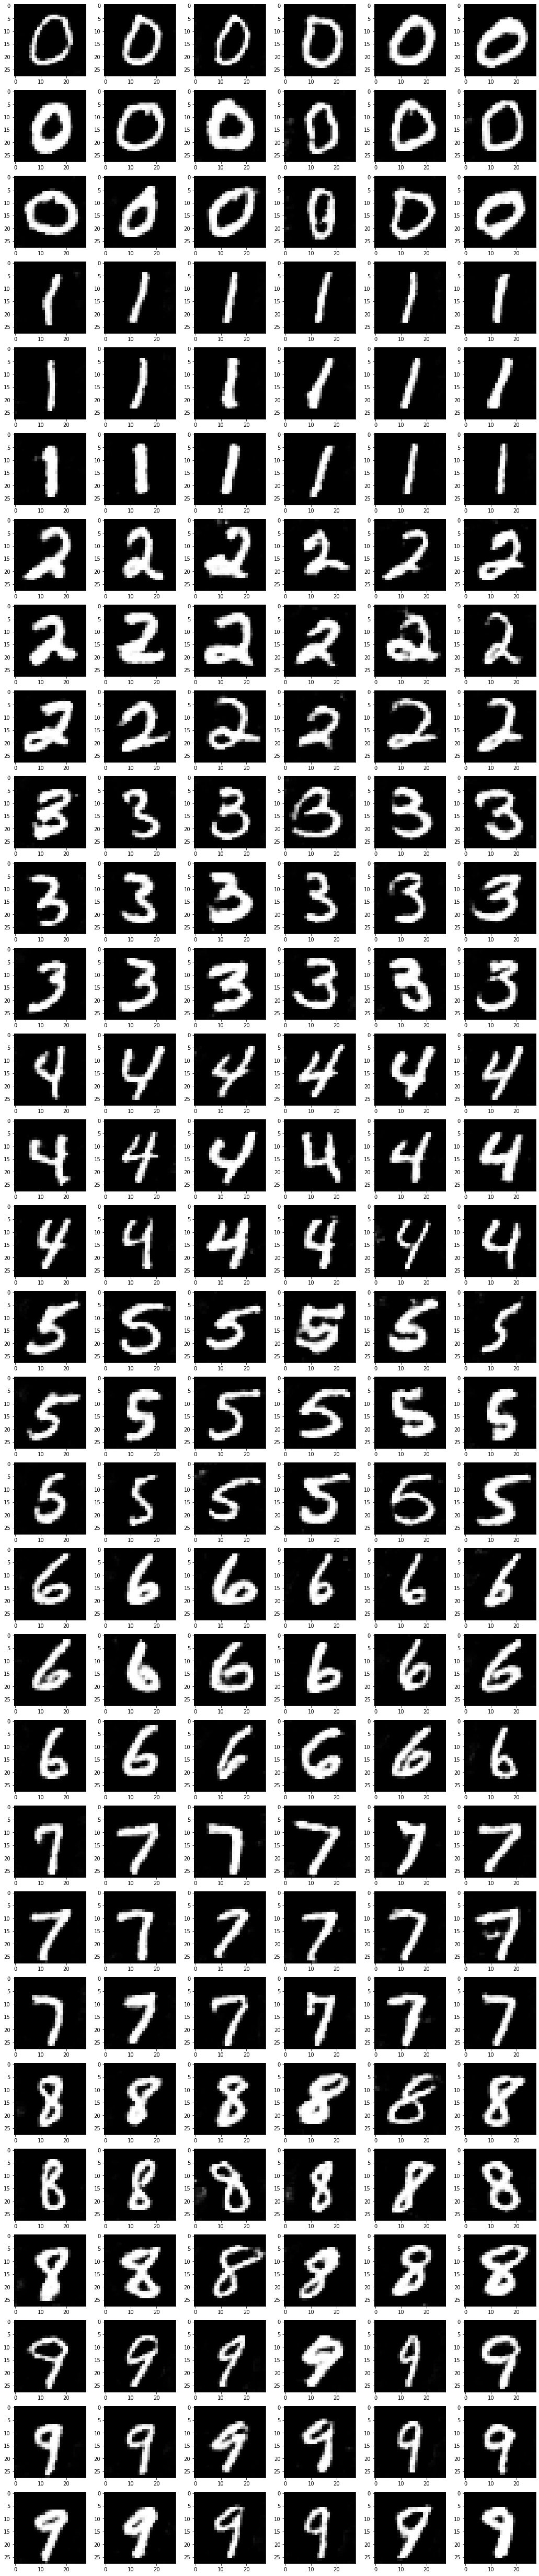

In [ ]:
arr = np.arange(10).reshape((10,1))
labels = np.tile(arr, [1,18])
labels = labels.flatten()
print(labels)

#without averaging
cgan.draw_generated_images(rows=30, cols=6, labels=labels)

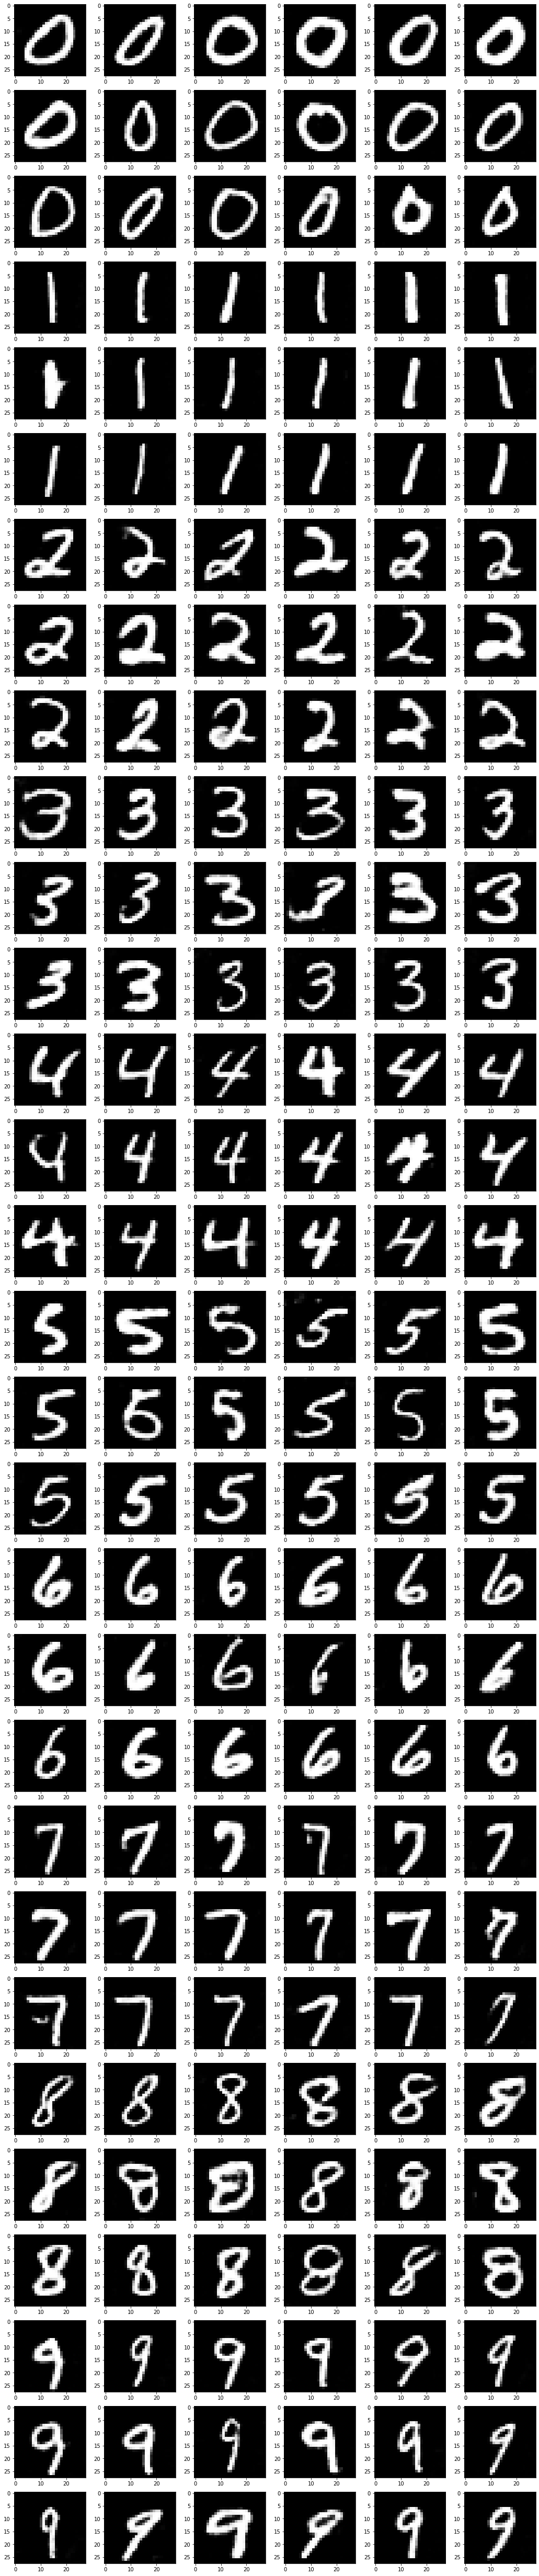

In [ ]:
#with averaging
cgan.draw_generated_images(rows=30, cols=6, labels=labels, is_from_gen_avr=True)

In [ ]:
cgan_uploaded = CGAN(ExtraAdam(learning_rate=0.0002, beta_1 = 0.5), x_train[:1000], y_train[:1000], batch_size=128, use_averaging=True)
cgan_uploaded.upload_from_file(epoch=6)


**Optimistic Adam**

Epoch: 001: Gen Loss: 1.811, Disc Loss:0.455, IS: 1.934
examples of generated images after 1 epochs


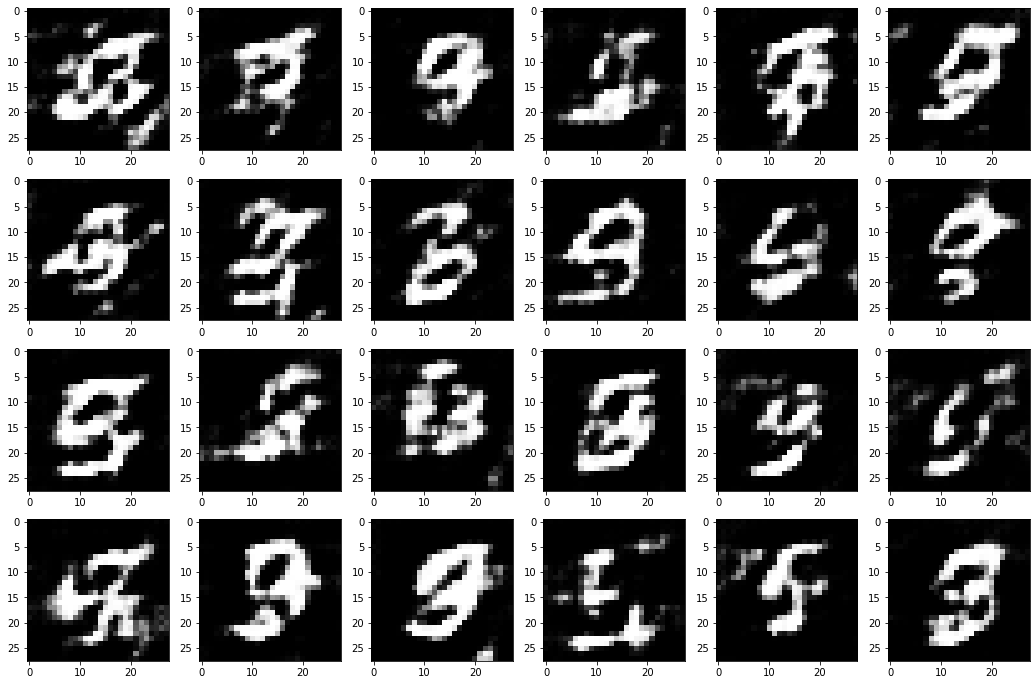

Epoch: 002: Gen Loss: 2.385, Disc Loss:0.391, IS: 2.385
examples of generated images after 2 epochs


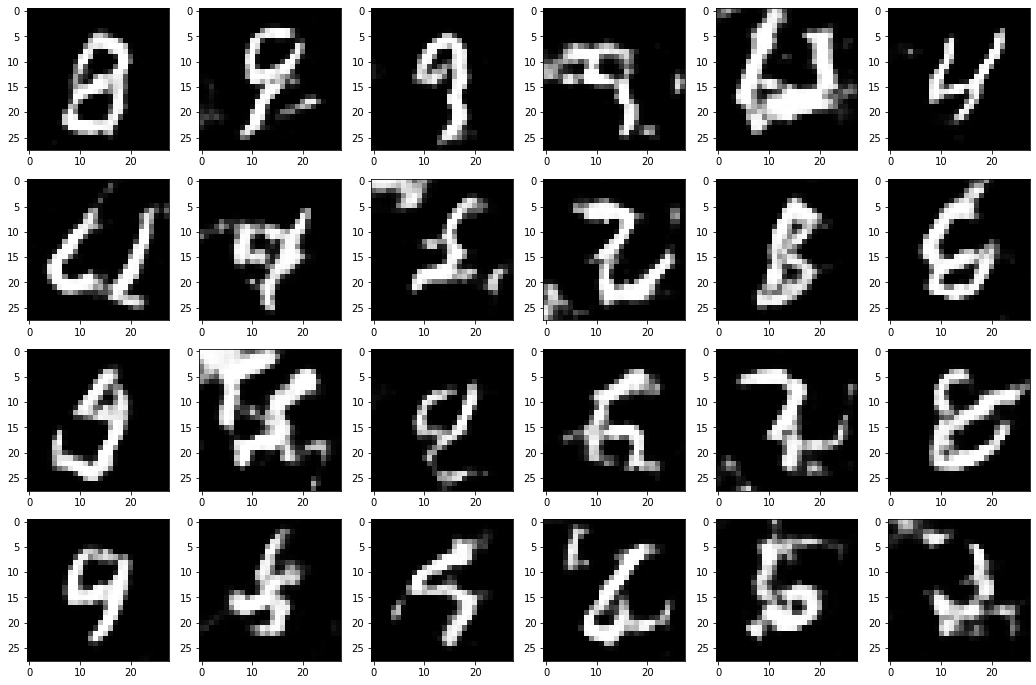

Epoch: 003: Gen Loss: 1.924, Disc Loss:0.450, IS: 2.435
examples of generated images after 3 epochs


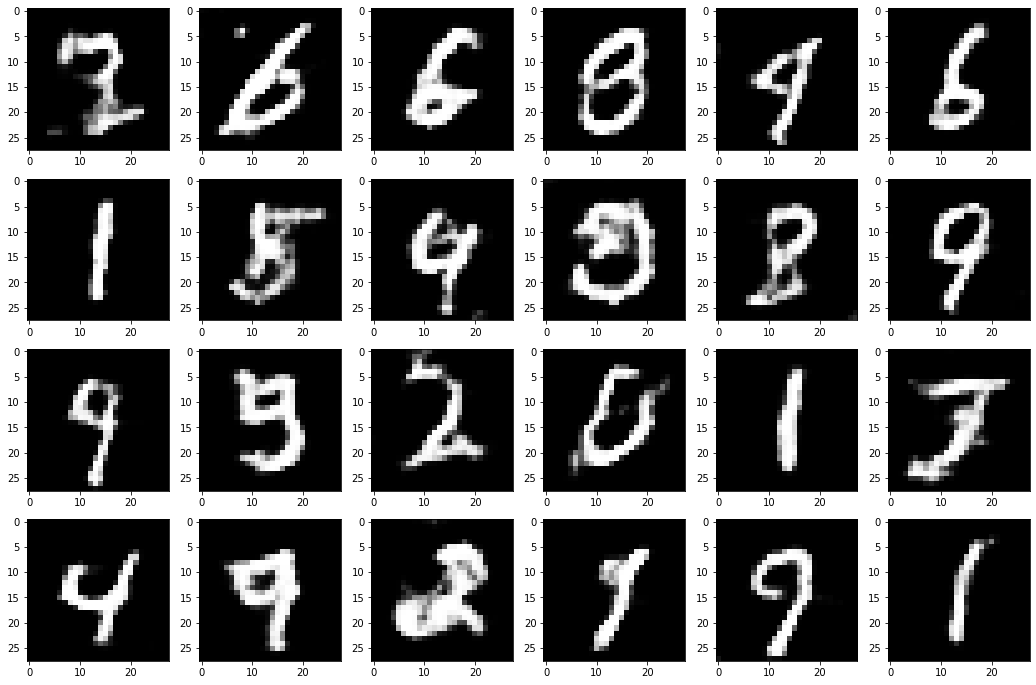

Epoch: 004: Gen Loss: 1.718, Disc Loss:0.478, IS: 2.577
examples of generated images after 4 epochs


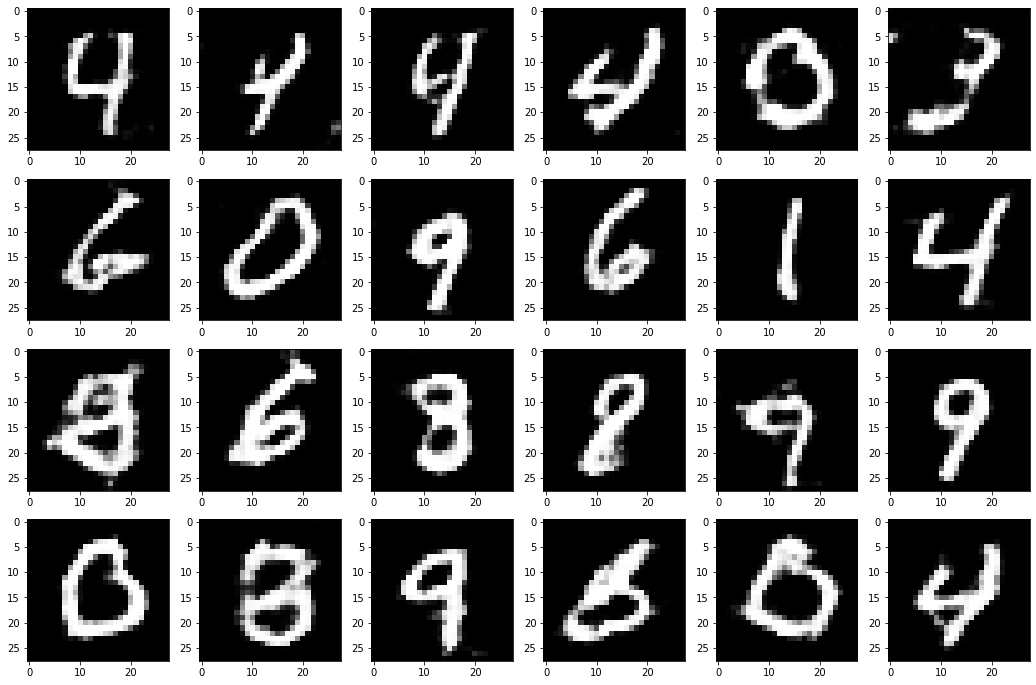

Epoch: 005: Gen Loss: 1.505, Disc Loss:0.520, IS: 2.487
examples of generated images after 5 epochs


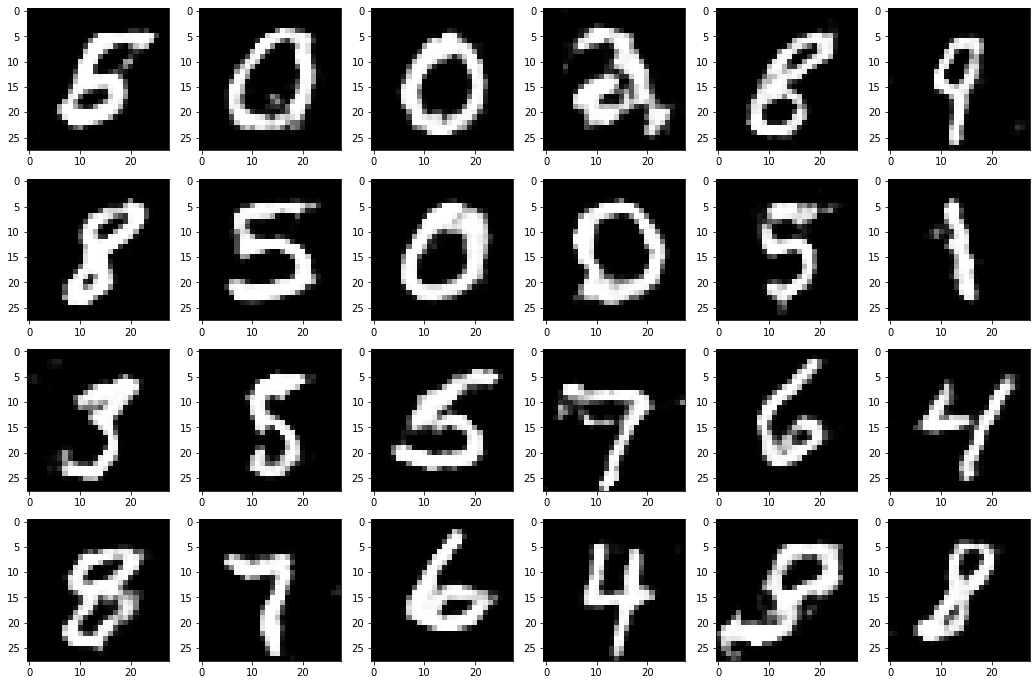

Epoch: 006: Gen Loss: 1.363, Disc Loss:0.551, IS: 2.355
examples of generated images after 6 epochs


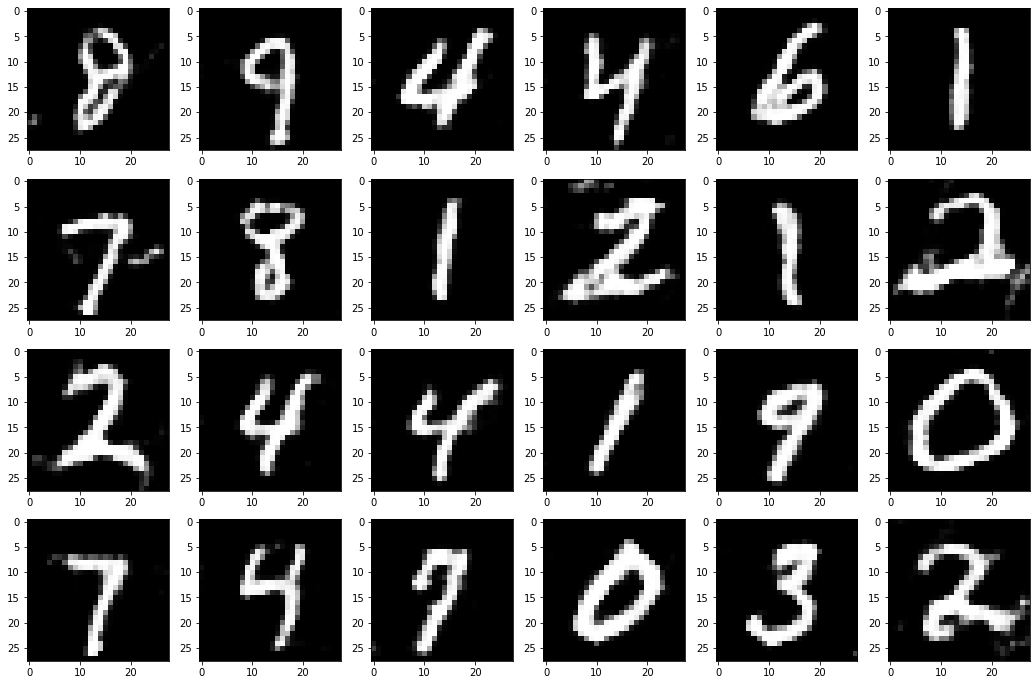

Epoch: 007: Gen Loss: 1.304, Disc Loss:0.563, IS: 2.351
examples of generated images after 7 epochs


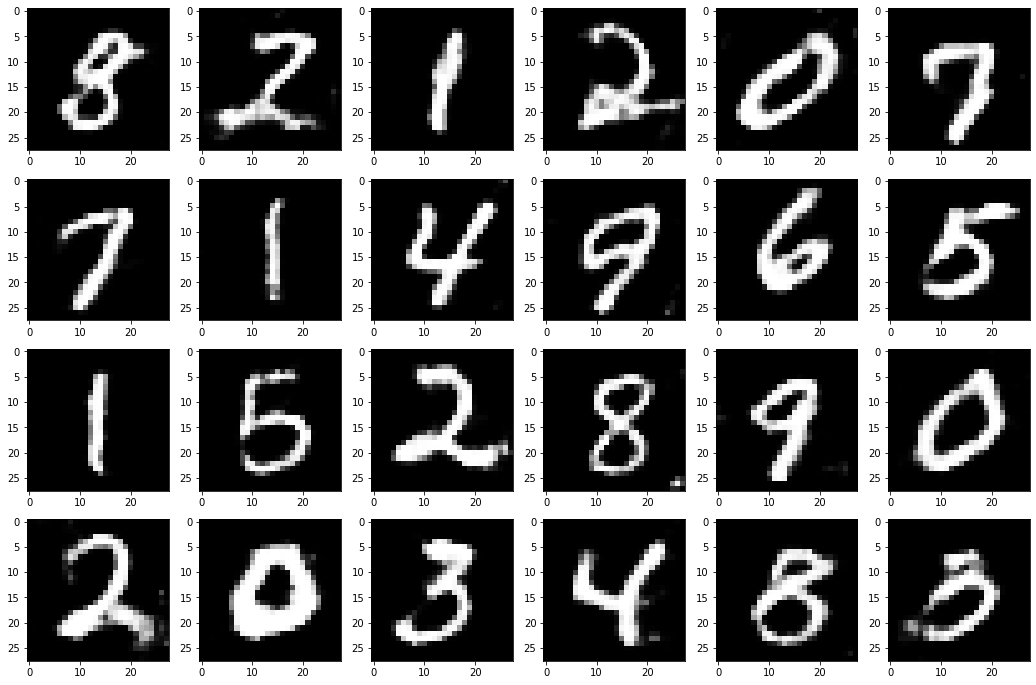

Epoch: 008: Gen Loss: 1.283, Disc Loss:0.567, IS: 2.323
examples of generated images after 8 epochs


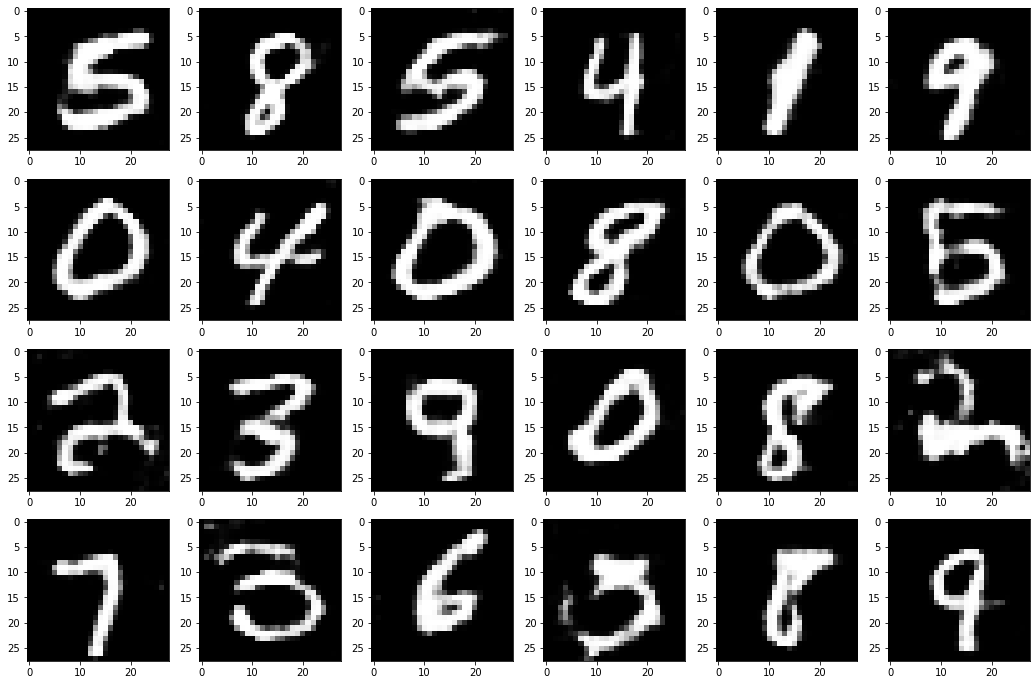

Epoch: 009: Gen Loss: 1.274, Disc Loss:0.569, IS: 2.260
examples of generated images after 9 epochs


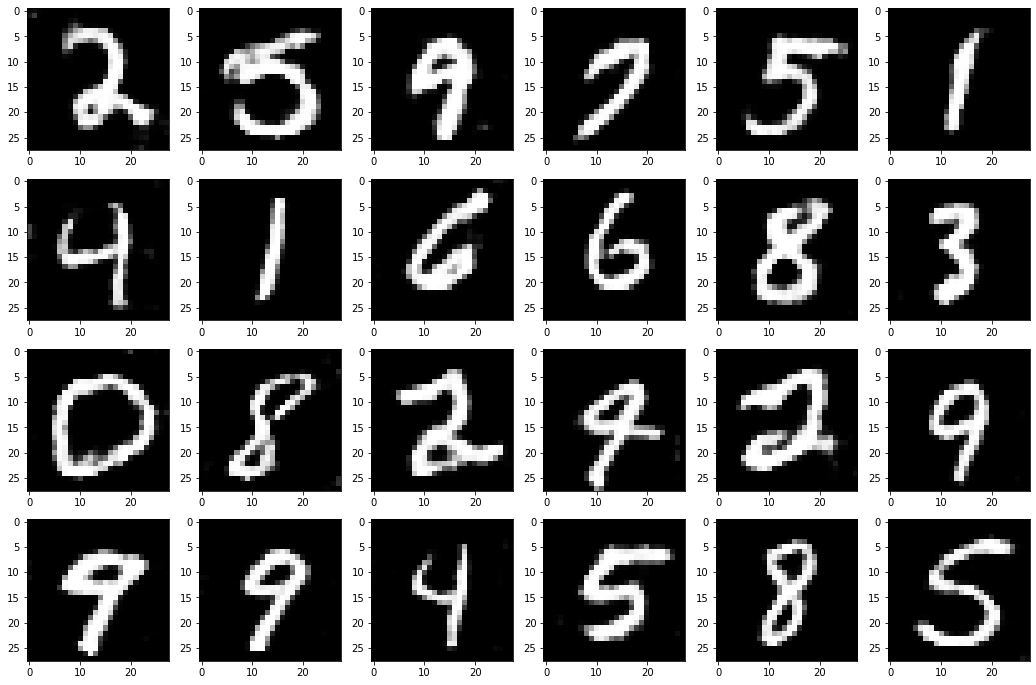

Epoch: 010: Gen Loss: 1.279, Disc Loss:0.568, IS: 2.215
examples of generated images after 10 epochs


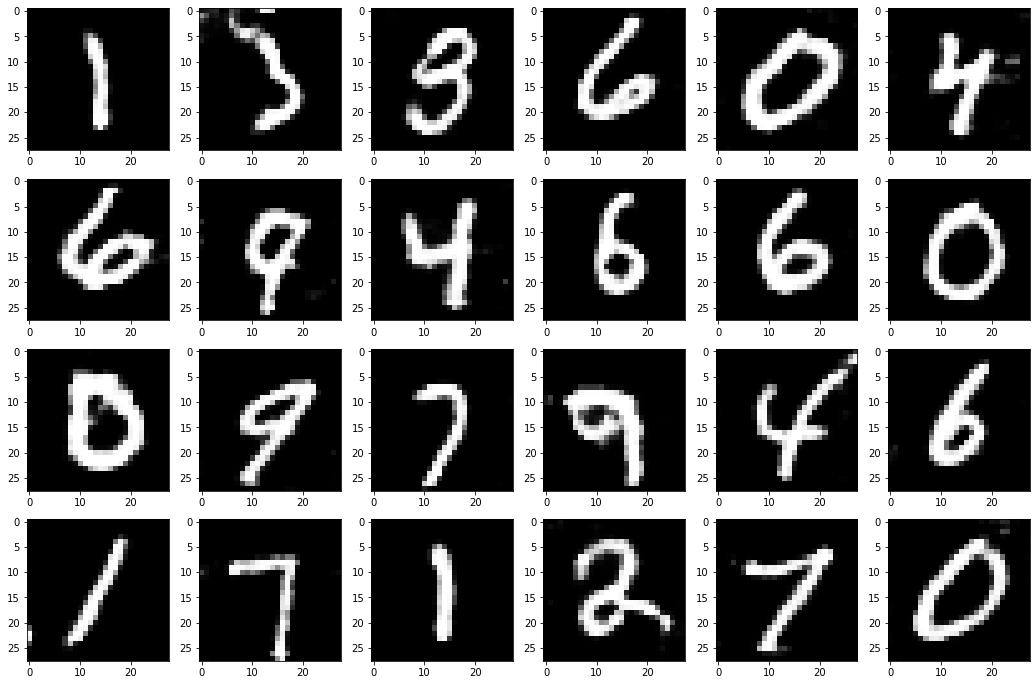

Epoch: 011: Gen Loss: 1.282, Disc Loss:0.567, IS: 2.291
examples of generated images after 11 epochs


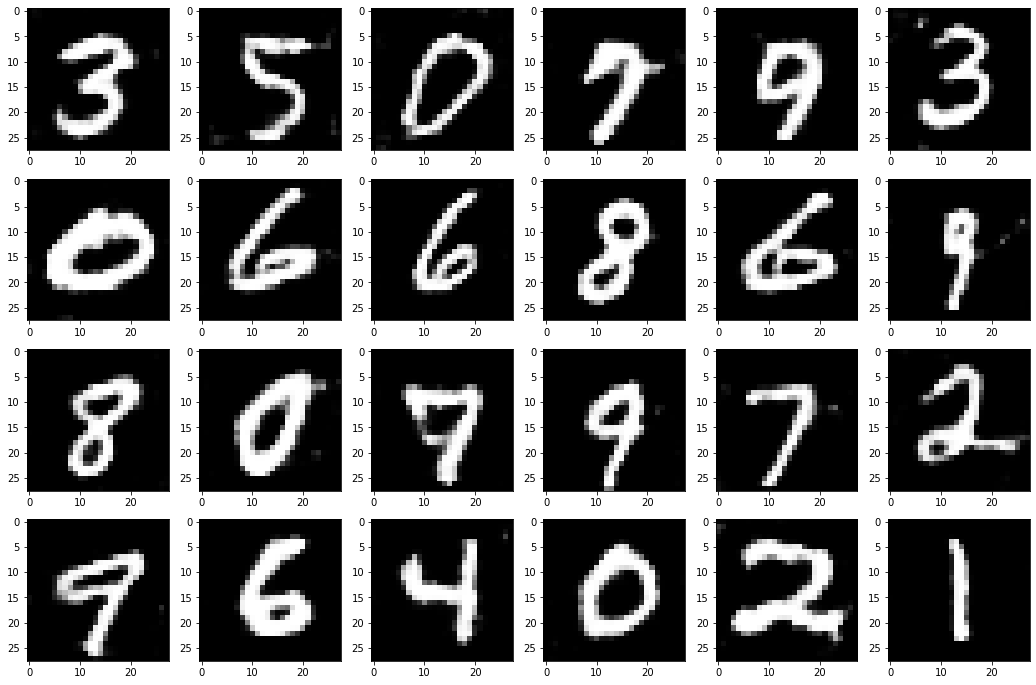

time: 934.3556470000001 sec


In [ ]:
# Importent: remove tf.function decorators from CGAN class!
cgan = CGAN(OptimisticAdam(learning_rate=0.0002, beta_1=0.5), x_train, 
           y_train, batch_size=64, use_averaging=False,
            path='/content/drive/My Drive/Univ/Final models/Saved models/CGAN OptimisticAdam/')
t0 = time.clock()
cgan.train(epochs=11)
print('time:', time.clock() - t0, 'sec')

Epoch: 012: Gen Loss: 1.294, Disc Loss:0.564, IS: 2.344, IS_avr: 2.303
examples of generated images after 12 epochs


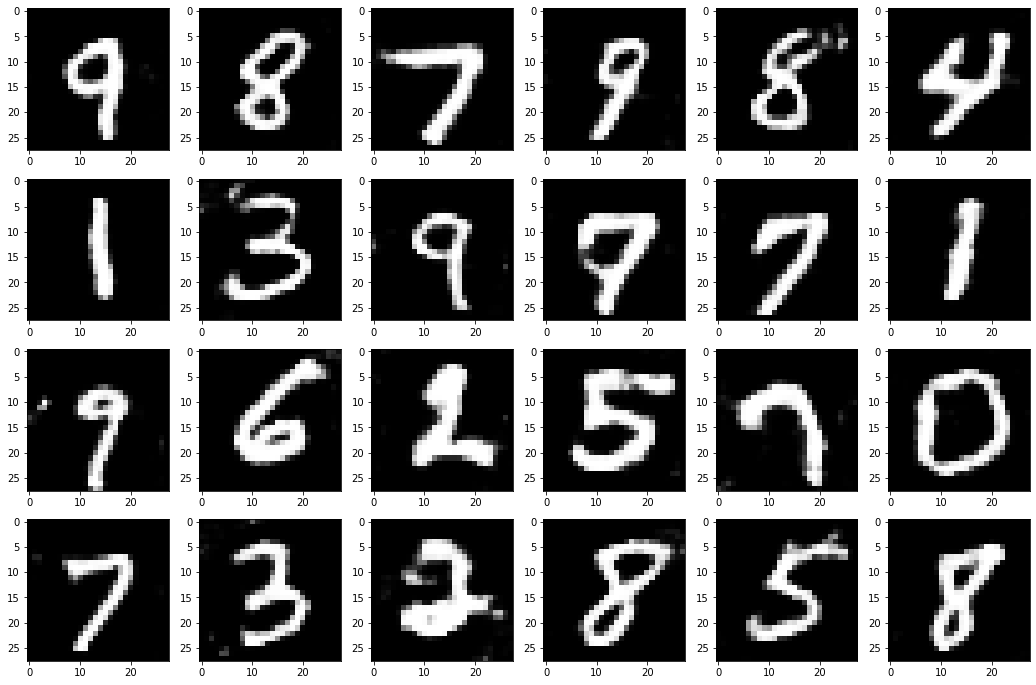

examples of generated images using average variables after 12 epochs


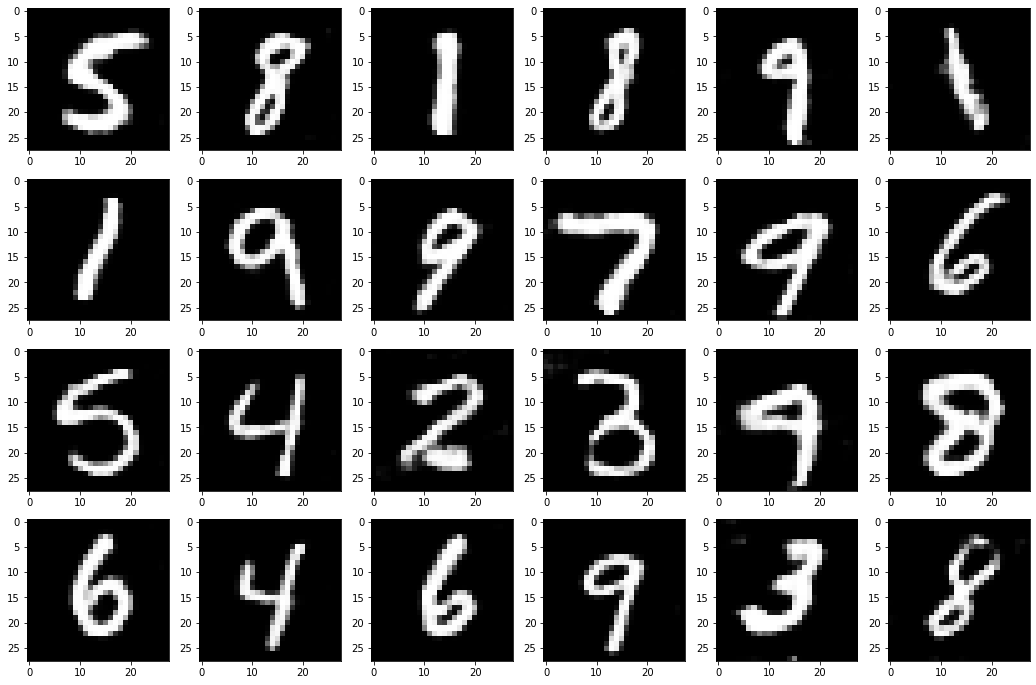

Epoch: 013: Gen Loss: 1.306, Disc Loss:0.561, IS: 2.220, IS_avr: 2.286
examples of generated images after 13 epochs


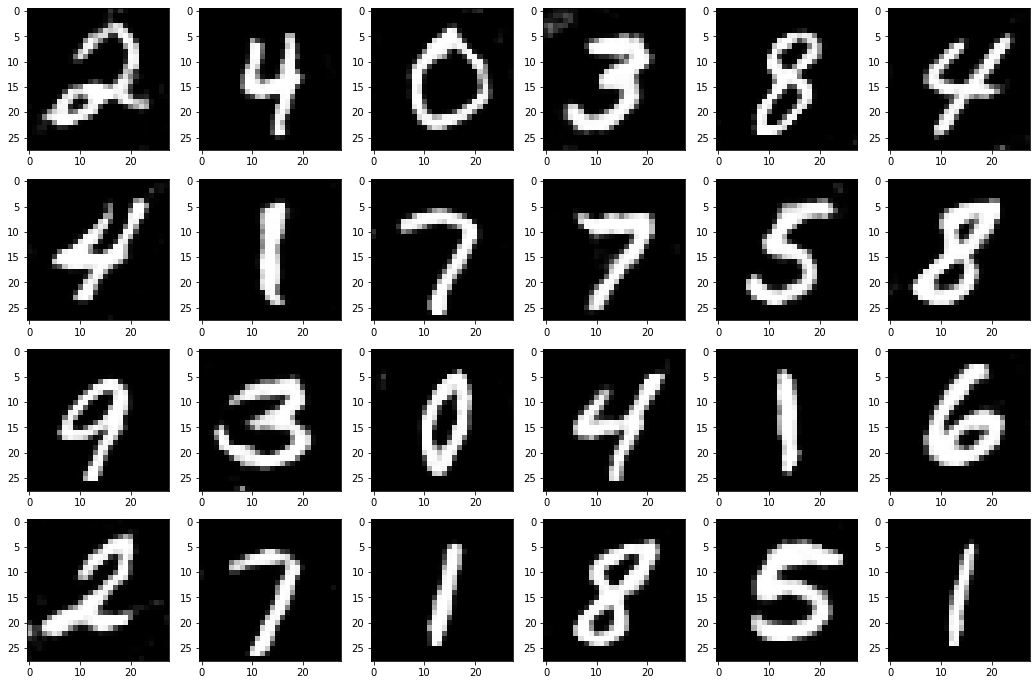

examples of generated images using average variables after 13 epochs


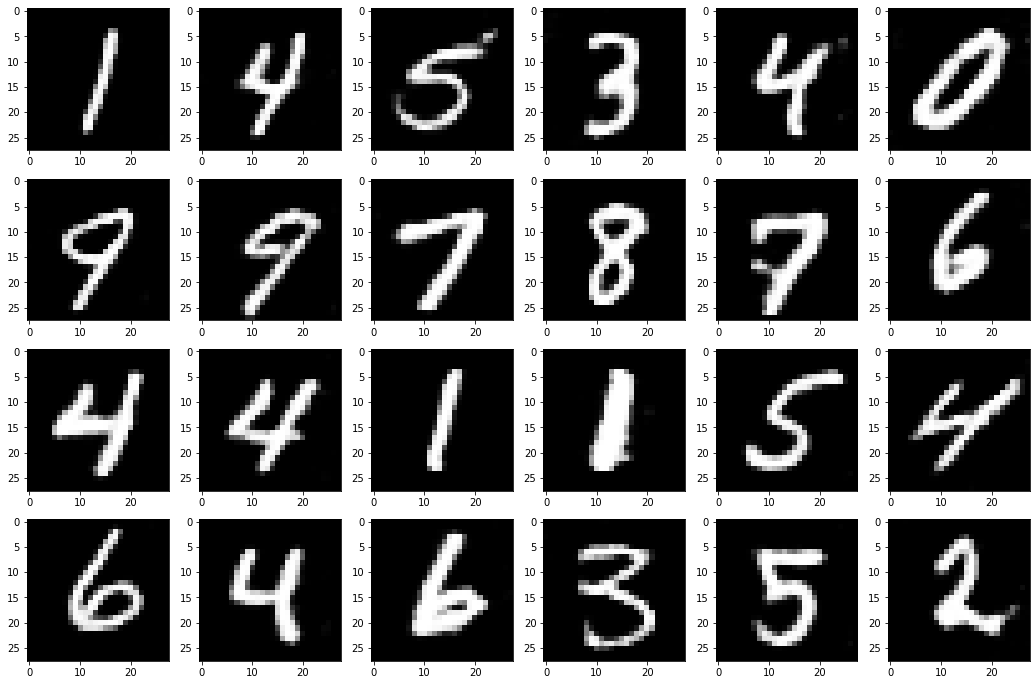

Epoch: 014: Gen Loss: 1.324, Disc Loss:0.557, IS: 2.357, IS_avr: 2.288
examples of generated images after 14 epochs


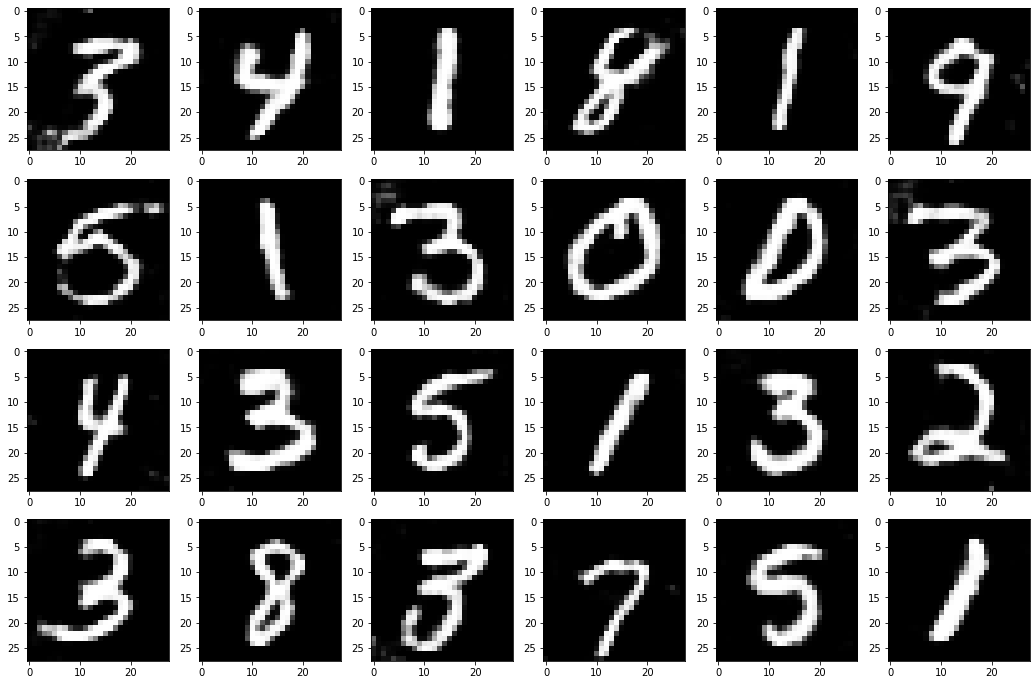

examples of generated images using average variables after 14 epochs


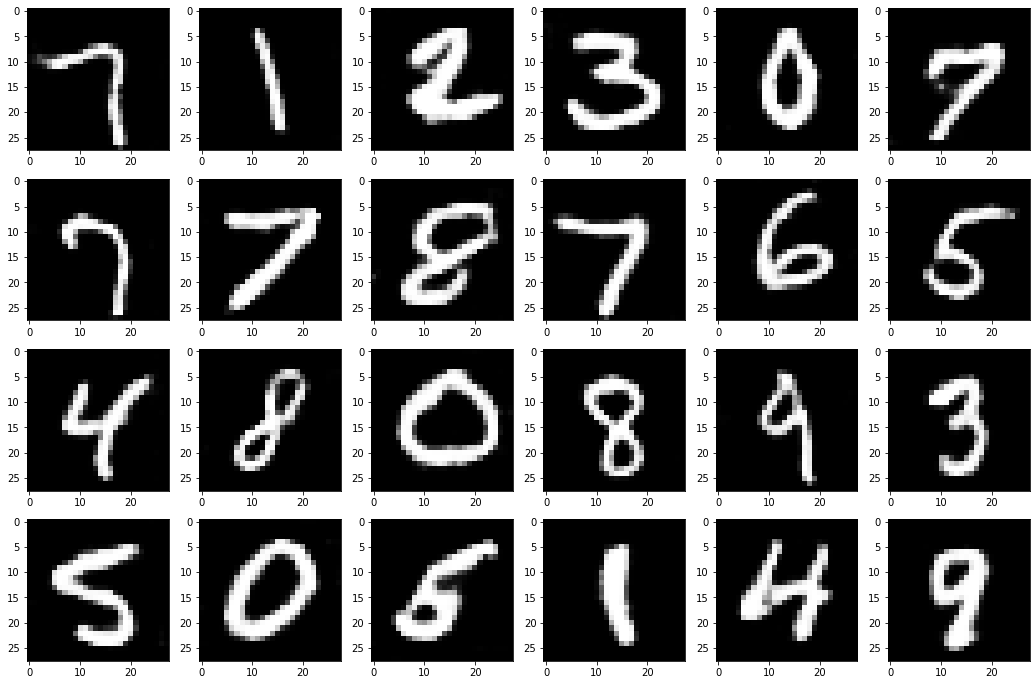

Epoch: 015: Gen Loss: 1.350, Disc Loss:0.550, IS: 2.277, IS_avr: 2.362
examples of generated images after 15 epochs


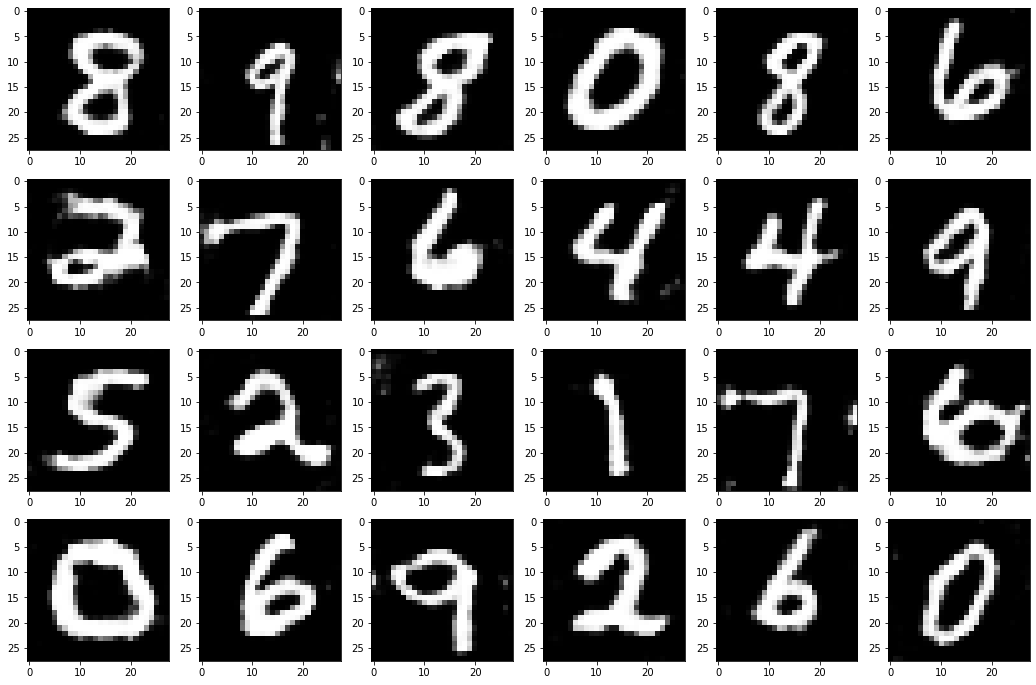

examples of generated images using average variables after 15 epochs


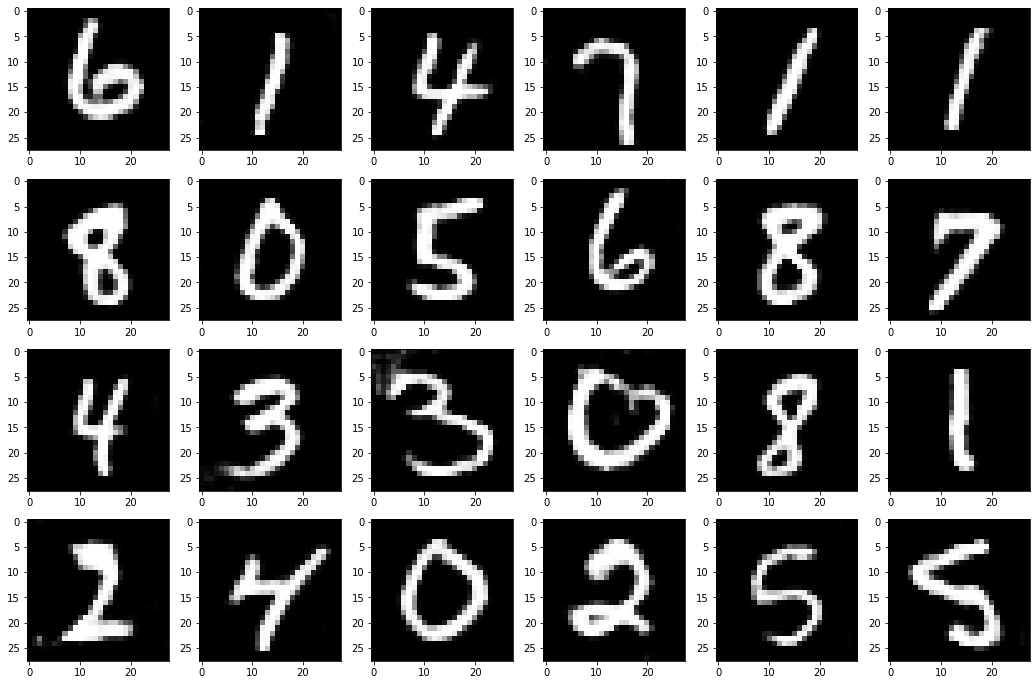

Epoch: 016: Gen Loss: 1.372, Disc Loss:0.545, IS: 2.309, IS_avr: 2.317
examples of generated images after 16 epochs


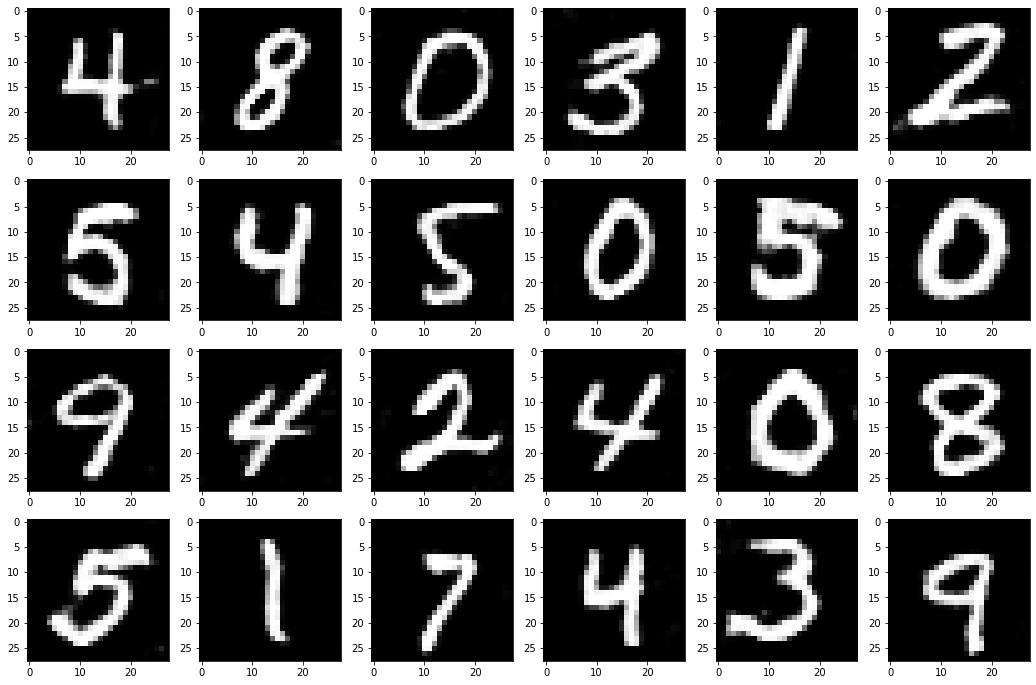

examples of generated images using average variables after 16 epochs


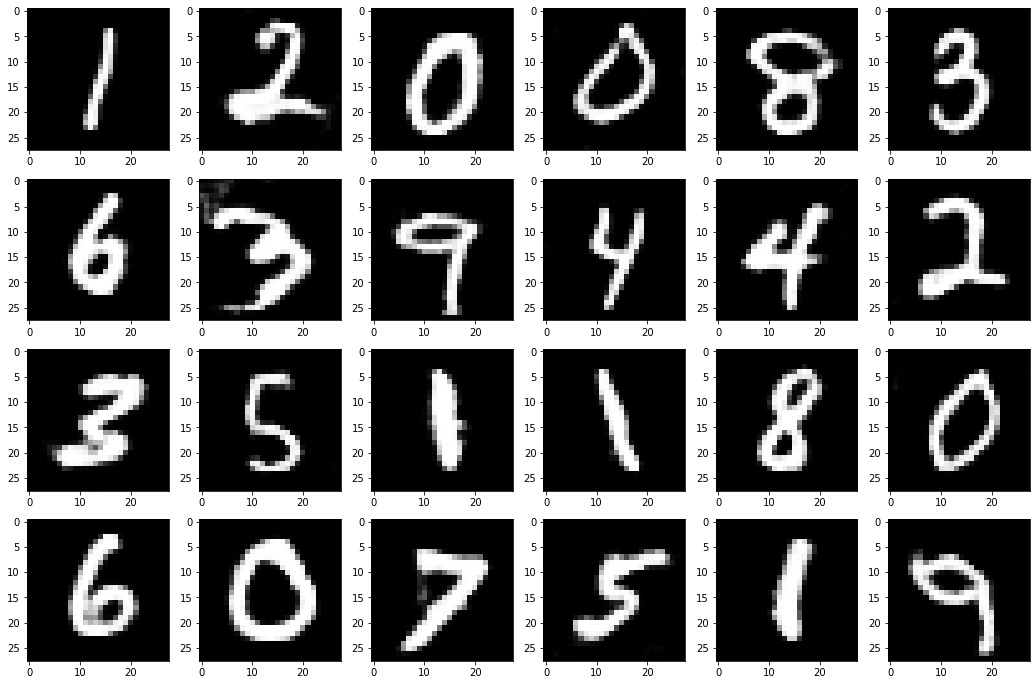

Epoch: 017: Gen Loss: 1.402, Disc Loss:0.539, IS: 2.302, IS_avr: 2.331
examples of generated images after 17 epochs


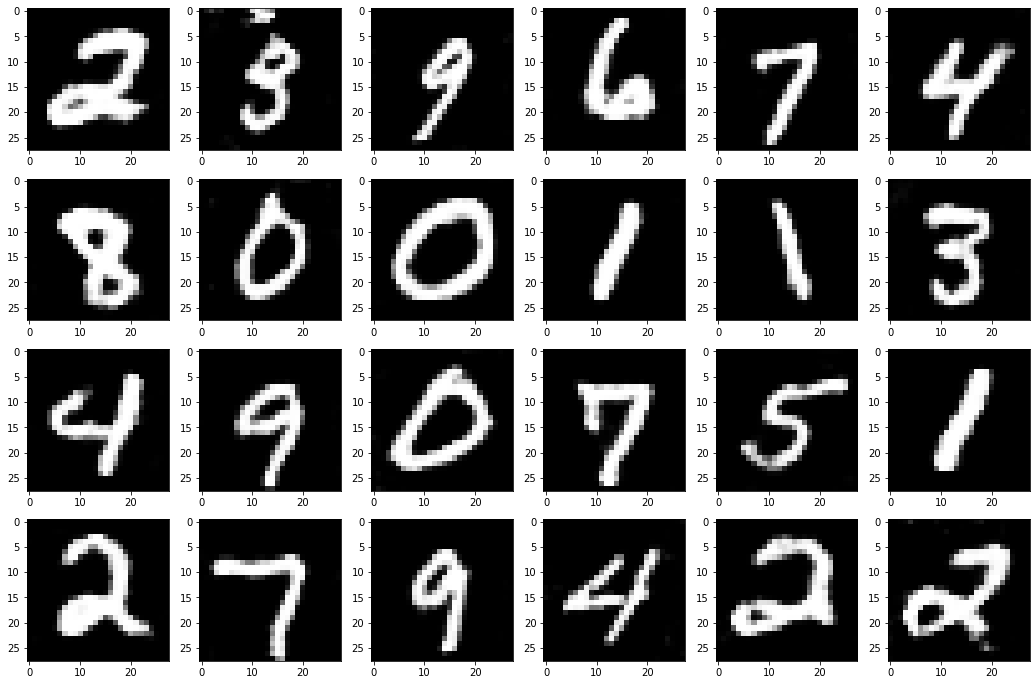

examples of generated images using average variables after 17 epochs


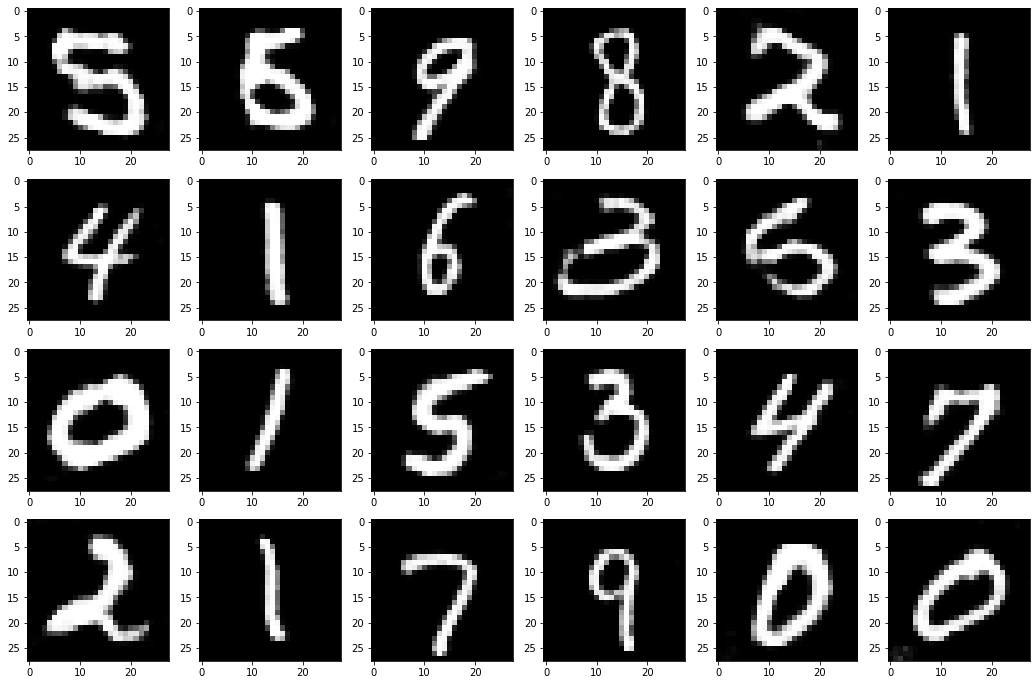

Epoch: 018: Gen Loss: 1.433, Disc Loss:0.532, IS: 2.275, IS_avr: 2.283
examples of generated images after 18 epochs


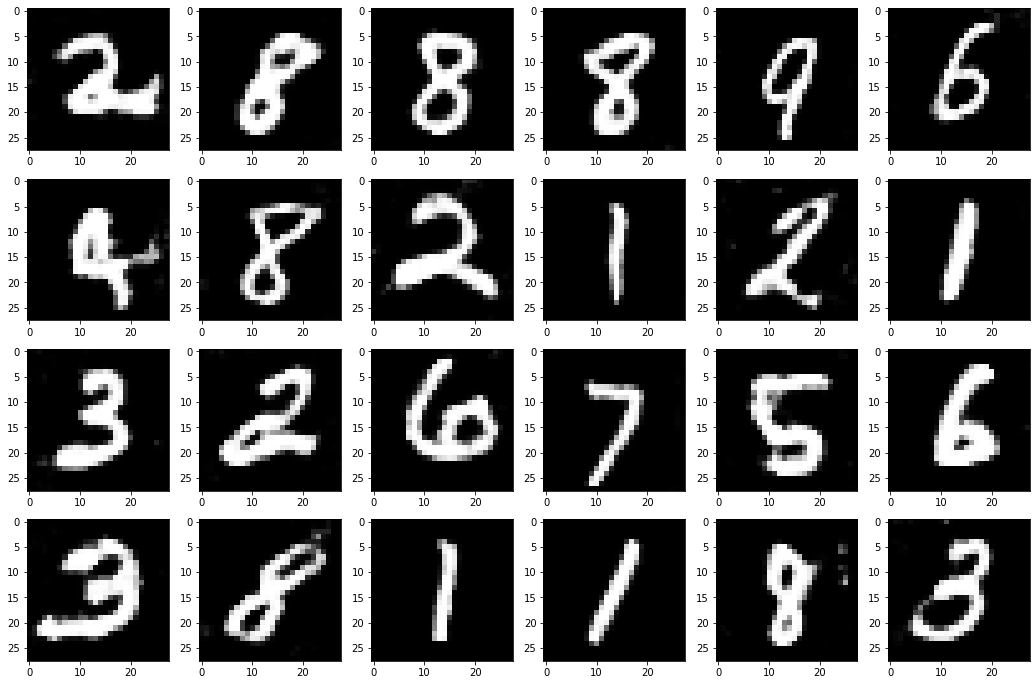

examples of generated images using average variables after 18 epochs


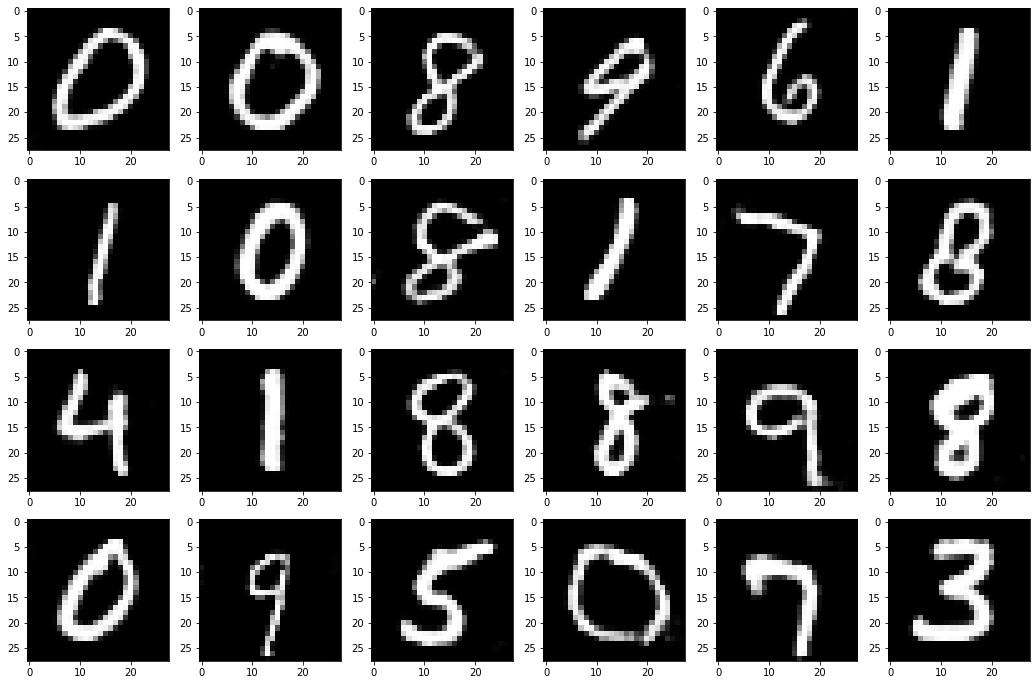

Epoch: 019: Gen Loss: 1.459, Disc Loss:0.528, IS: 2.228, IS_avr: 2.373
examples of generated images after 19 epochs


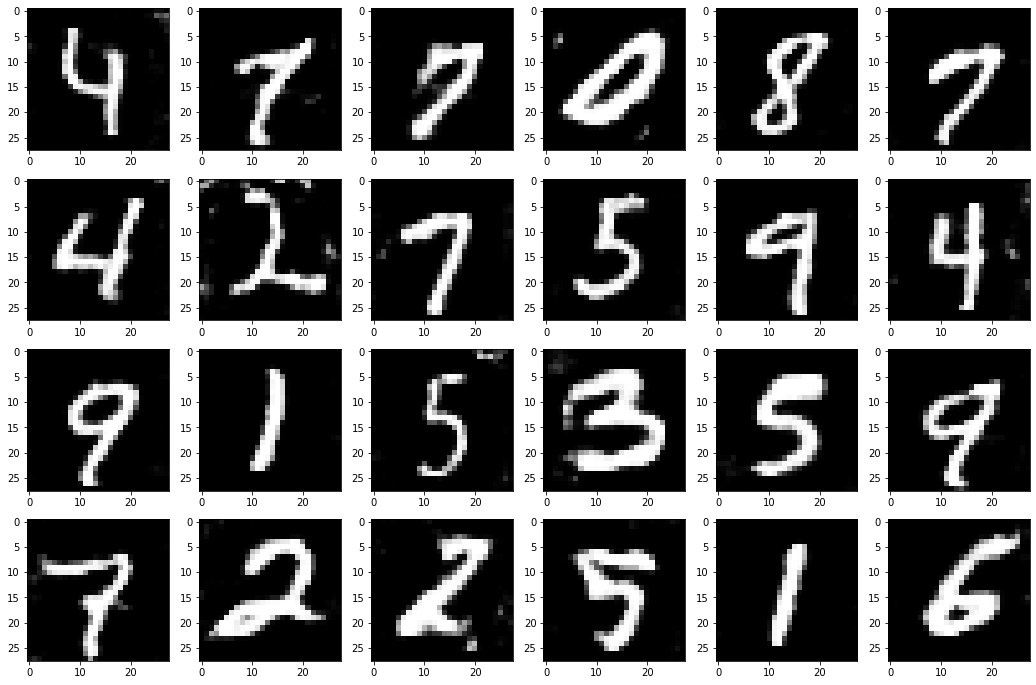

examples of generated images using average variables after 19 epochs


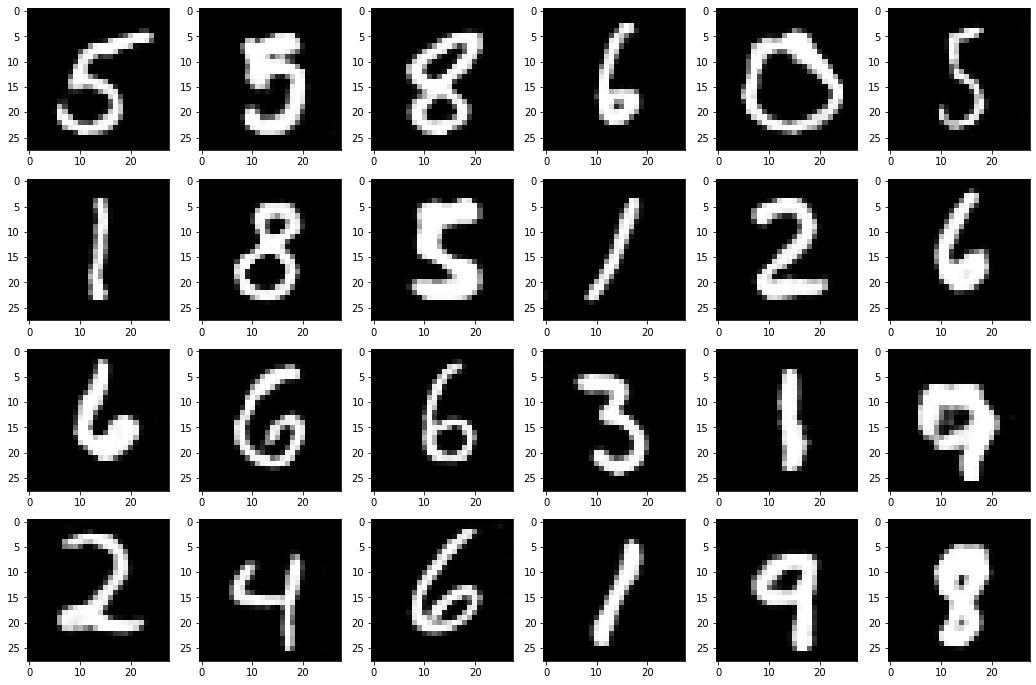

Epoch: 020: Gen Loss: 1.480, Disc Loss:0.522, IS: 2.148, IS_avr: 2.375
examples of generated images after 20 epochs


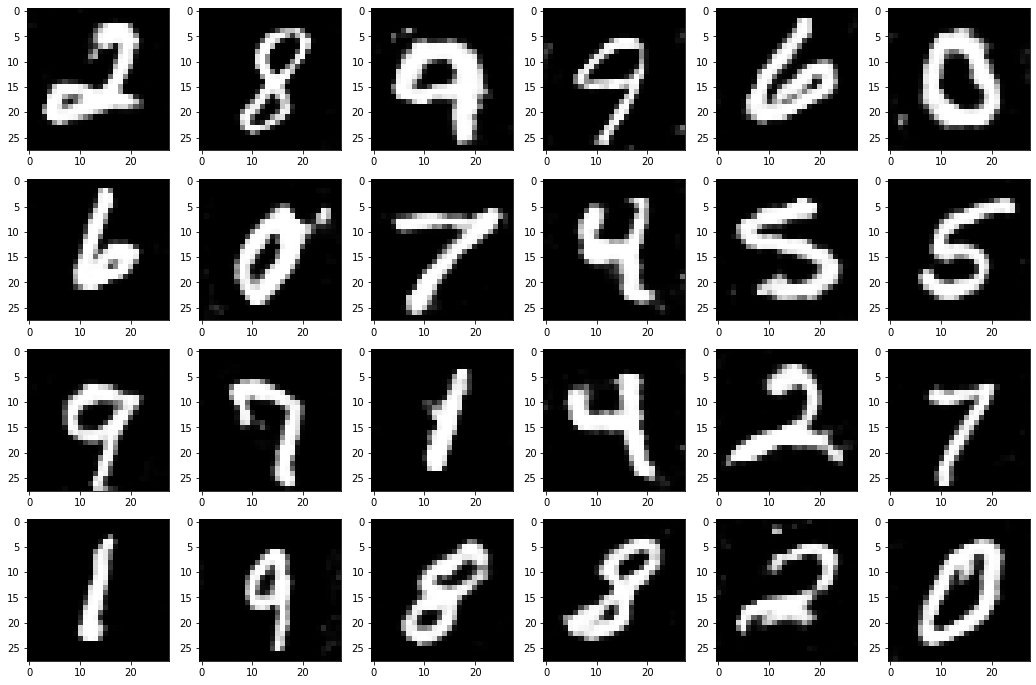

examples of generated images using average variables after 20 epochs


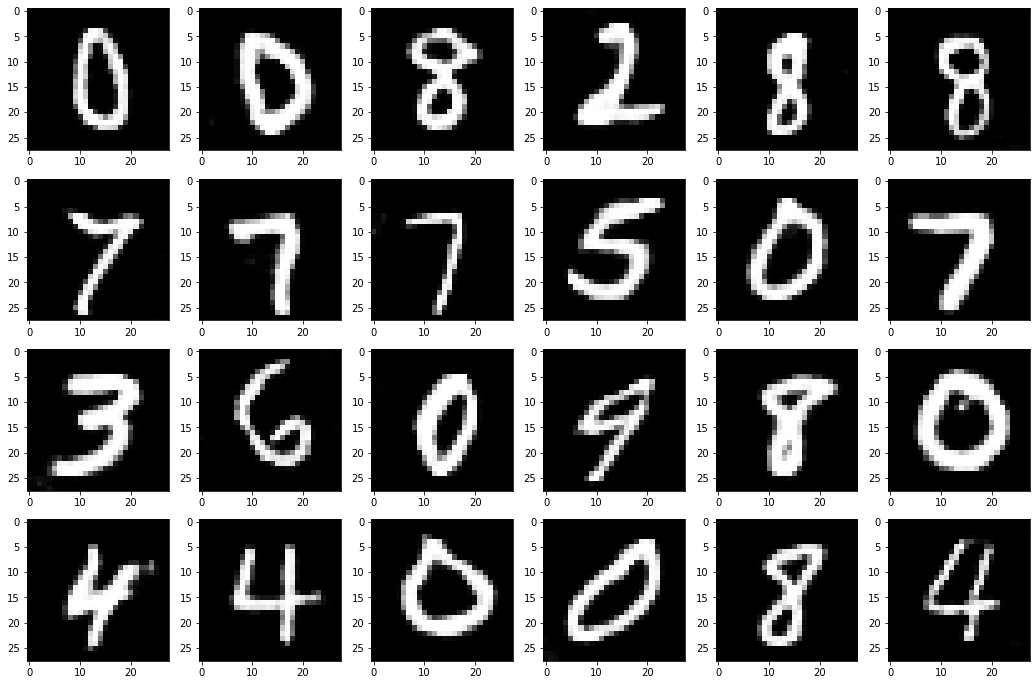

Epoch: 021: Gen Loss: 1.522, Disc Loss:0.514, IS: 2.196, IS_avr: 2.322
examples of generated images after 21 epochs


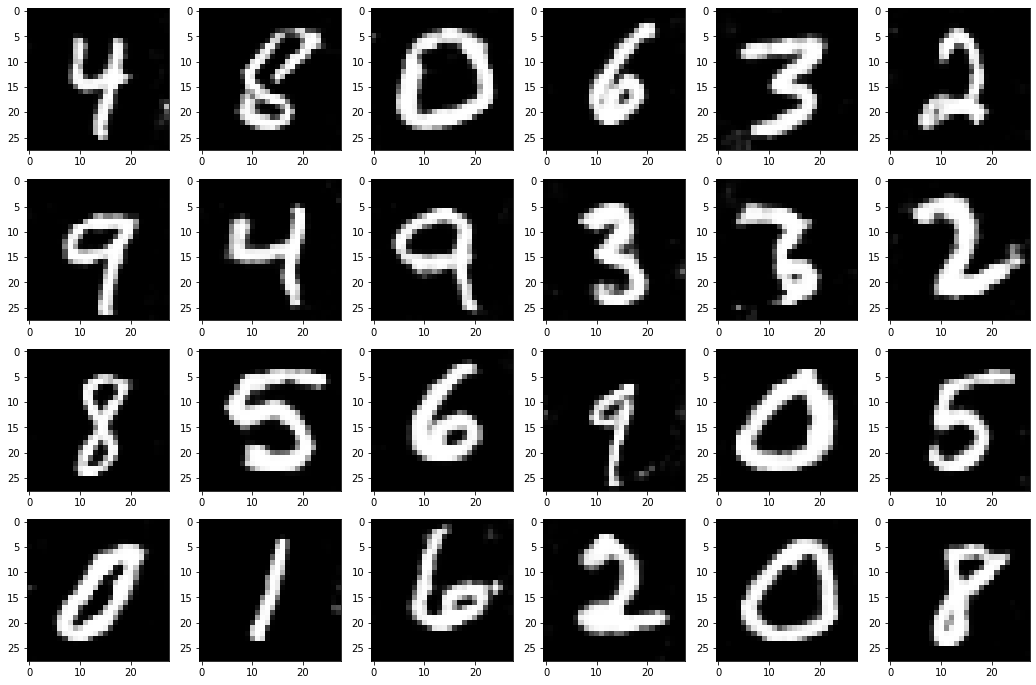

examples of generated images using average variables after 21 epochs


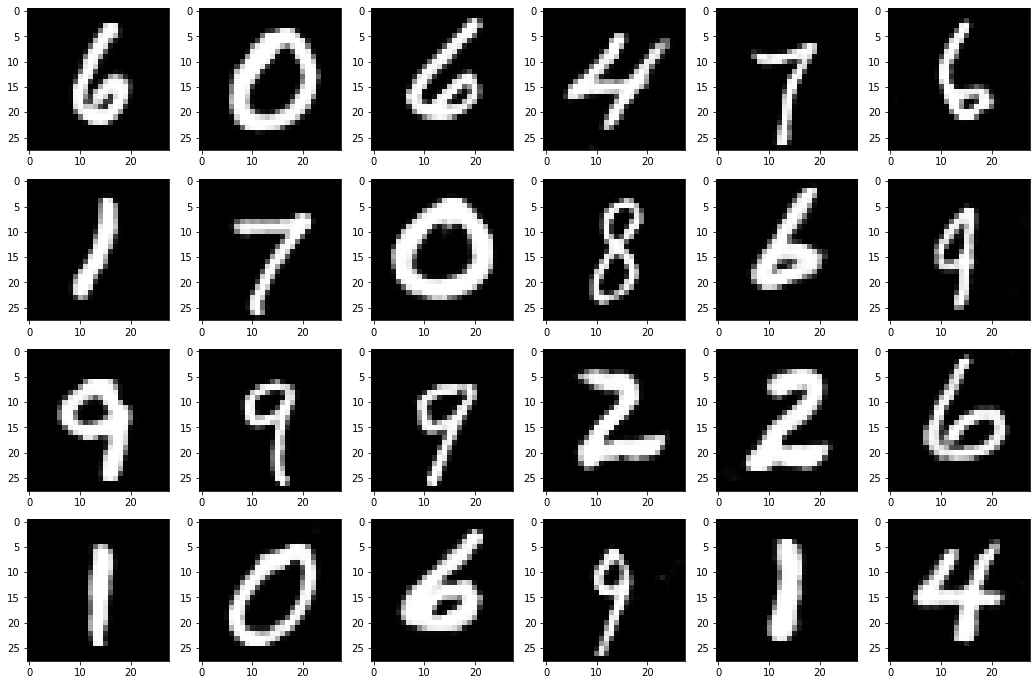

time: 1109.1956889999997 sec


In [ ]:
cgan.use_averaging = True
t0 = time.clock()
cgan.train(epochs=10)
print('time:', time.clock() - t0, 'sec')

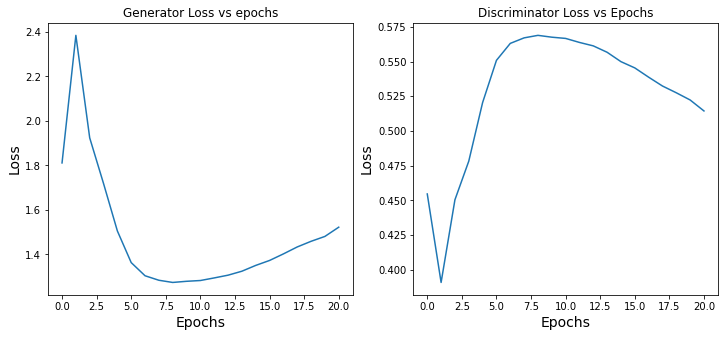

In [ ]:
cgan.draw_losses_per_epoch_graphic()

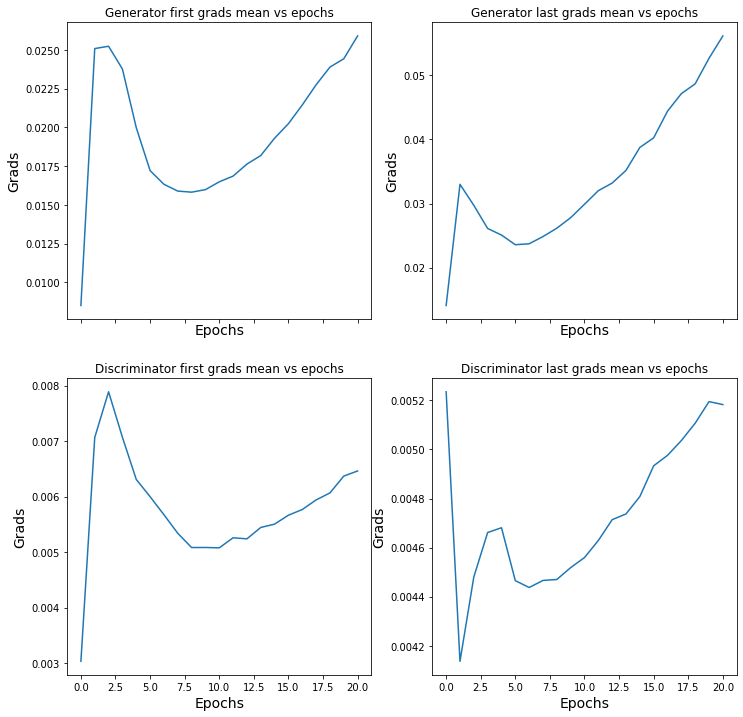

In [ ]:
cgan.draw_grads_per_epoch_graphic()

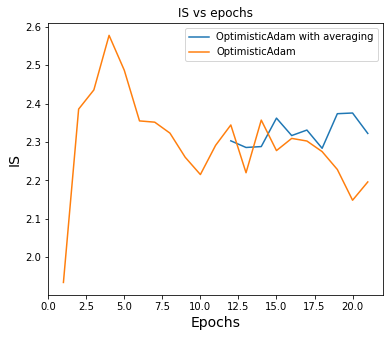

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))  
axes.set_xlabel("Epochs", fontsize=14)
axes.set_ylabel("IS", fontsize=14)
axes.set_title('IS vs epochs')
x1 = [x for x in (np.arange(10)+12)]
axes.plot(x1, cgan.IS_for_avr_per_epoch, label = 'OptimisticAdam with averaging')
x2 = [x for x in (np.arange(21)+1)]
axes.plot(x2, cgan.IS_per_epoch, label = 'OptimisticAdam')
axes.legend()
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


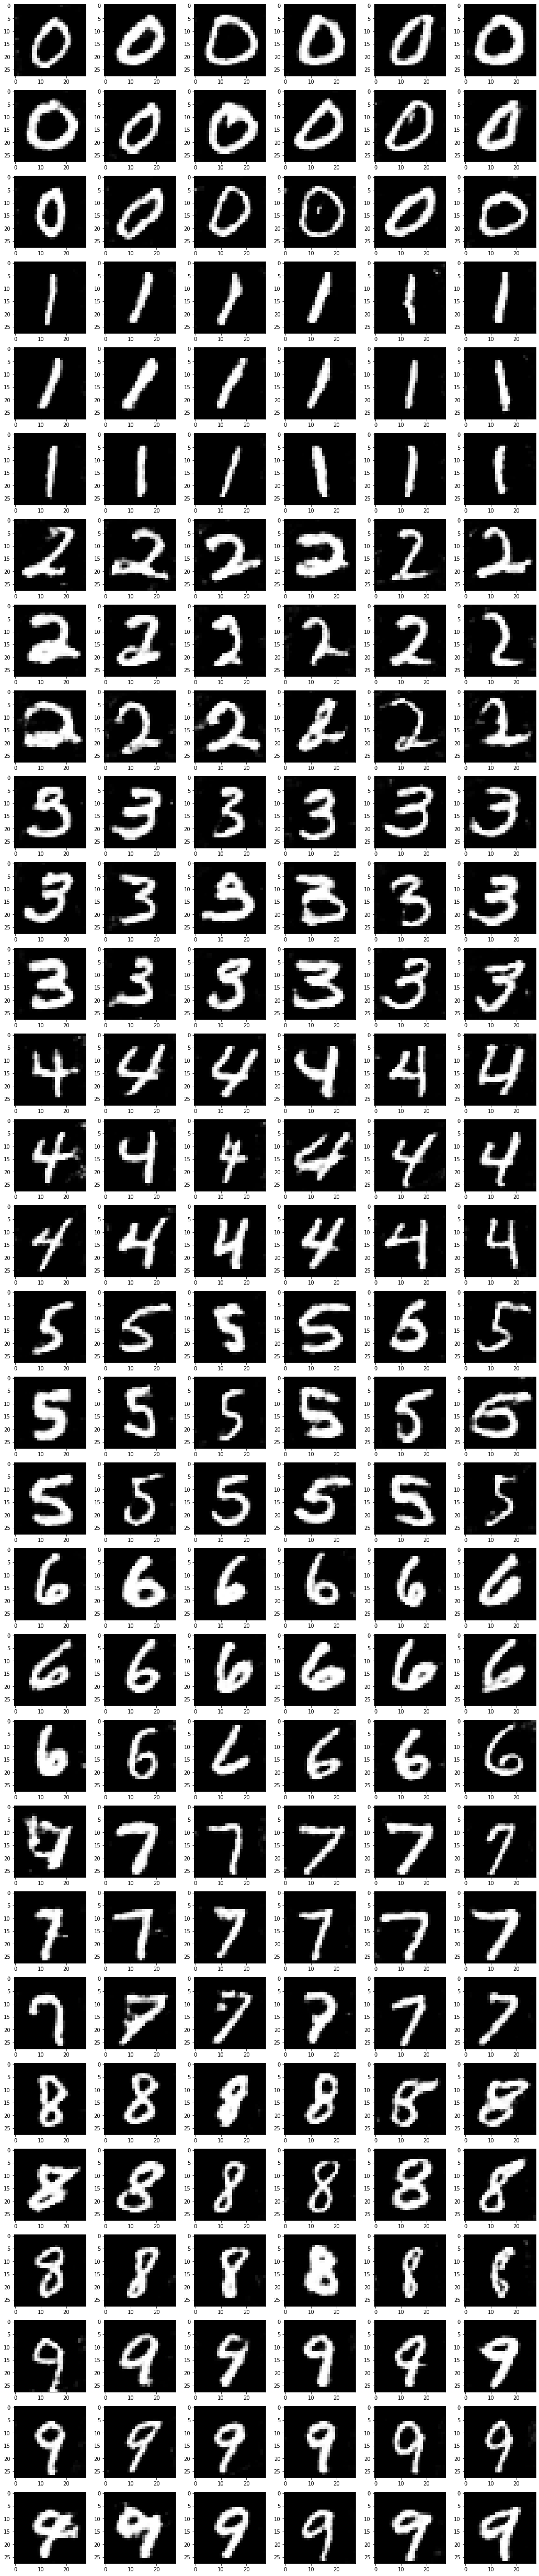

In [ ]:
arr = np.arange(10).reshape((10,1))
labels = np.tile(arr, [1,18])
labels = labels.flatten()
print(labels)

#without averaging
cgan.draw_generated_images(rows=30, cols=6, labels=labels)

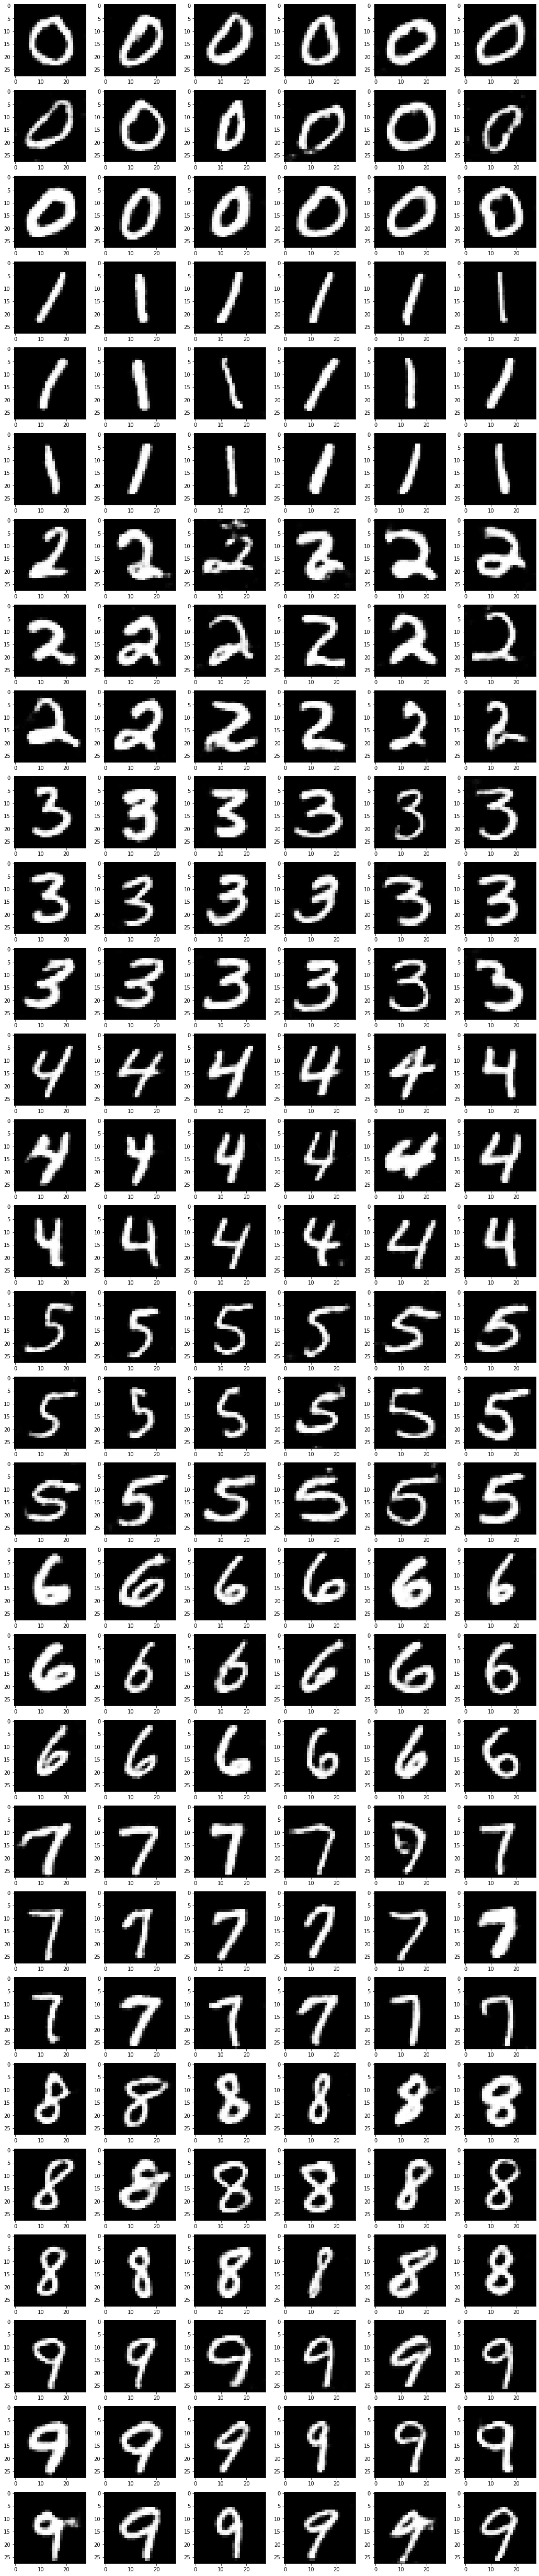

In [ ]:
#with averaging
cgan.draw_generated_images(rows=30, cols=6, labels=labels, is_from_gen_avr=True)

**ExtraAdam**

Epoch: 001: Gen Loss: 2.366, Disc Loss:0.381, IS: 2.070
examples of generated images after 1 epochs


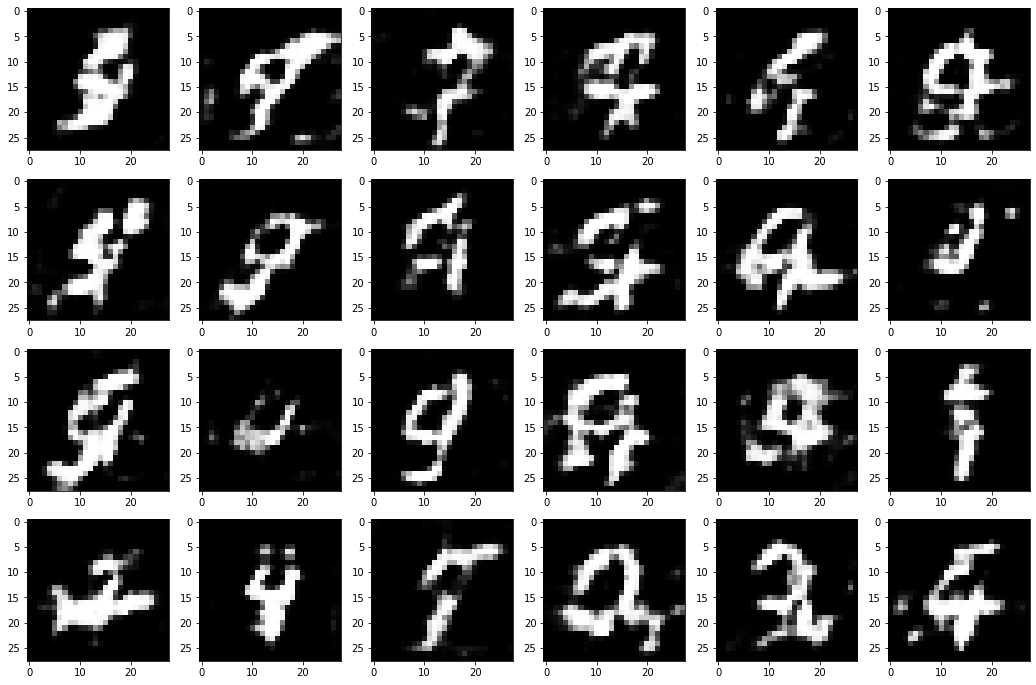

Epoch: 002: Gen Loss: 3.007, Disc Loss:0.342, IS: 2.203
examples of generated images after 2 epochs


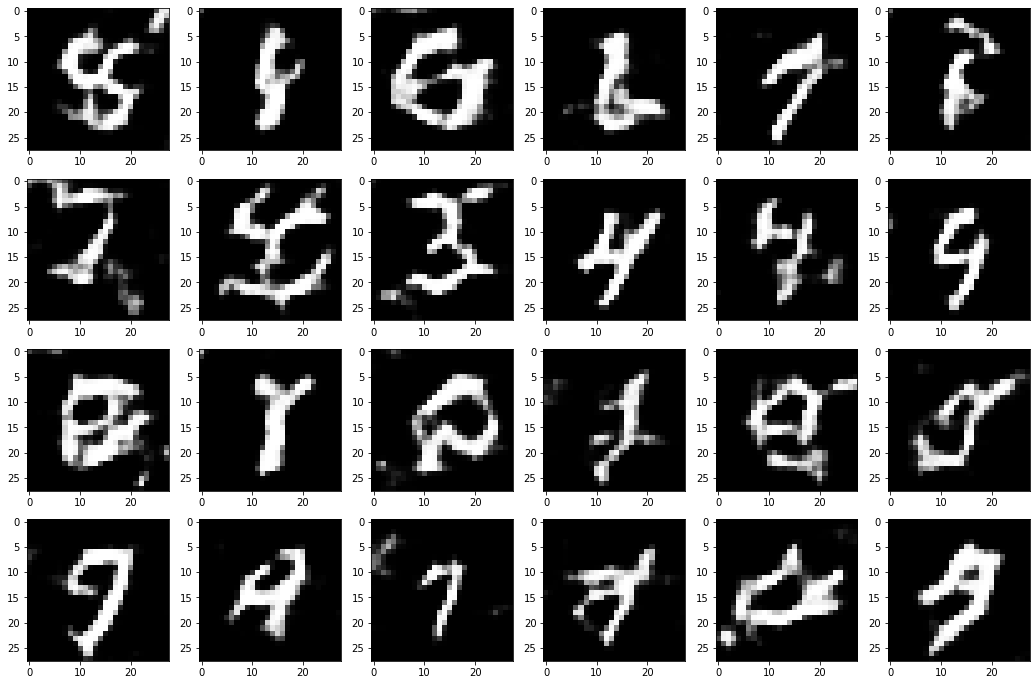

Epoch: 003: Gen Loss: 2.467, Disc Loss:0.394, IS: 2.545
examples of generated images after 3 epochs


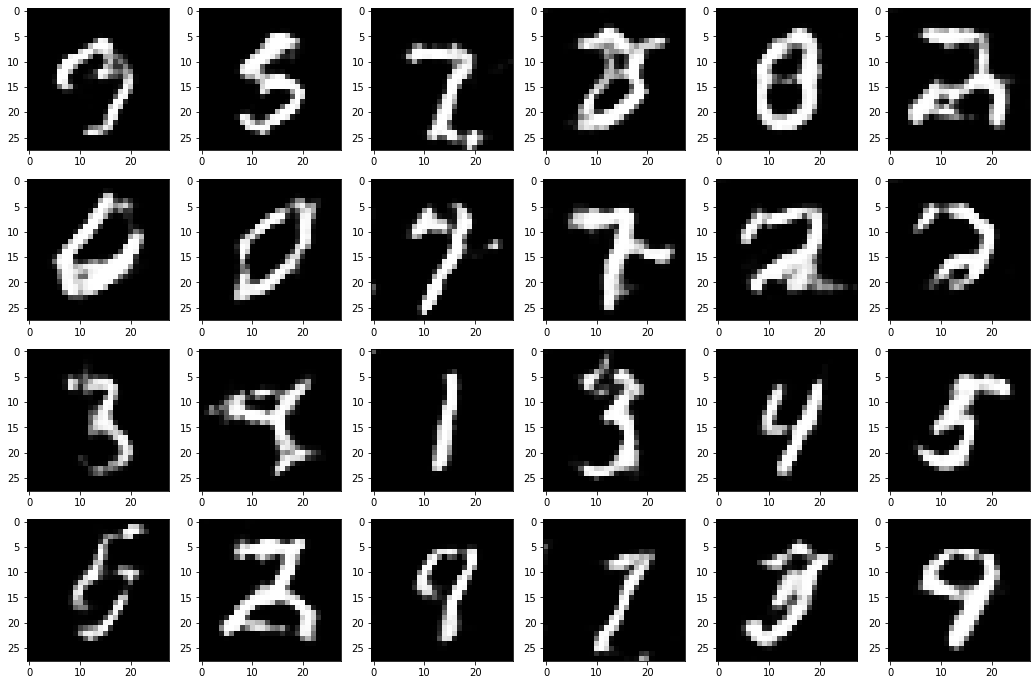

Epoch: 004: Gen Loss: 2.168, Disc Loss:0.429, IS: 2.445
examples of generated images after 4 epochs


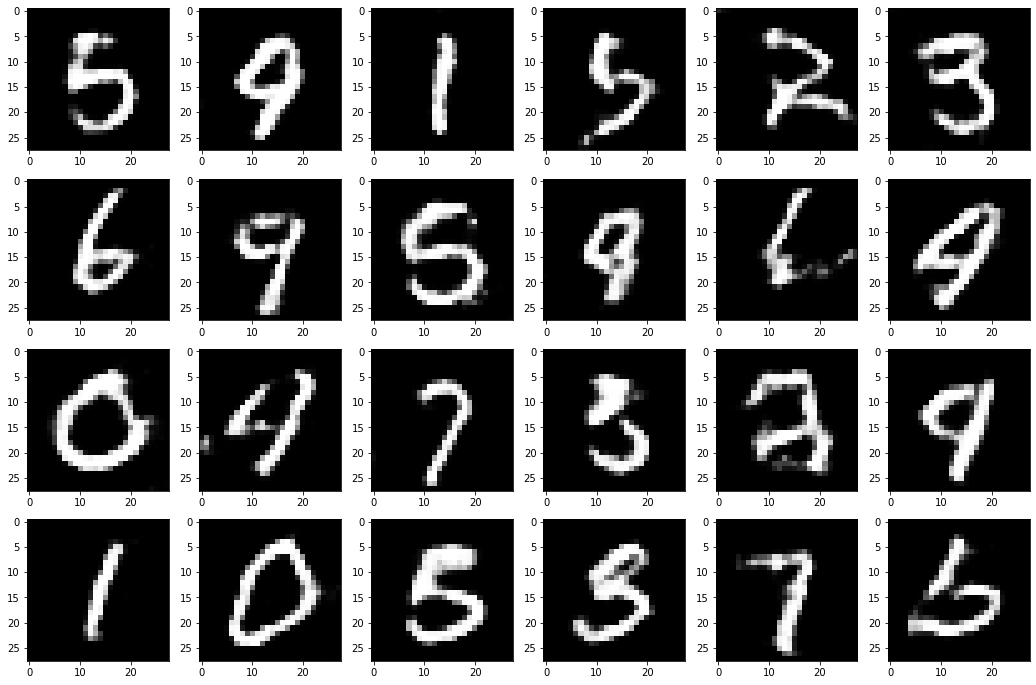

Epoch: 005: Gen Loss: 1.837, Disc Loss:0.477, IS: 2.344
examples of generated images after 5 epochs


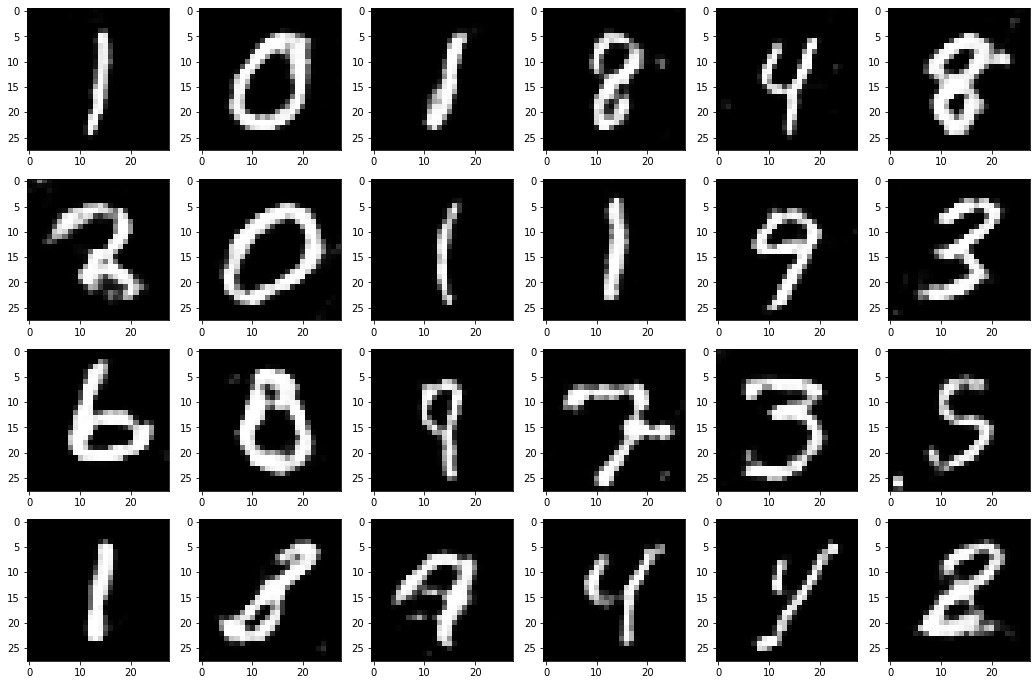

Epoch: 006: Gen Loss: 1.672, Disc Loss:0.507, IS: 2.366
examples of generated images after 6 epochs


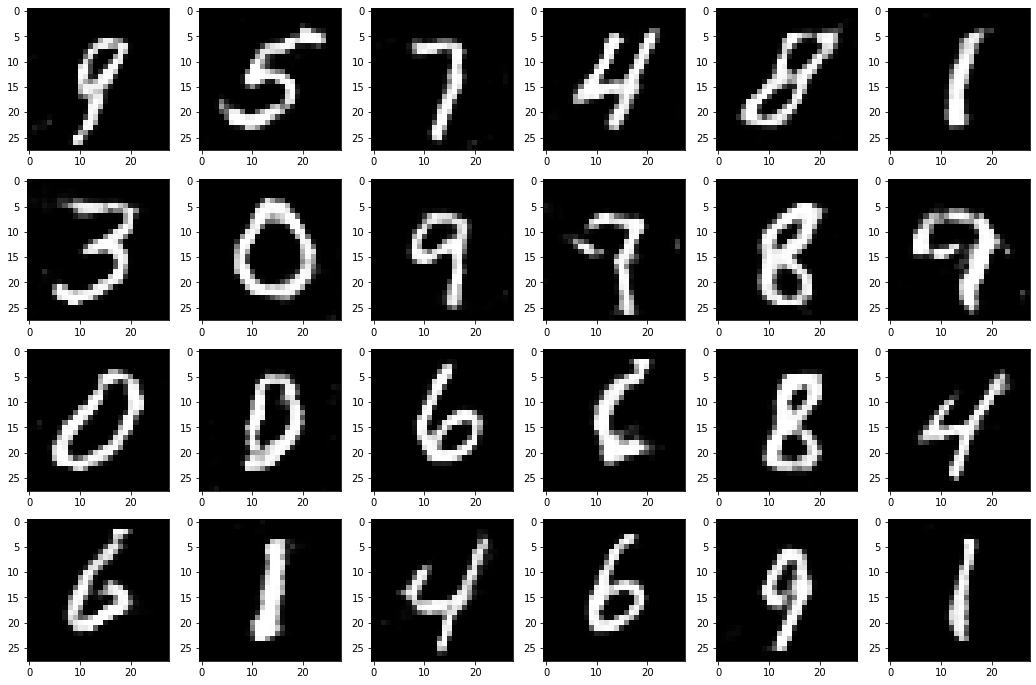

Epoch: 007: Gen Loss: 1.573, Disc Loss:0.526, IS: 2.337
examples of generated images after 7 epochs


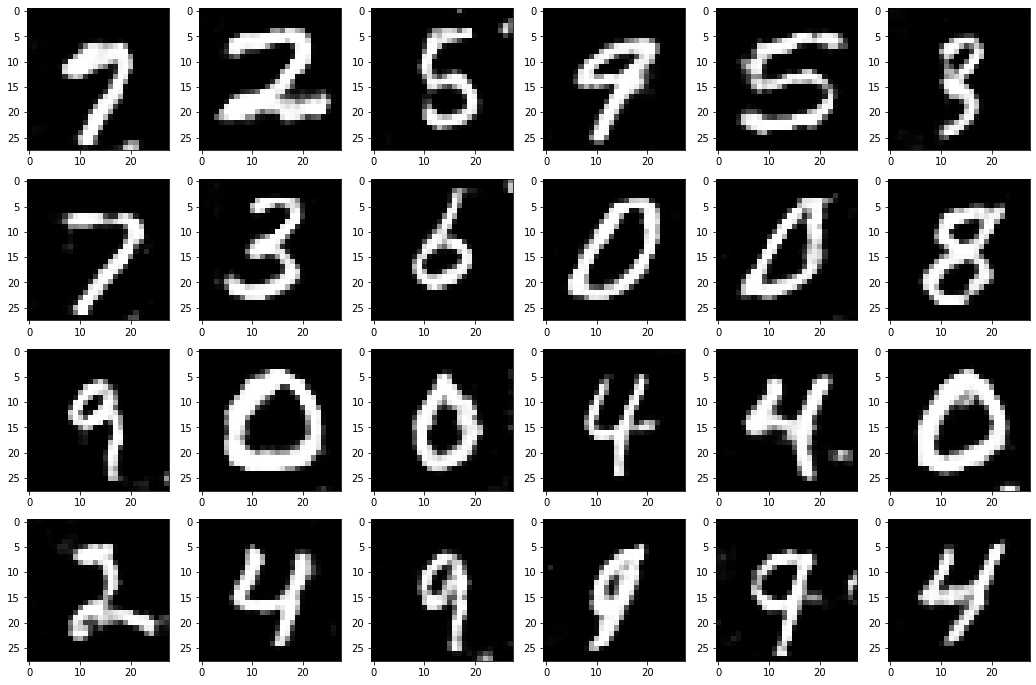

Epoch: 008: Gen Loss: 1.523, Disc Loss:0.536, IS: 2.287
examples of generated images after 8 epochs


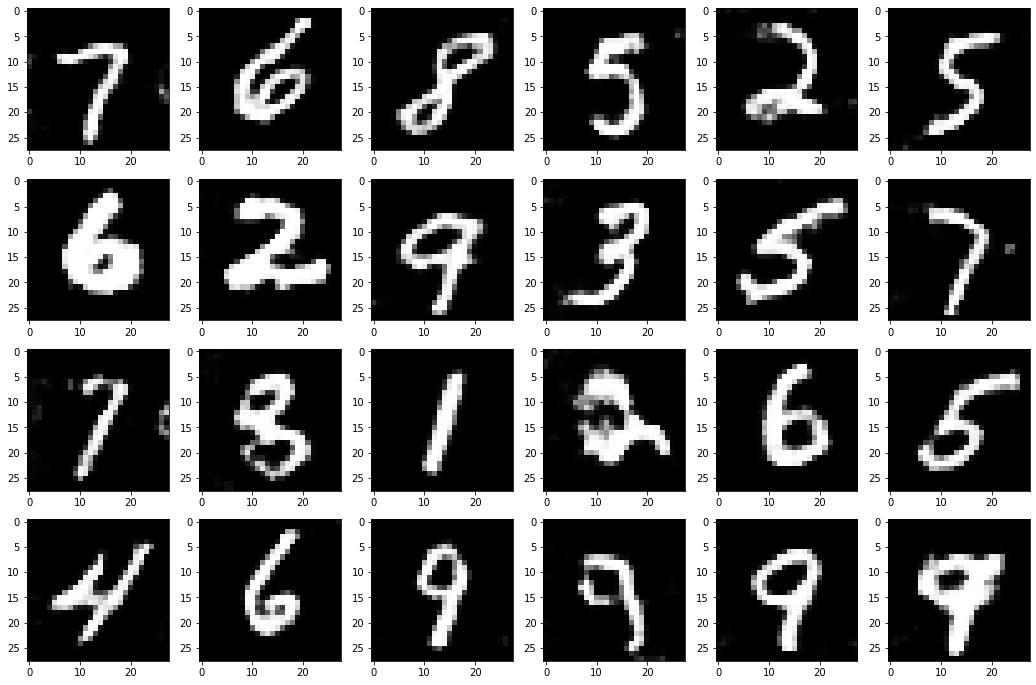

Epoch: 009: Gen Loss: 1.513, Disc Loss:0.536, IS: 2.312
examples of generated images after 9 epochs


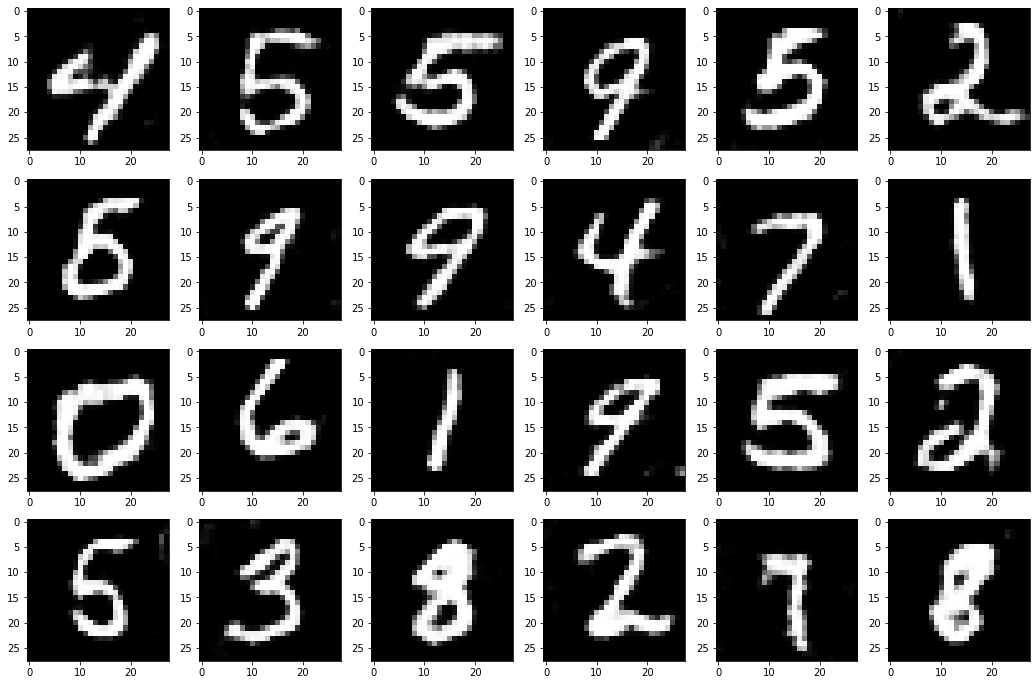

Epoch: 010: Gen Loss: 1.511, Disc Loss:0.536, IS: 2.438
examples of generated images after 10 epochs


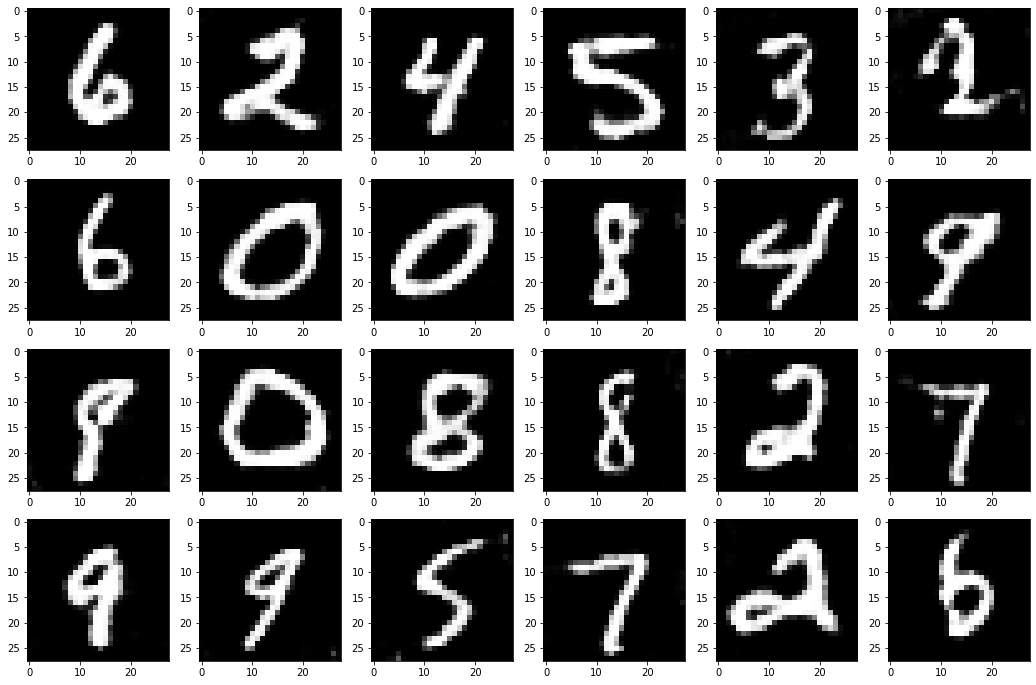

Epoch: 011: Gen Loss: 1.535, Disc Loss:0.530, IS: 2.252
examples of generated images after 11 epochs


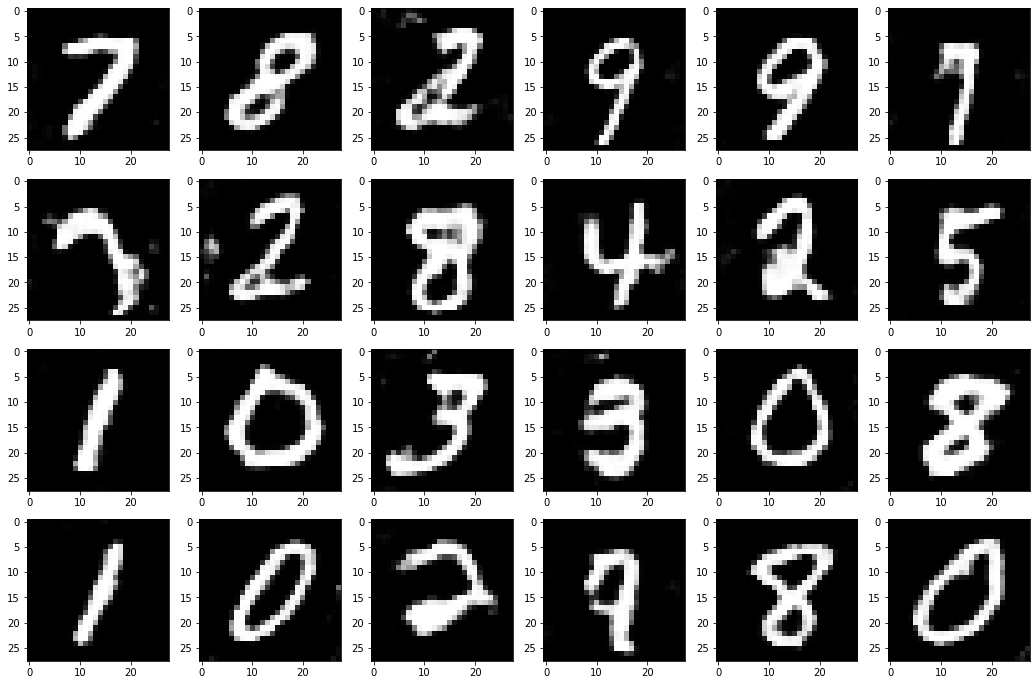

time: 446.5491830000001 sec


In [ ]:
cgan = CGAN(ExtraAdam(learning_rate=0.0002, beta_1=0.5), x_train, 
           y_train, batch_size=128, use_averaging=False,
            path='/content/drive/My Drive/Univ/Final models/Saved models/CGAN extra Adam/')
t0 = time.clock()
cgan.train(epochs=11)
print('time:', time.clock() - t0, 'sec')

Epoch: 012: Gen Loss: 1.303, Disc Loss:0.525, IS: 2.271, IS_avr: 2.288
examples of generated images after 12 epochs


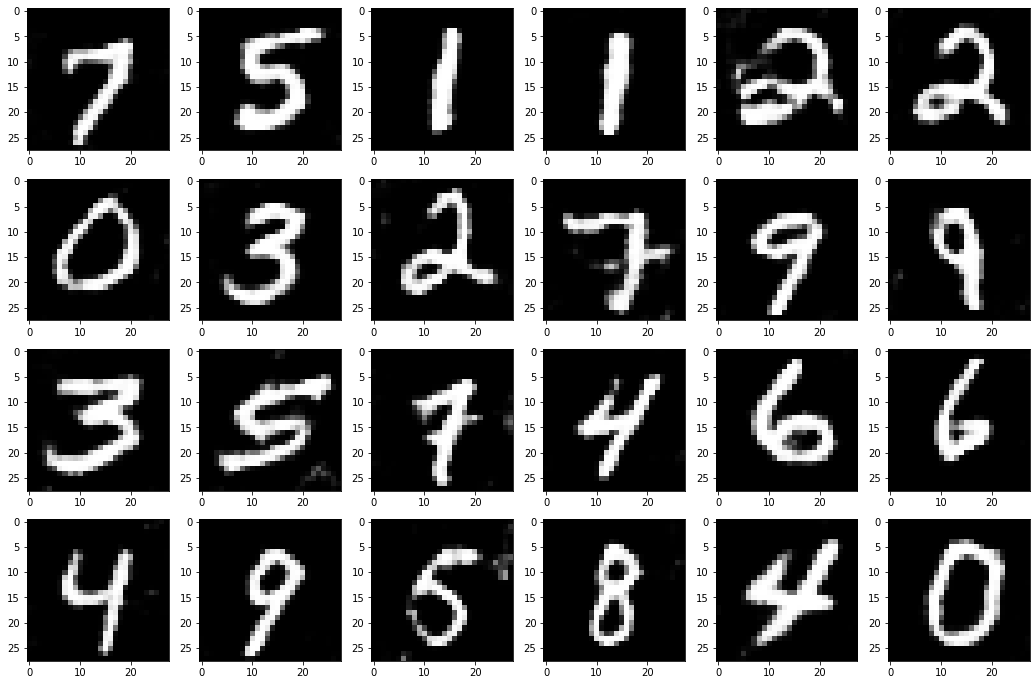

examples of generated images using average variables after 12 epochs


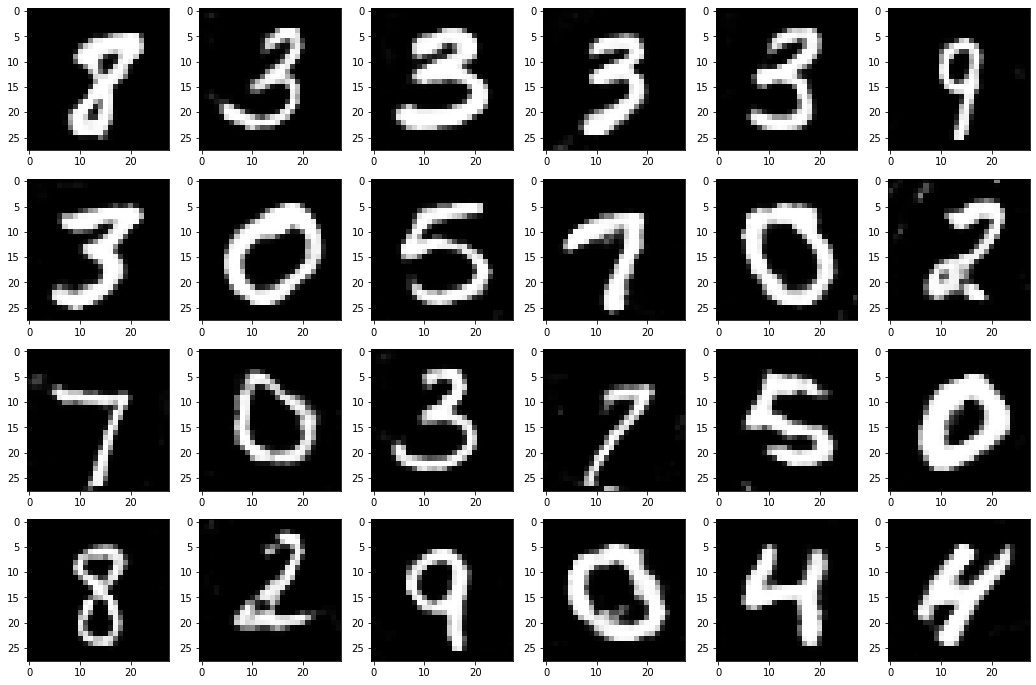

Epoch: 013: Gen Loss: 1.346, Disc Loss:0.515, IS: 2.224, IS_avr: 2.342
examples of generated images after 13 epochs


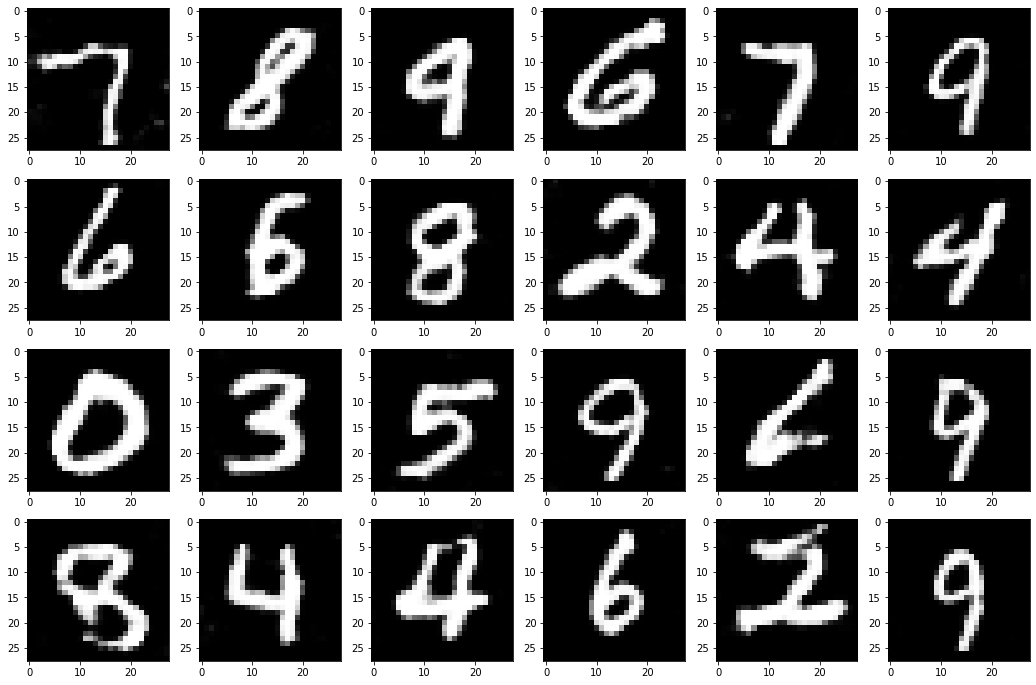

examples of generated images using average variables after 13 epochs


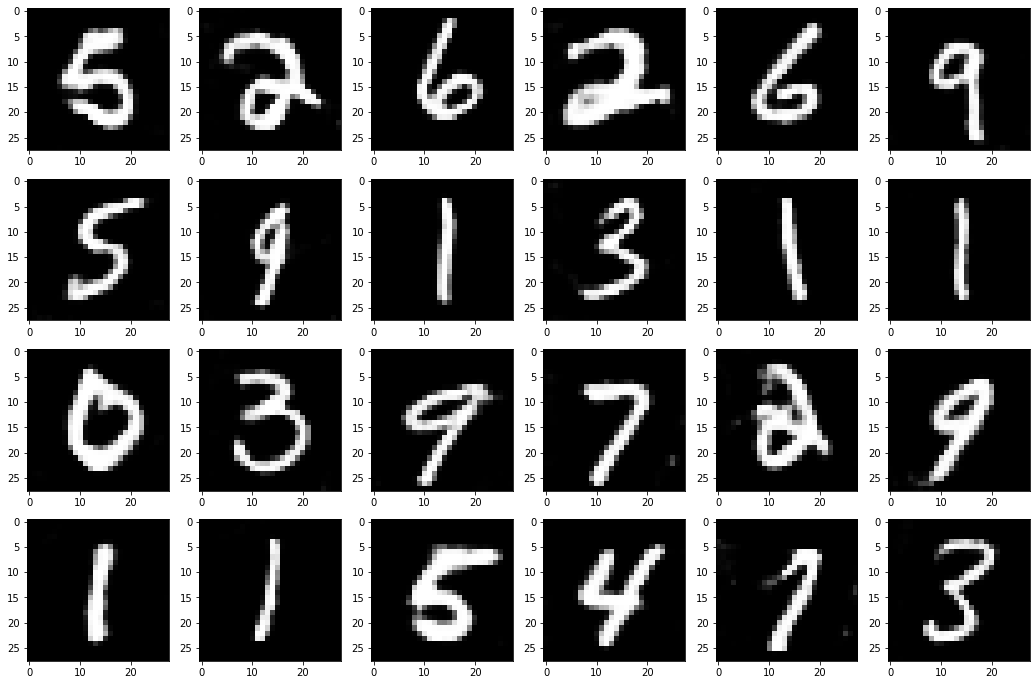

Epoch: 014: Gen Loss: 1.377, Disc Loss:0.510, IS: 2.164, IS_avr: 2.270
examples of generated images after 14 epochs


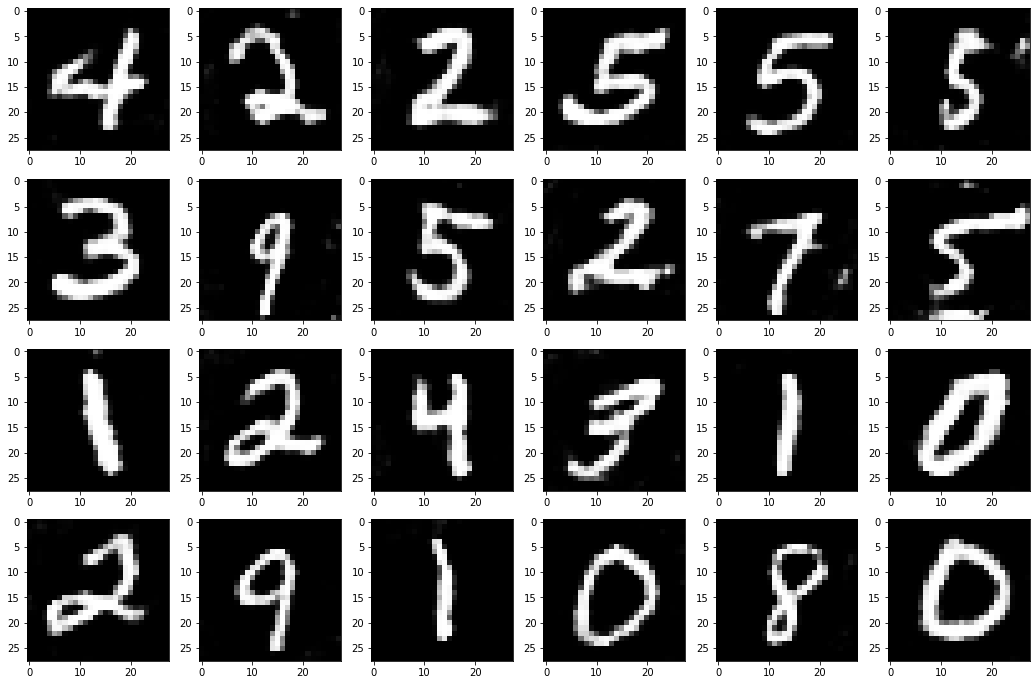

examples of generated images using average variables after 14 epochs


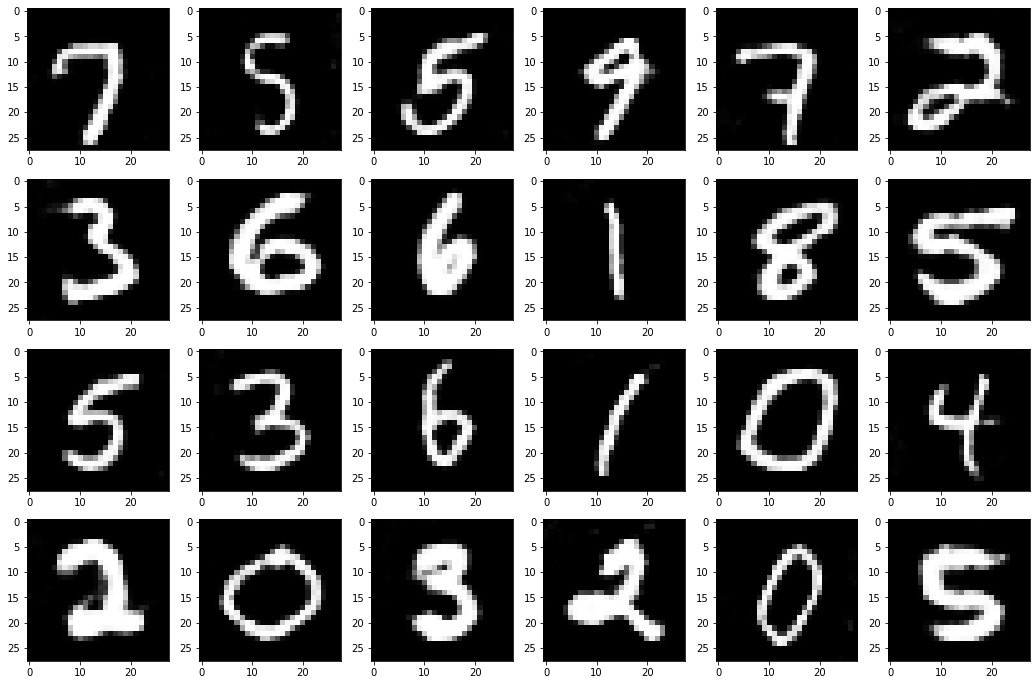

Epoch: 015: Gen Loss: 1.409, Disc Loss:0.504, IS: 2.269, IS_avr: 2.327
examples of generated images after 15 epochs


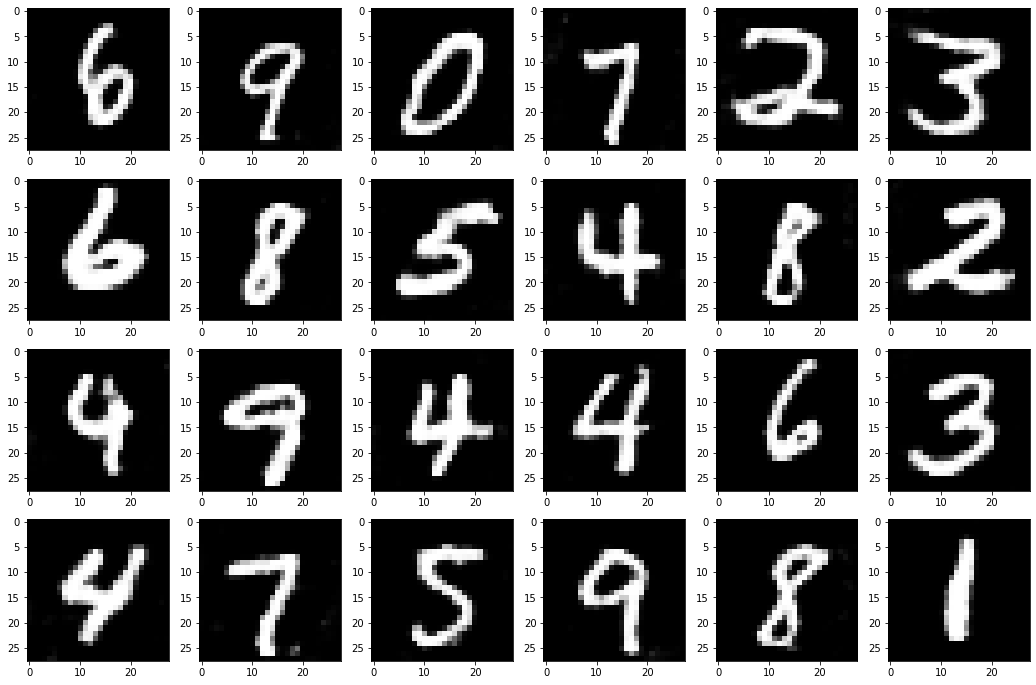

examples of generated images using average variables after 15 epochs


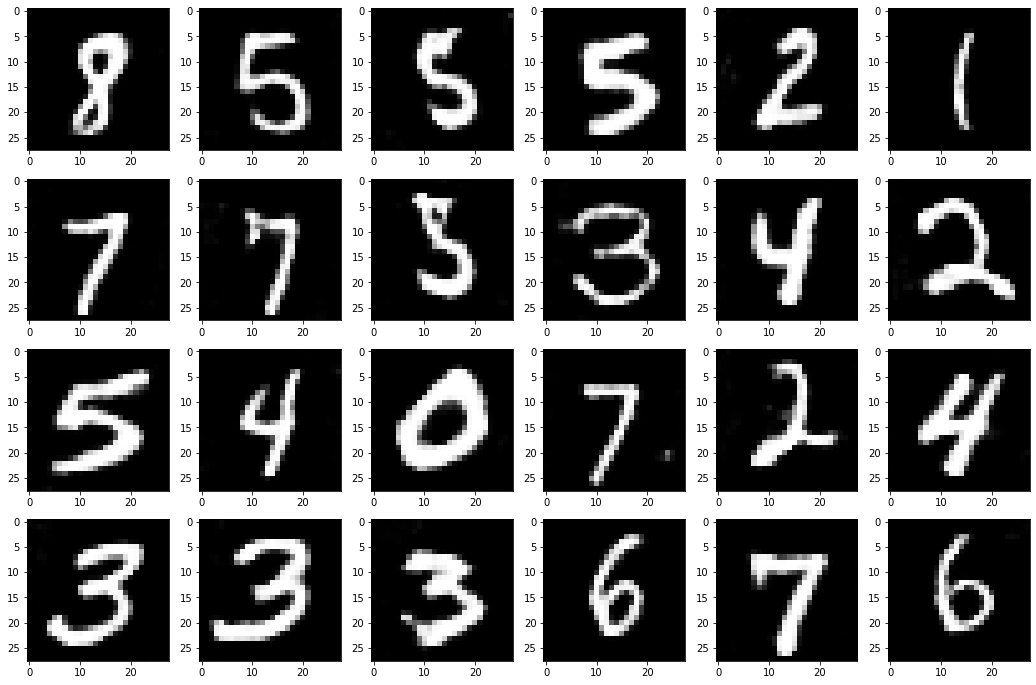

Epoch: 016: Gen Loss: 1.430, Disc Loss:0.498, IS: 2.353, IS_avr: 2.274
examples of generated images after 16 epochs


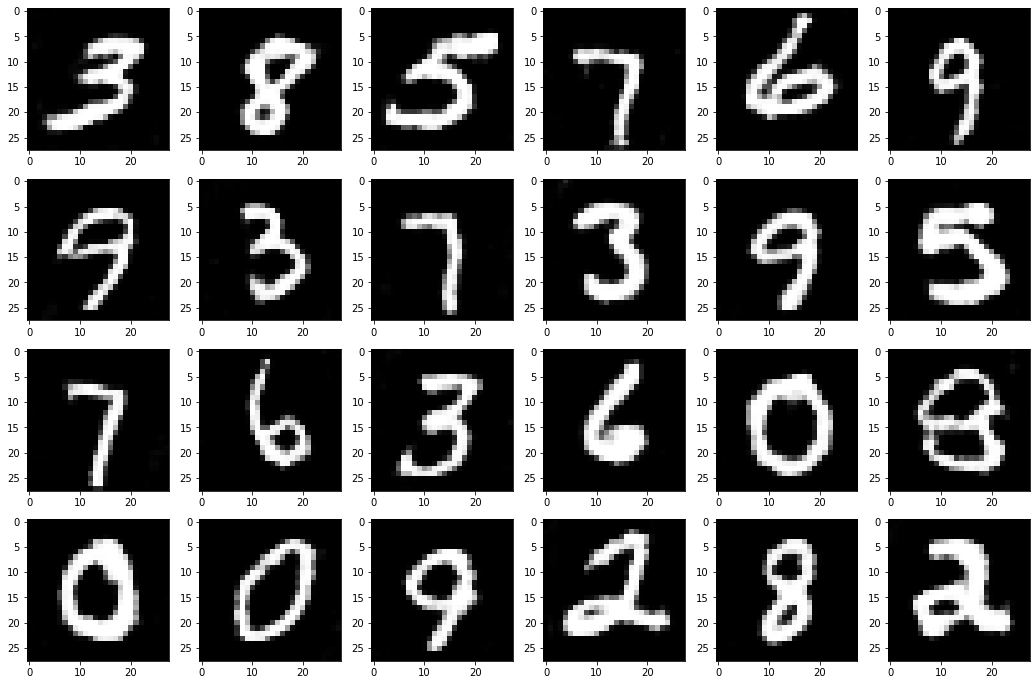

examples of generated images using average variables after 16 epochs


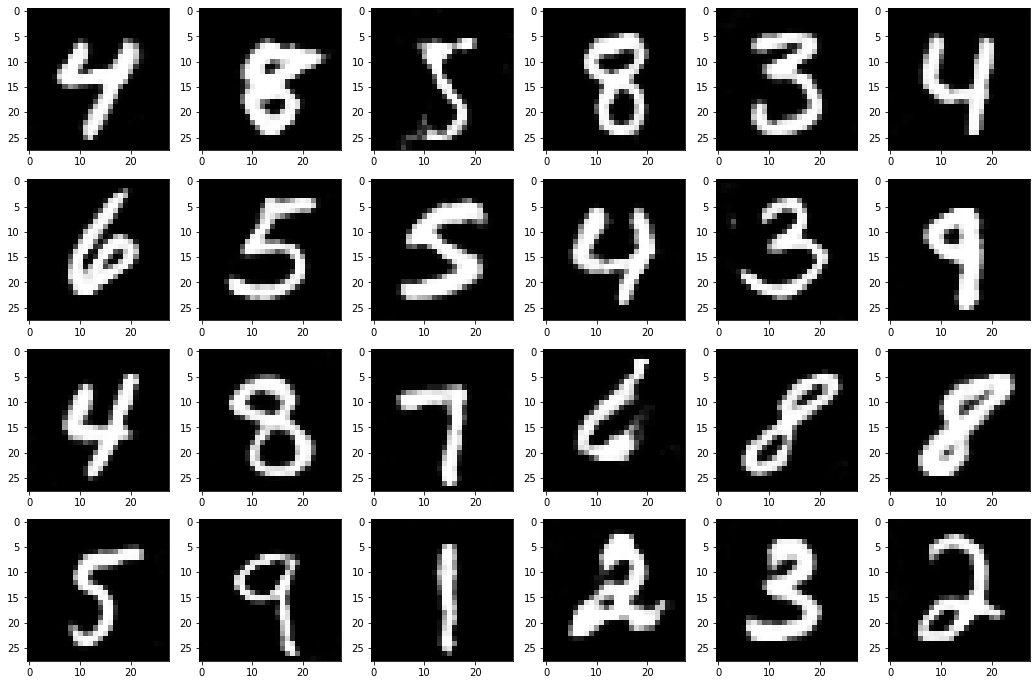

Epoch: 017: Gen Loss: 1.465, Disc Loss:0.491, IS: 2.231, IS_avr: 2.315
examples of generated images after 17 epochs


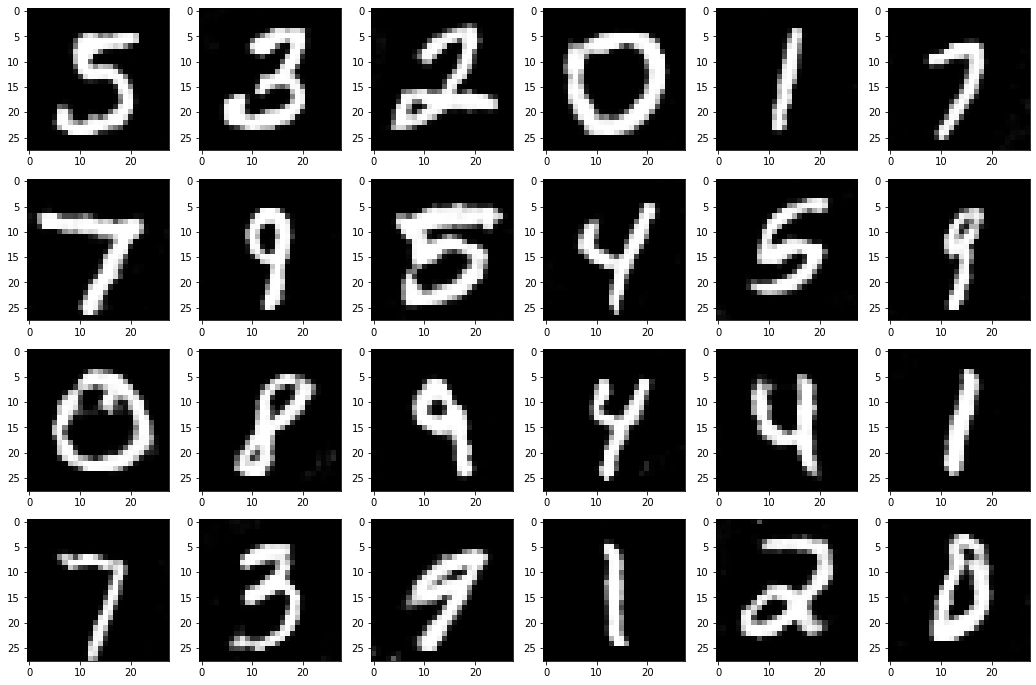

examples of generated images using average variables after 17 epochs


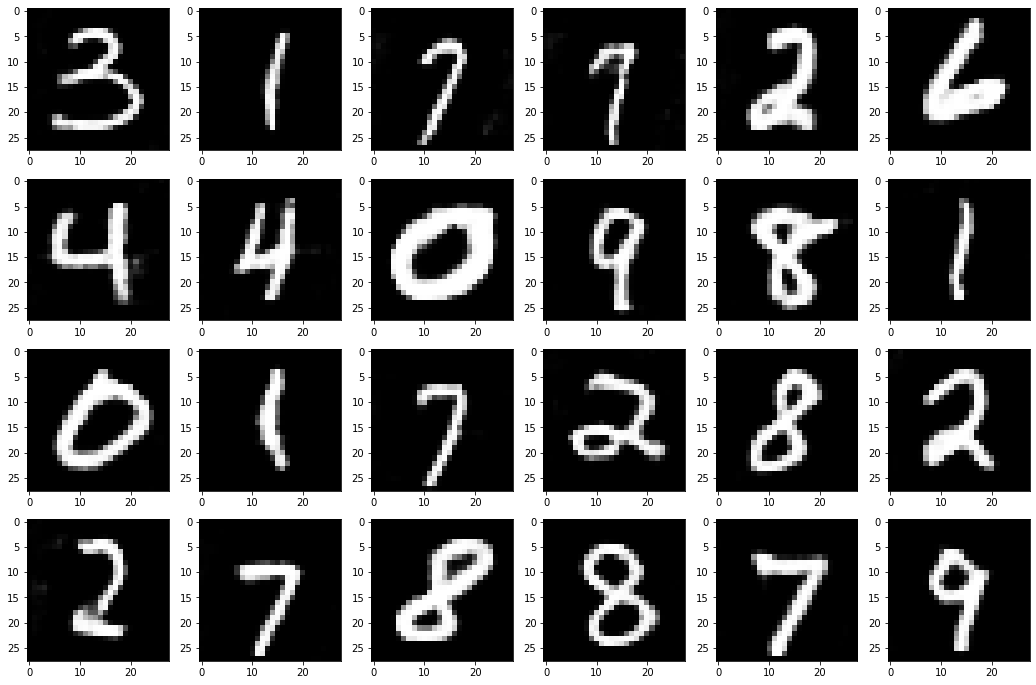

Epoch: 018: Gen Loss: 1.497, Disc Loss:0.484, IS: 2.319, IS_avr: 2.291
examples of generated images after 18 epochs


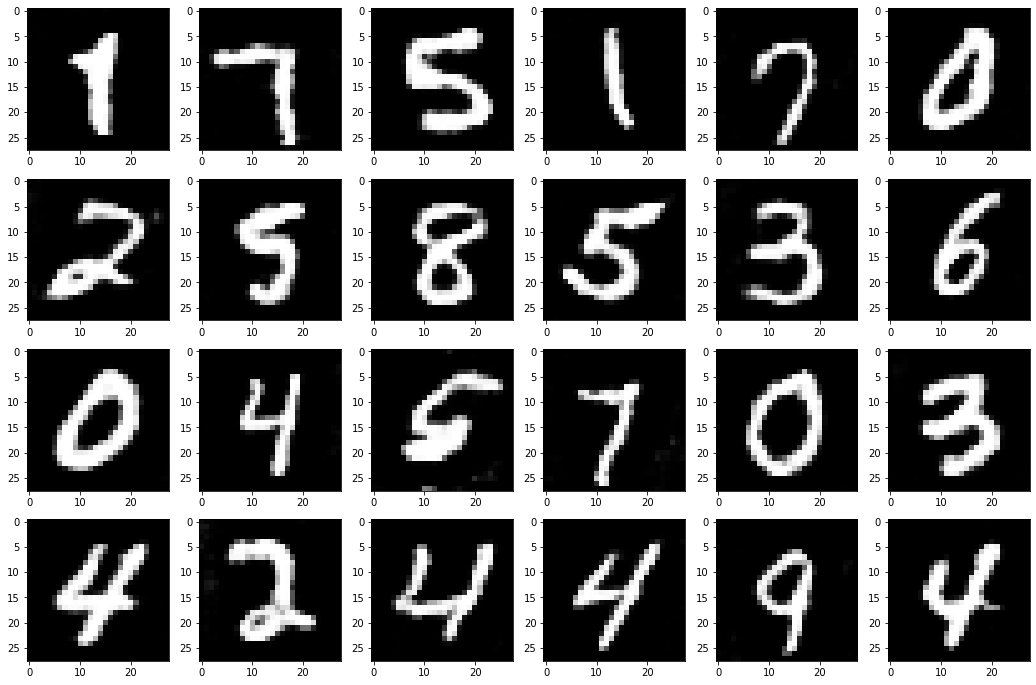

examples of generated images using average variables after 18 epochs


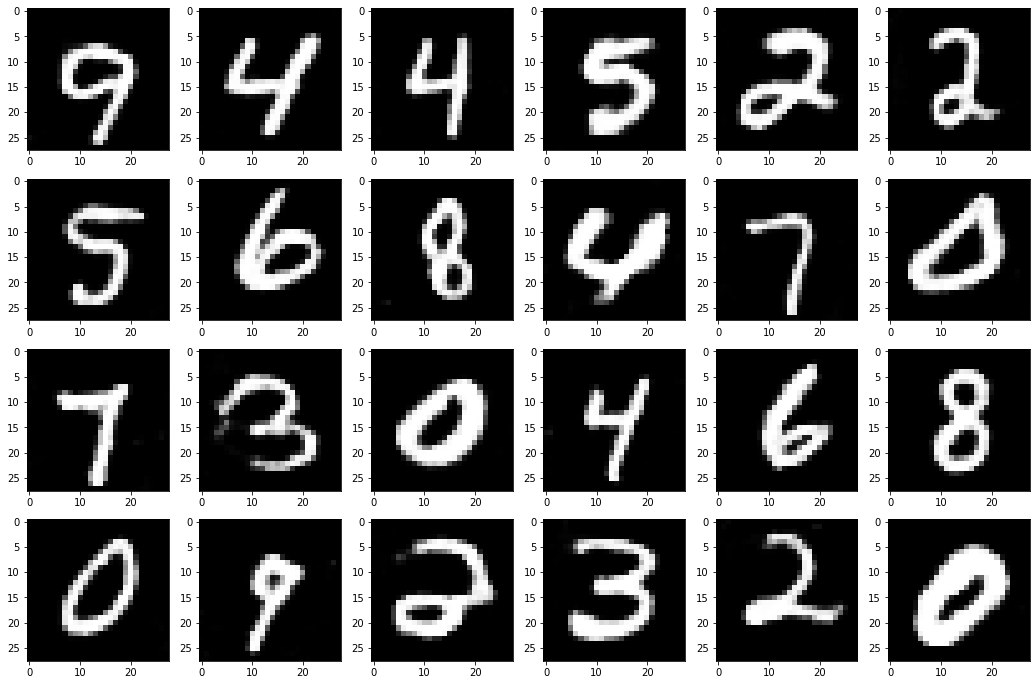

Epoch: 019: Gen Loss: 1.536, Disc Loss:0.478, IS: 2.287, IS_avr: 2.295
examples of generated images after 19 epochs


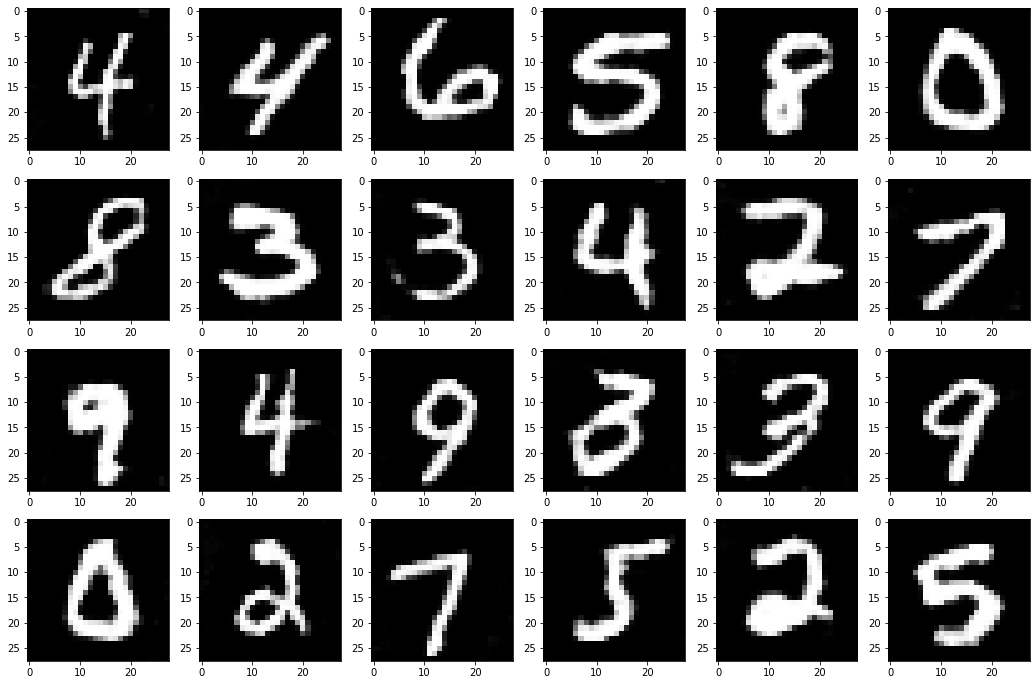

examples of generated images using average variables after 19 epochs


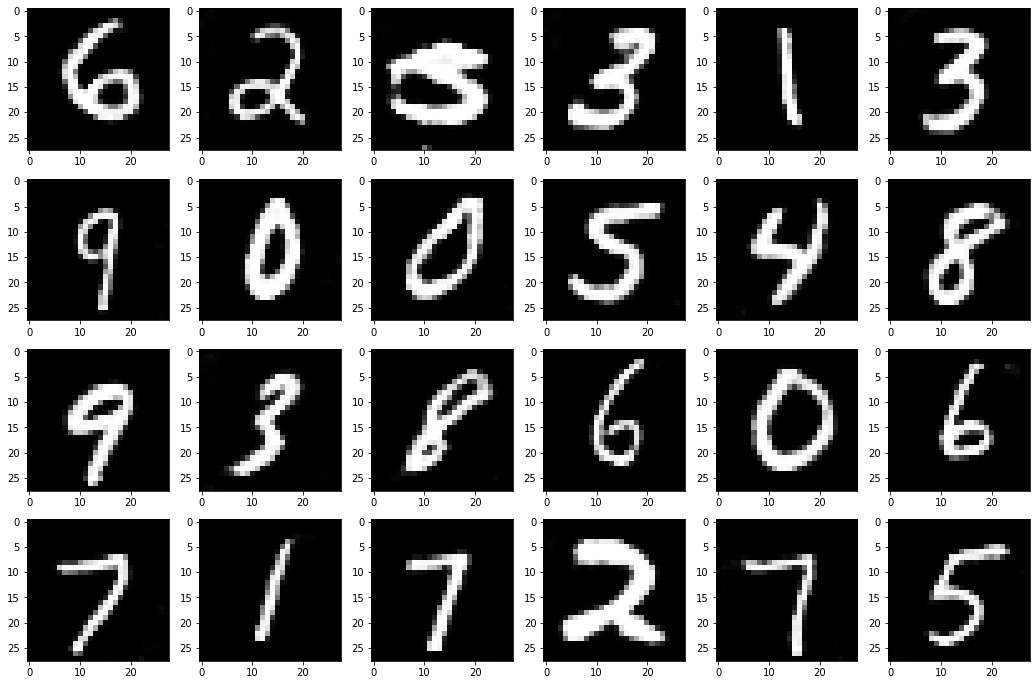

Epoch: 020: Gen Loss: 1.572, Disc Loss:0.471, IS: 2.243, IS_avr: 2.279
examples of generated images after 20 epochs


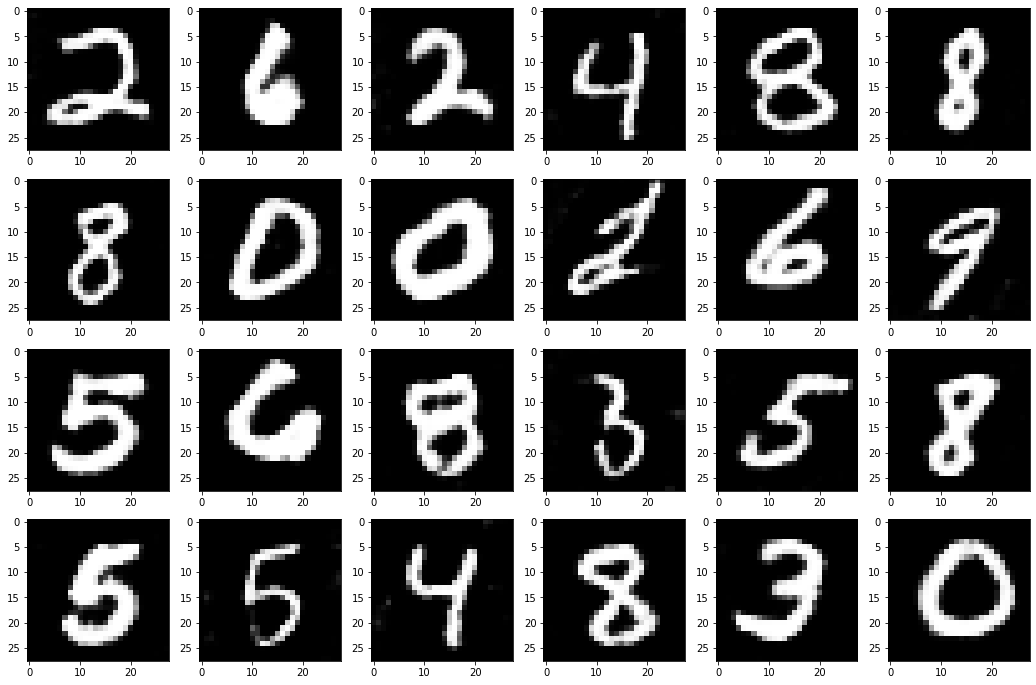

examples of generated images using average variables after 20 epochs


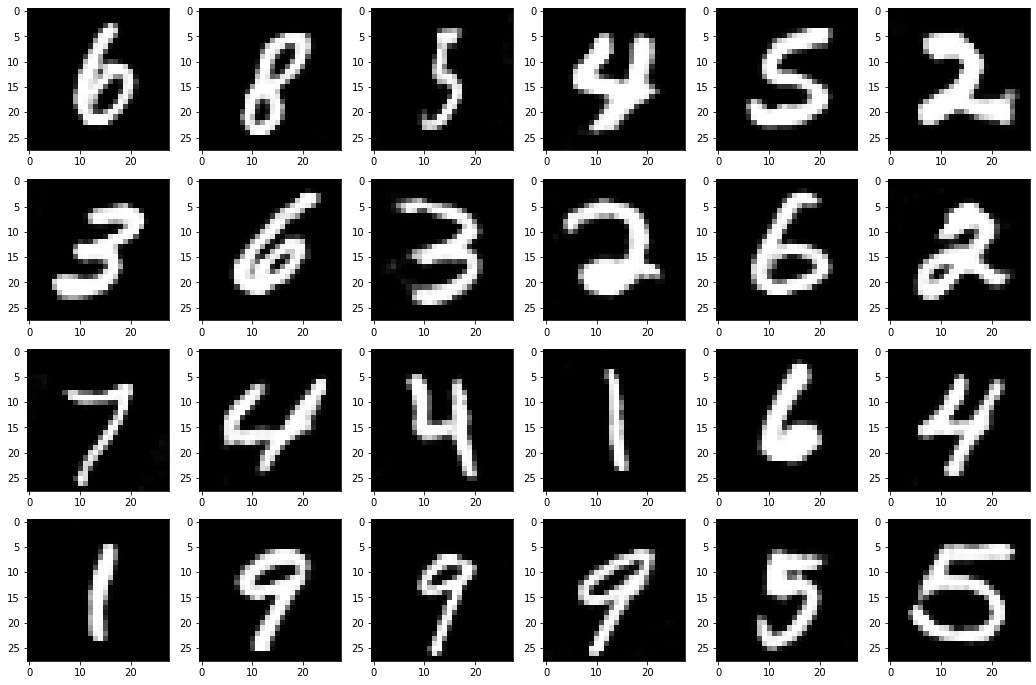

Epoch: 021: Gen Loss: 1.596, Disc Loss:0.464, IS: 2.375, IS_avr: 2.310
examples of generated images after 21 epochs


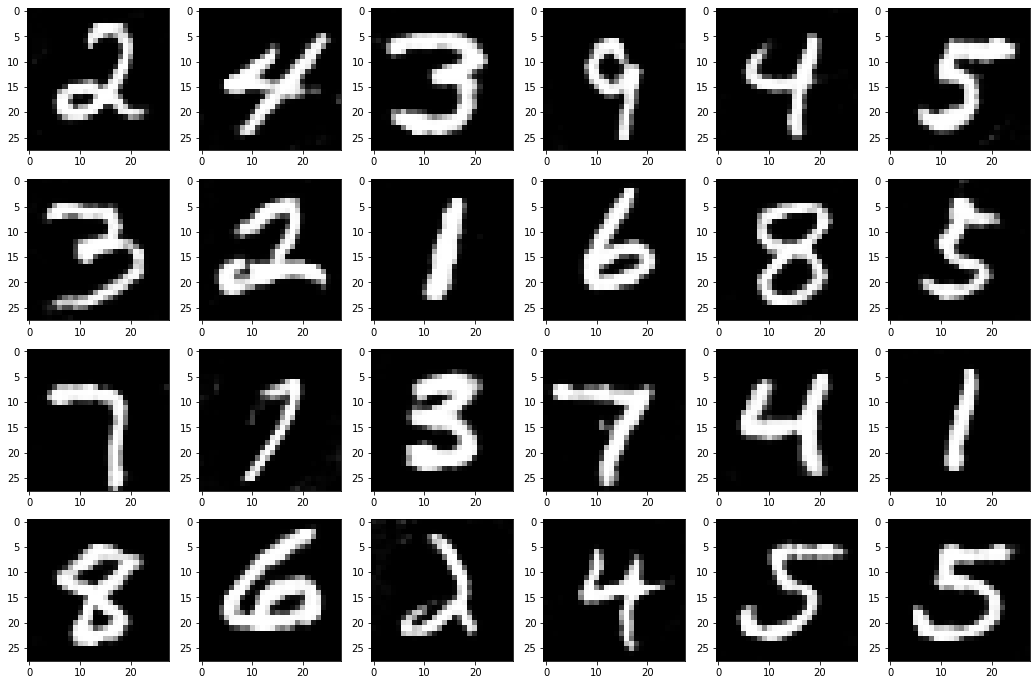

examples of generated images using average variables after 21 epochs


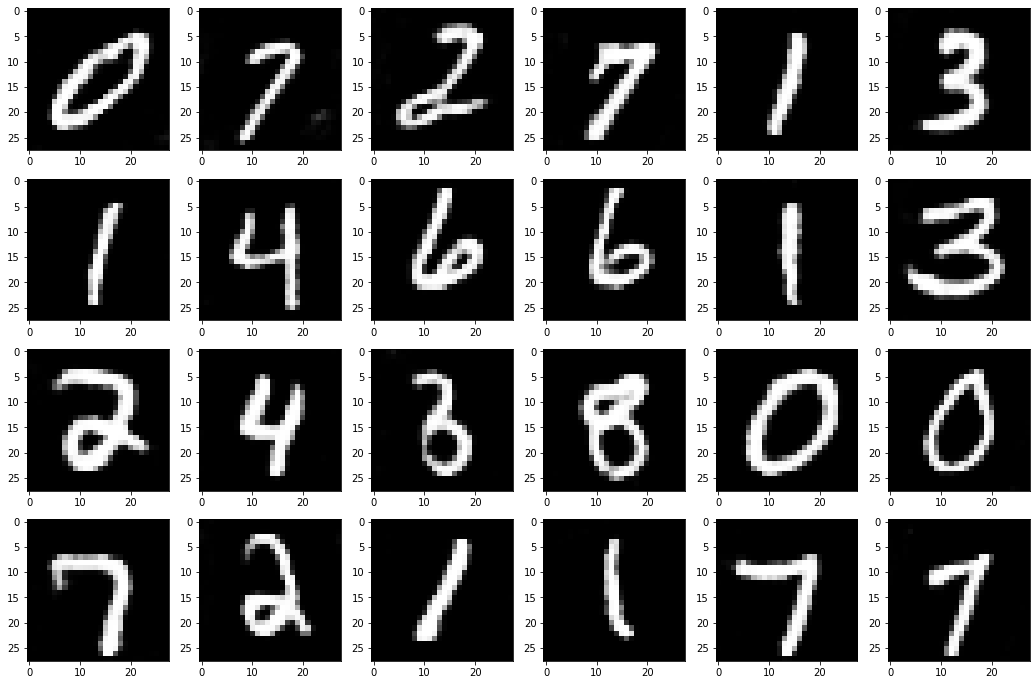

time: 655.0857570000003 sec


In [ ]:
cgan.use_averaging = True
t0 = time.clock()
cgan.train(epochs=10)
print('time:', time.clock() - t0, 'sec')

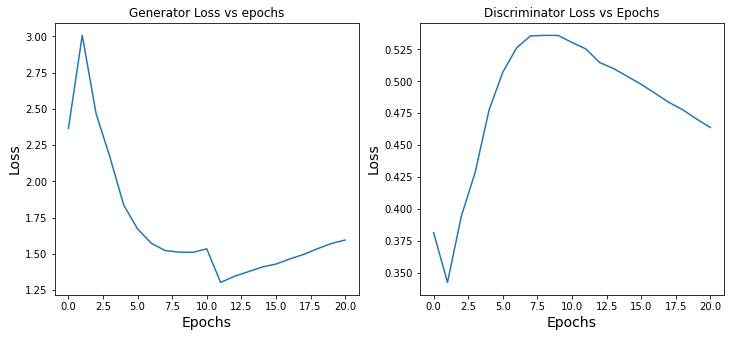

In [ ]:
cgan.draw_losses_per_epoch_graphic()

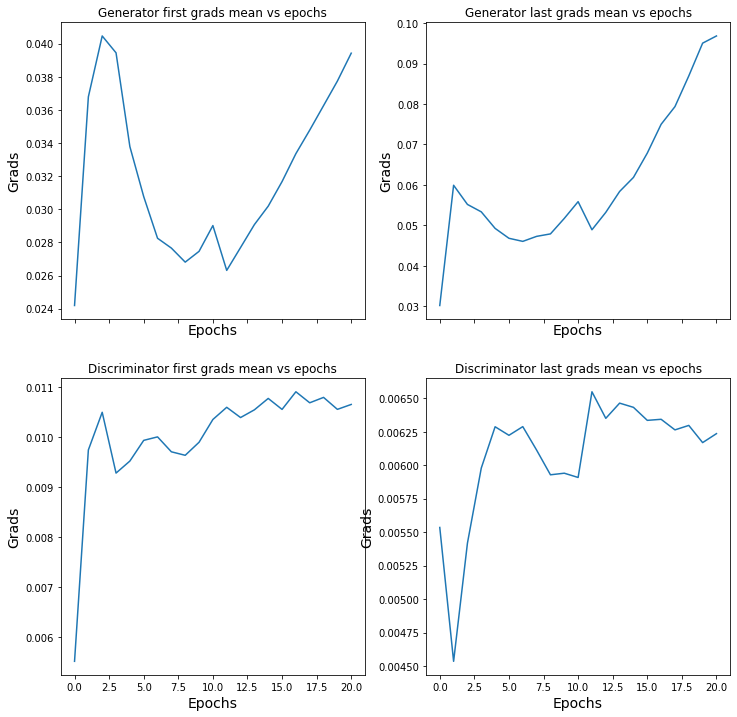

In [ ]:
cgan.draw_grads_per_epoch_graphic()

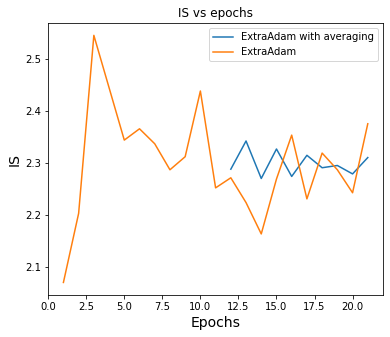

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))  
axes.set_xlabel("Epochs", fontsize=14)
axes.set_ylabel("IS", fontsize=14)
axes.set_title('IS vs epochs')
x1 = [x for x in (np.arange(10)+12)]
axes.plot(x1, cgan.IS_for_avr_per_epoch, label = 'ExtraAdam with averaging')
x2 = [x for x in (np.arange(21)+1)]
axes.plot(x2, cgan.IS_per_epoch, label = 'ExtraAdam')
axes.legend()
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


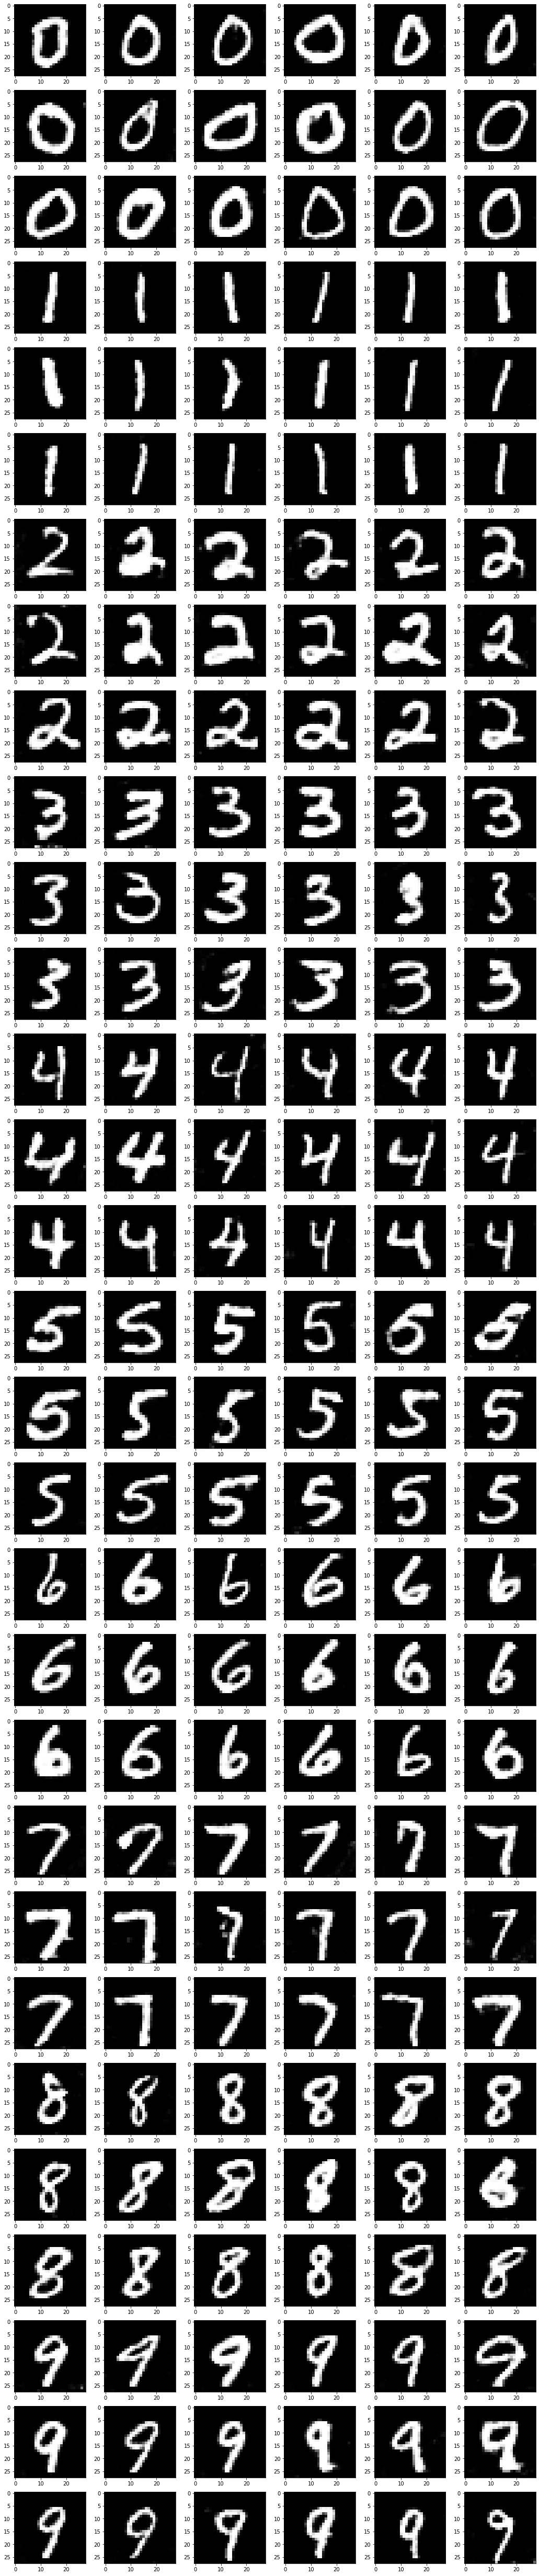

In [ ]:
arr = np.arange(10).reshape((10,1))
labels = np.tile(arr, [1,18])
labels = labels.flatten()
print(labels)

#without averaging
cgan.draw_generated_images(rows=30, cols=6, labels=labels)

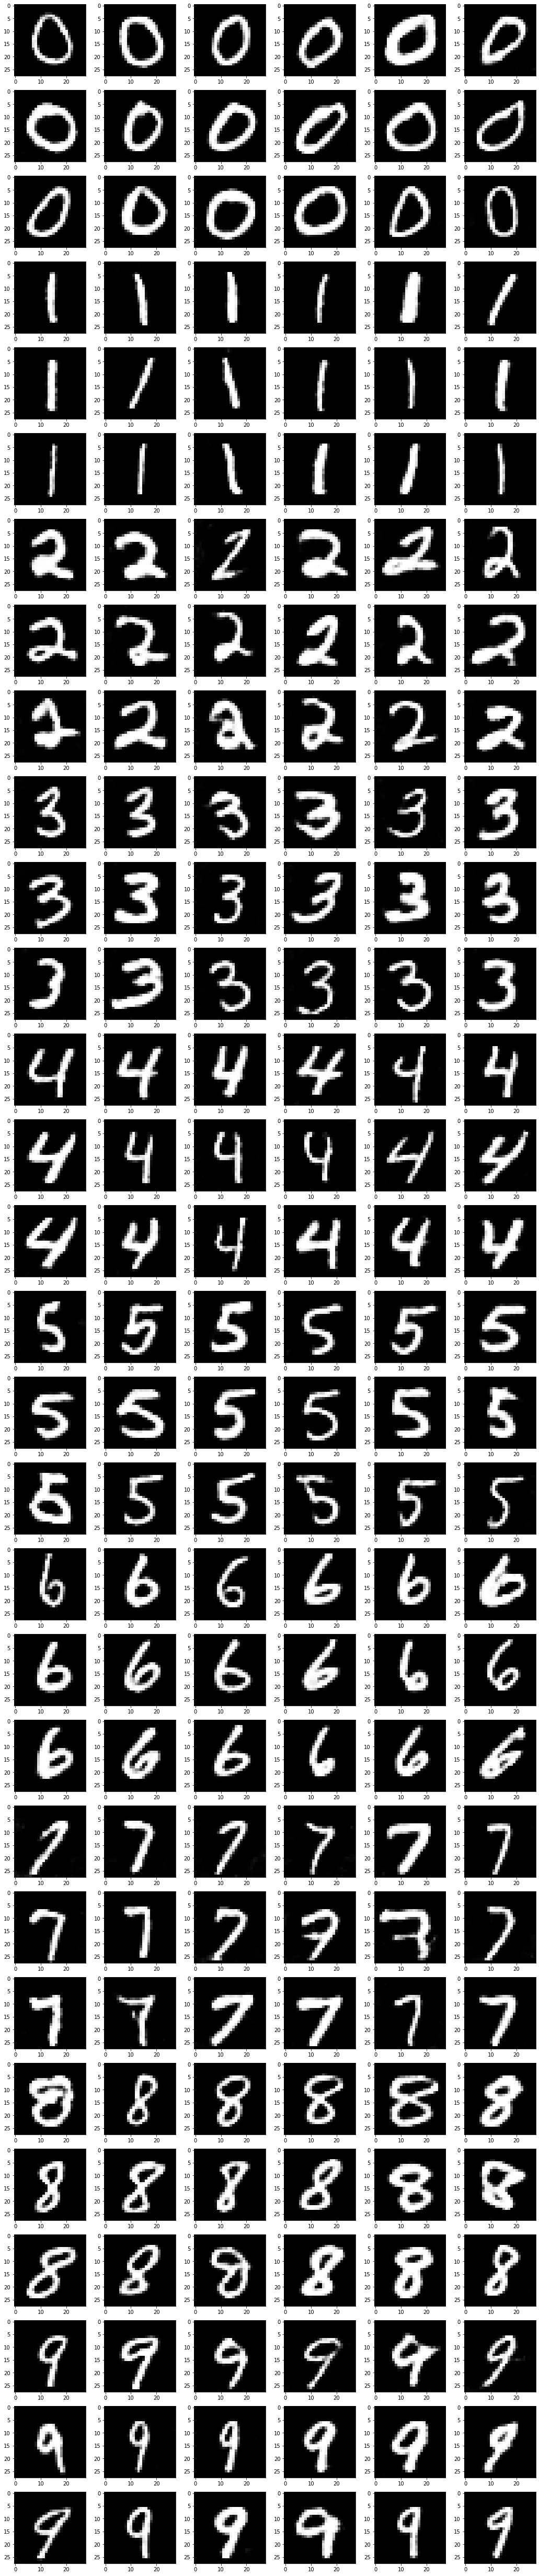

In [ ]:
#with averaging
cgan.draw_generated_images(rows=30, cols=6, labels=labels, is_from_gen_avr=True)